In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import glob
import plotly.io as pio
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
import pandas as pd
import time

import os
os.chdir('/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns')
from isochrone_preprocessing_fns import *
from photmetry_catalog_preprocessing_fn import *
from plotting_fns import *
from map_analysis import align_images, set_phast_wcs, set_m31_wcs, make_m31_maps_FITS

print(sns.__version__)
import matplotlib
print(matplotlib.__version__)
print(pd.__version__)

0.13.2
3.8.2
2.2.0


In [5]:
# phast_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast-all-merged.fits'
# phast_catalog = fits.open(phast_fits_filepath)

# # phast_catalog.info()
# # phast_catalog[1].header['*']

# phast_table = phast_catalog[1].data
# # phast_table.shape

# # Print all column names
# print("Column names in the PHAST catalog:")
# for column_name in phast_table.columns.names:
#     print(column_name)  

# # print("Adding F475W and F814W columns to table")
# # phast_table = Table()
# # phast_table["ra"] = phast_catalog[1].data["ra"]

# # phast_merged_df.columns

# PHAST

### - Make optical catalog - include F275W cols for UV band

In [ ]:
# phast_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4band-merged.fits'
phast_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast-all-merged.fits'
output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv'
phast_df = make_optical_photmetry_from_hst_dataproduct(photmetry_catalog_filepath=phast_fits_filepath, output_csv_filepath=output_file)

Adding F475W and F814W columns to table
Save catalog to CSV


### Forground extinction correction and GST selection 

In [2]:
# output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv'
start_time = time.time()
phast_df = phast_reduce_optical_photmetry_table(photometry_fits_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phast_f475W_f814W_table.csv', 
                                            # output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phast_table.csv',
                                            output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/phast_gst_optical_catalog.csv', 
                                            gst_criteria = 'Z24')
end_time = time.time()
print(f"phast_reduce_optical_photmetry_table finished in {(end_time - start_time)/60} minutes")


Total number of stars: 96033989
Applying Zhuo et al 2024 GST criteria


/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns/photmetry_catalog_preprocessing_fn.py:262: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_df["f814w_vega_ecorr"] = catalog_df["f814w_vega"] - 0.596 * 0.17
/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns/photmetry_catalog_preprocessing_fn.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_df["f475w_vega_ecorr"] = catalog_df["f475w_vega"] - 1.212 * 0.17
/Users/mmckay/phd_projects/analysis_routine/code/photometry_

Total number of stars after GST cuts and correction: 6350718
phast_reduce_optical_photmetry_table finished in 20.356156182289123 minutes


### -Interpolation

In [3]:
start_time = time.time()
catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phast_table.csv'
# isochrone_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/RGB_isochrone_tables/RGB_AGB_isochrone_table.csv'
# isochrone_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB_AGB/RGB_AGB_isochrone_table.csv'
isochrone_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_isochrone_table.csv'
output_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv'

interpolated_phast_rgb_agb = catalog_linear_interpolation(catalog_csv_filepath,
                                                            isochrone_csv_filepath,
                                                            output_filepath, 
                                                            savefile=True)

end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")


Running LinearNDInterpolator
Dropping fill values if any 272731
Saving the photometry catalog with interpolated values as /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv
finished in 4.900309689839681 minutes


### -RGB selection

Saved RGB selection to /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_g15_rgb_selection.csv
Saved CMD plot to /Users/mmckay/phd_projects/analysis_routine/FIGURES/phast_cmd_plot.jpeg


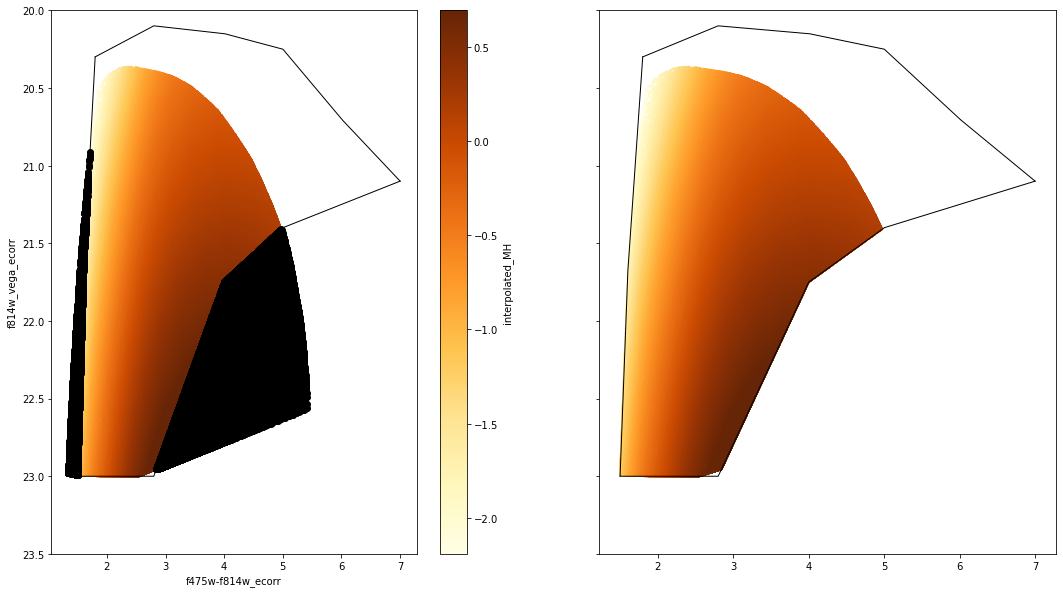

finished in 10.905729115009308 minutes


<Figure size 432x288 with 0 Axes>

In [4]:
start_time = time.time()

csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_rgb_catalog.csv'
f814w_col = 'f814w_vega_ecorr'
f475w_f814_col = 'f475w-f814w_ecorr'
z_col = 'interpolated_MH'
savefile_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_g15_rgb_selection.csv'
savefig_filepath = '/Users/mmckay/phd_projects/analysis_routine/FIGURES/phast_cmd_plot.jpeg'

plot_CMD(csv_filepath, f814w_col, f475w_f814_col, z_col, savefile=True, apply_phat_rgb_MH_selection=True, save_rgb_selection=True, save_filepath=savefile_path, savefig_filepath=savefig_filepath)


end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")


### Plot CMD MDF stellar density and median M/H

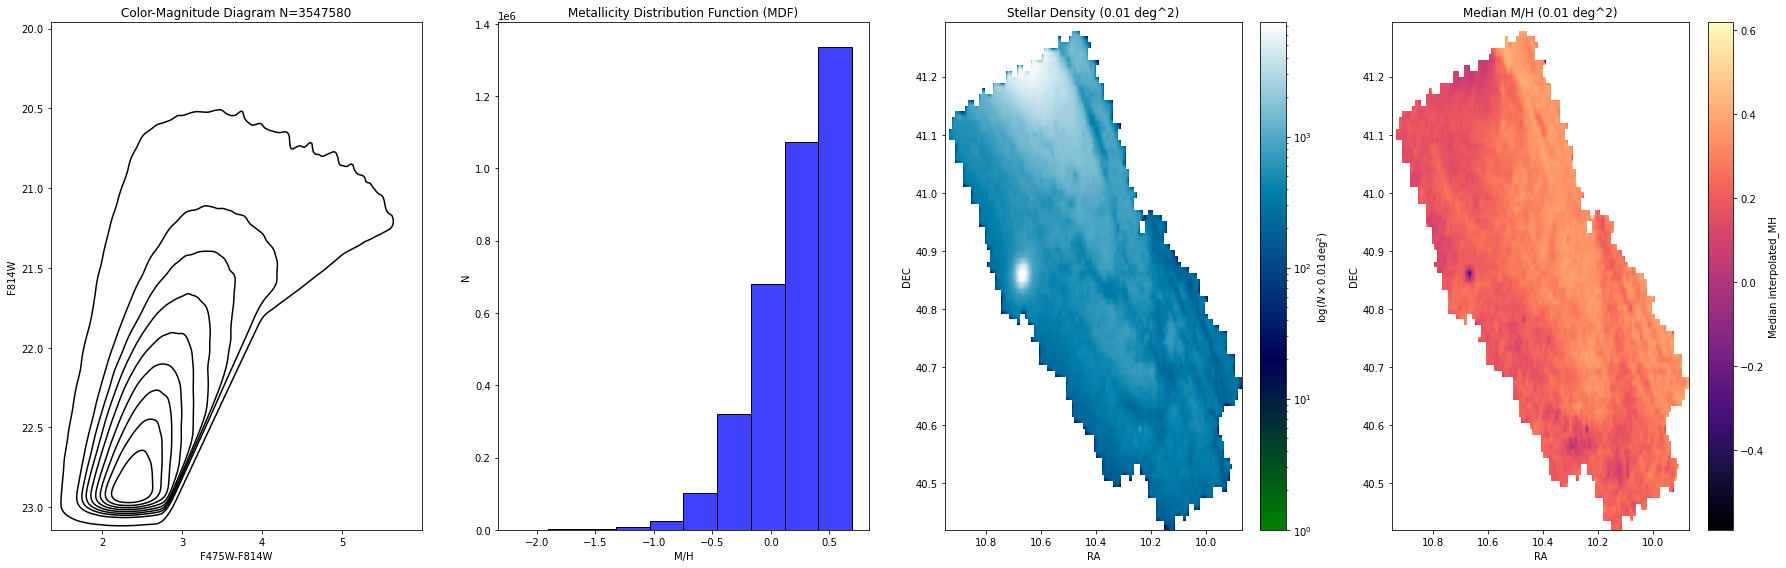

In [2]:
phast_rgb_gregersen_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/test_modules/phast_rgb_selection.csv')
median_arr, stellar_density_arr = plot_cmd_mdf_spatial(phast_rgb_gregersen_selection_df, 
                     savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/phast_cmd_mdf_spatial_gregersen_box.jpeg', 
                     bin_size_deg=0.01, z_col='interpolated_MH')

# PHAT
- made on remote machine

In [ ]:
# phat_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/hlsp_phat_hst_wfc3-uvis-acs-wfc-wfc3-ir_m33_f275w-f336w-f475w-f814w-f110w-f160w_v1_phot.fits'
# output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phat_f475W_f814W_table.csv'
# # phat_df = make_optical_photmetry_from_hst_dataproduct(photmetry_catalog_filepath=phat_fits_filepath, output_csv_filepath=output_file)
# make_optical_photmetry_from_hst_dataproduct(photmetry_catalog_filepath=phat_fits_filepath, output_csv_filepath=output_file)

In [5]:
# output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phat_f475W_f814W_table.csv'
start_time = time.time()

phat_df = phat_reduce_optical_photmetry_table(photometry_fits_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/phat_f475W_f814W_table.csv', 
                                            output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/phat_gst_optical_catalog.csv')

end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

Total number of stars: 51904126
Applying Zhuo et al 2024 GST criteria


/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns/photmetry_catalog_preprocessing_fn.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_df["f814w_vega_ecorr"] = catalog_df["f814w_vega"] - 0.596 * 0.17
/Users/mmckay/phd_projects/analysis_routine/code/photometry_fns/photmetry_catalog_preprocessing_fn.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog_df["f475w_vega_ecorr"] = catalog_df["f475w_vega"] - 1.212 * 0.17
/Users/mmckay/phd_projects/analysis_routine/code/photometry_

Total number of stars after GST cuts and correction: 7338541
finished in 5.801662532488505 minutes


### -Interpolation

In [6]:
start_time = time.time()
# catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phat_table.csv'
catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/phat_gst_optical_catalog.csv'
isochrone_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/RGB_isochrone_table.csv'
output_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_rgb_catalog.csv'

interpolated_phat_rgb_agb = catalog_linear_interpolation(catalog_csv_filepath, 
                                                            isochrone_csv_filepath,
                                                            output_filepath, 
                                                            savefile=True)

end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

Running LinearNDInterpolator
Dropping fill values if any 360308
Saving the photometry catalog with interpolated values as /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_rgb_catalog.csv
finished in 7.051022100448608 minutes


Saved RGB selection to /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_g15_rgb_selection.csv
Saved CMD plot to /Users/mmckay/phd_projects/analysis_routine/FIGURES/phat_cmd_plot.jpeg


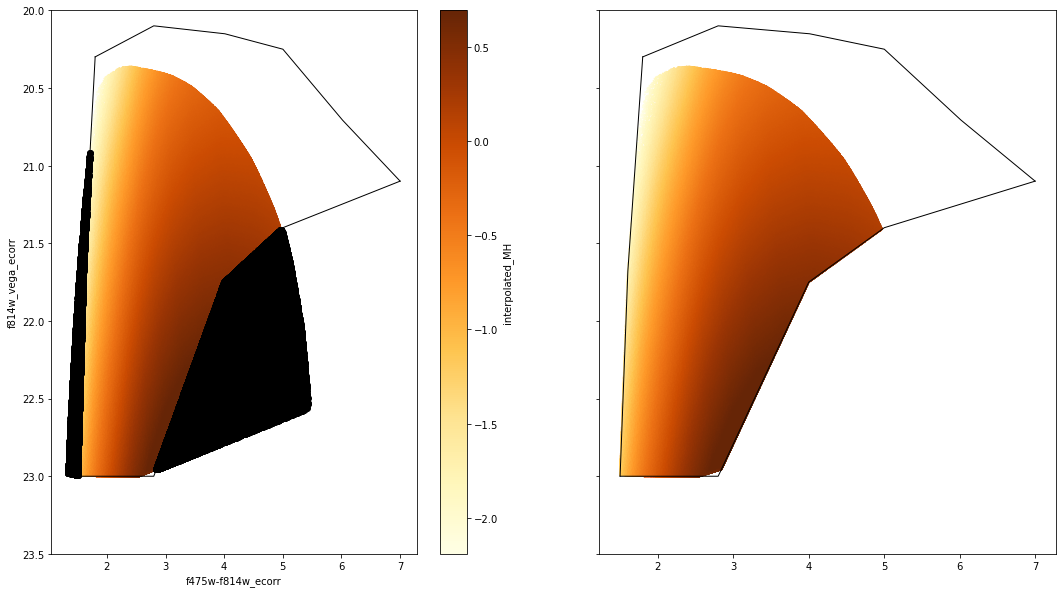

finished in 16.481434965133666 minutes


<Figure size 432x288 with 0 Axes>

In [2]:
start_time = time.time()
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_rgb_catalog.csv'
f814w_col = 'f814w_vega_ecorr'
f475w_f814_col = 'f475w-f814w_ecorr'
z_col = 'interpolated_MH'
savefile_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_g15_rgb_selection.csv'
savefig_filepath = '/Users/mmckay/phd_projects/analysis_routine/FIGURES/phat_cmd_plot.jpeg'
plot_CMD(csv_filepath, f814w_col, f475w_f814_col, z_col, savefile=True, apply_phat_rgb_MH_selection=True, save_rgb_selection=True, save_filepath=savefile_path, savefig_filepath=savefig_filepath)


end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

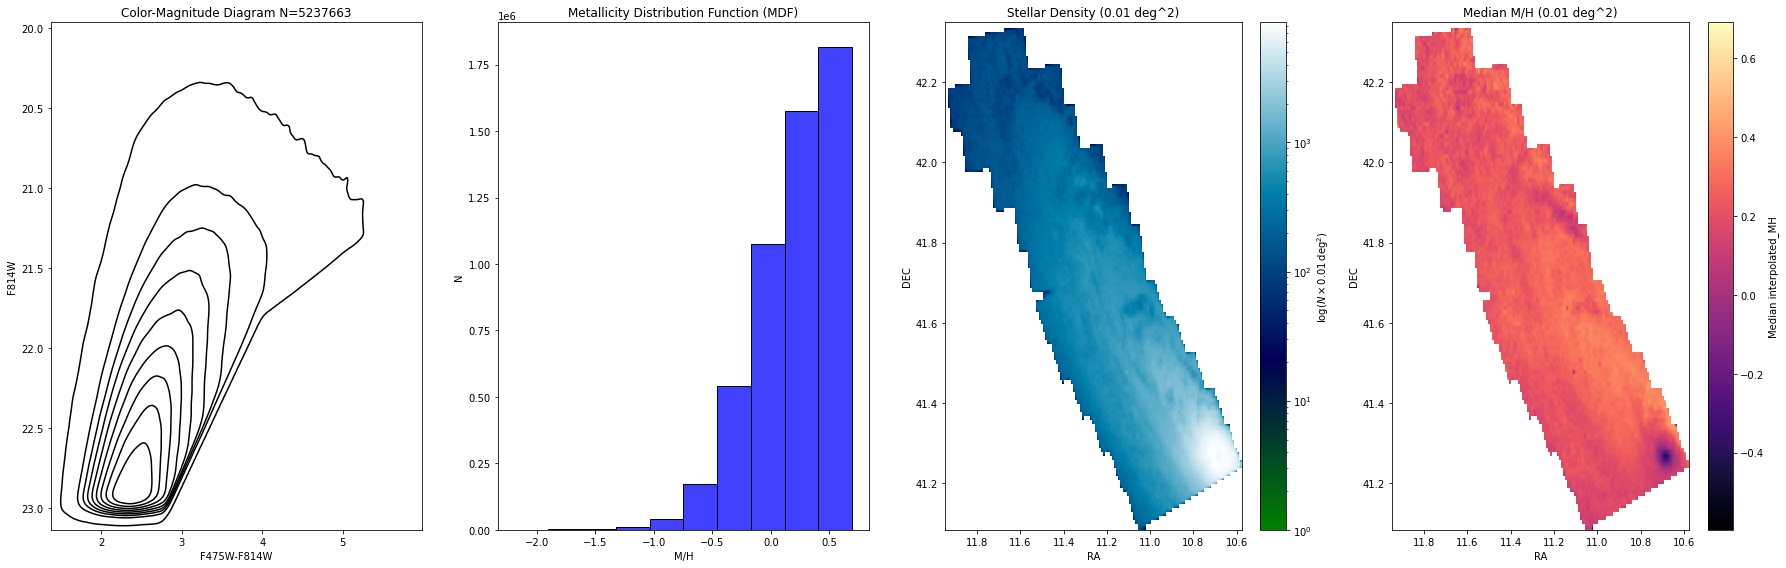

In [6]:
phat_rgb_gregersen_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phat_rgb_agb_selection.csv')
median_arr, stellar_density_arr = plot_cmd_mdf_spatial(phat_rgb_gregersen_selection_df, 
                     savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/phat_cmd_mdf_spatial_gregersen_box.jpeg', 
                     bin_size_deg=0.01, z_col='interpolated_MH')

# M31 Mapping 
- combine PHAT and PHAST catalog

In [2]:
start_time = time.time()
phat_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phat_g15_rgb_selection.csv')
phast_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_phast_g15_rgb_selection.csv')

end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

finished in 0.9353641033172607 minutes


In [3]:
start_time = time.time()
m31_df = pd.concat([phat_df, phast_df], axis=0, ignore_index=True)
m31_df = m31_df.drop(columns=set(phat_df.columns) ^ set(phast_df.columns))
print(len(m31_df))
m31_df = m31_df.drop_duplicates(subset=['ra', 'dec'])
print(len(m31_df))

m31_df.to_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv', index=False)
end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

11213033
11213033
finished in 5.919483168919881 minutes


In [4]:
# write FITS file
start_time = time.time()
from map_analysis import make_m31_maps_FITS
csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv'
make_m31_maps_FITS(csv_filepath, output_fitsfile='/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', overwrite=True)

end_time = time.time()
print(f"finished in {(end_time - start_time)/60} minutes")

Reading catalog...
Binning Maps...
F475W_VEGA
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W_SNR
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W_CROWD
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W_SHARP
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W_FLAG
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_VEGA
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_SNR
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_CROWD
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_SHARP
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_FLAG
Binning...
(209, 193)
Appending Binned Map to HDU object
F814W_VEGA_ECORR
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W_VEGA_ECORR
Binning...
(209, 193)
Appending Binned Map to HDU object
F475W-F814W_ECORR
Binning...
(209, 193)
Appending Binned Map to HDU object
INTERPOLATED_MH
Binning...
(209, 193)
Appending Binned Map t

In [27]:
# Set Primary header WCS
# Load the FITS file
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', mode='update') as hdu:
    header = hdu[0].header

    # Extract the WCS
    wcs = WCS(header)

    # Calculate the scale in degrees per pixel
    scale_deg_per_pix = wcs.pixel_scale_matrix[0,0] * np.sqrt(1 - wcs.pixel_scale_matrix[0,1]**2)
    scale_deg_per_pix = np.abs(scale_deg_per_pix)  # Take the absolute value to ensure the scale is positive

    # Assume a distance to the object in kpc
    distance_kpc = 778  # Replace with the actual distance

    # Convert the scale to kpc per pixel
    scale_kpc_per_pix = scale_deg_per_pix * np.pi / 180 * distance_kpc
    print(f"Scale: {scale_deg_per_pix} deg/pix = {scale_kpc_per_pix} kpc/pix")

    wcs.wcs.crval = [10.65, 41.20]
    # wcs.wcs.crval = [10.79, 41.33]
    wcs.wcs.crpix = [84, 81]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    wcs.wcs.cdelt = [np.rad2deg(np.radians(0.01)*np.cos(np.radians(wcs.wcs.crval[1]))), 0.01] # pixel scale in degrees/pixel #* Works with the right scaling...
    wcs.wcs.cunit = ["deg", "deg"]

    center_x_pix = wcs.wcs.crpix[0]
    center_y_pix = wcs.wcs.crpix[1]

    center_x_ra = wcs.wcs.crval[0]
    center_y_dec = wcs.wcs.crval[1]

    # print(f"Center pixel: {center_x_pix}, {center_y_pix}")
    # print(f"Center RA, Dec: {center_x_ra}, {center_y_dec}")
    header.update(wcs.to_header())
    print(wcs)


# Open the FITS file
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', mode='update') as hdul:
    # Get the primary header
    primary_header = hdul[0].header

    # Loop through each extension
    for hdu in hdul[:]:
        # Set the header of the extension to match the primary header
        for key in primary_header:
            if key not in hdu.header:
                hdu.header[key] = primary_header[key]

Scale: 0.0075241490889572 deg/pix = 0.10216787416029673 kpc/pix
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.007524149088957243 0.01 
NAXIS : 0  0


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.79 41.33 
CRPIX : 626.5 626.5 
CD1_1 CD1_2  : -0.00277778 0.0 
CD2_1 CD2_2  : 0.0 0.00277778 
NAXIS : 1250  1250
<class 'numpy.ndarray'>


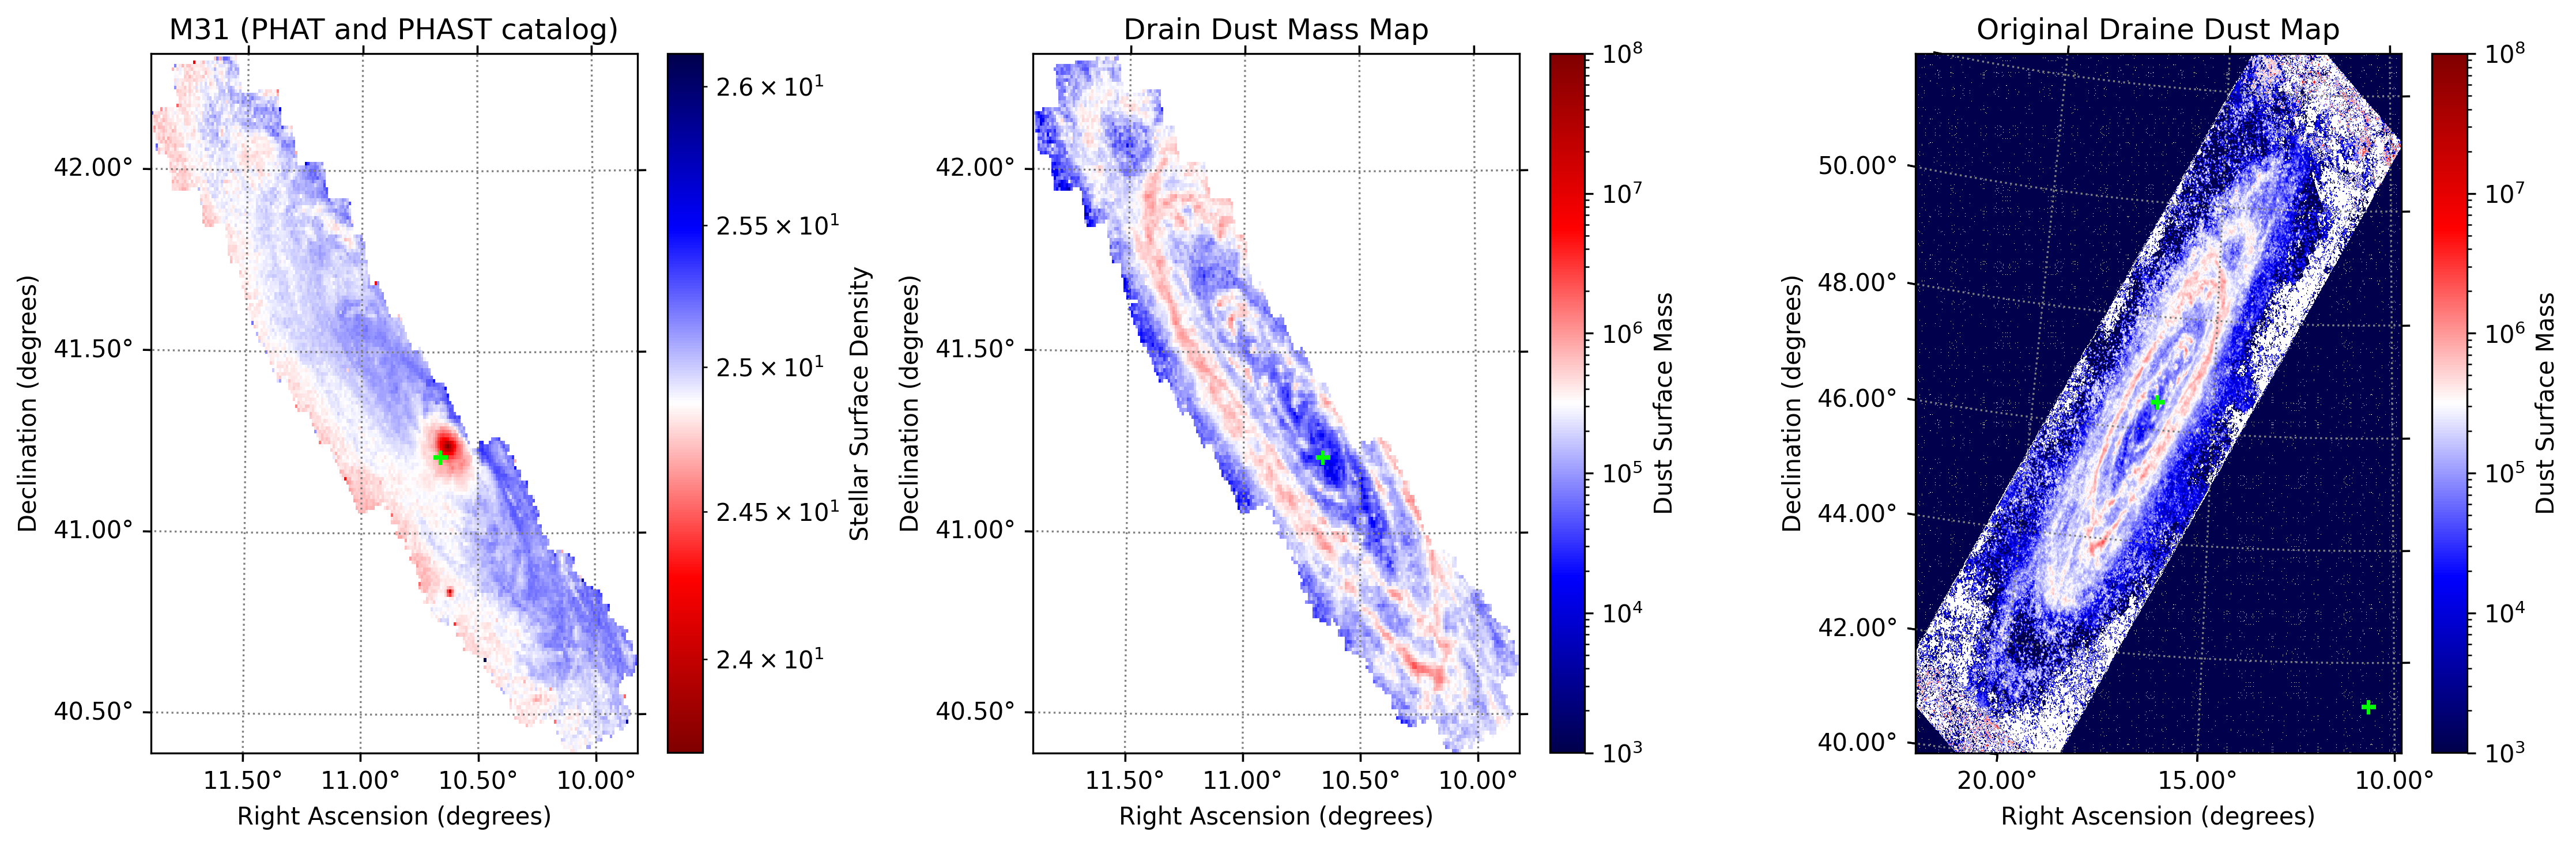

In [15]:
from astropy.wcs import WCS
from reproject import reproject_interp
from astropy.io import fits
import numpy as np

def align_images(input_file_high_res, input_file_low_res, highres_ext=0):
    # Use context manager to ensure FITS files are properly closed
    with fits.open(input_file_high_res) as hdul_high_res:
        data_high_res = hdul_high_res[highres_ext].data
        wcs_high_res = WCS(hdul_high_res[highres_ext].header)
        print(wcs_high_res)

    with fits.open(input_file_low_res) as hdul_low_res:
        data_low_res = hdul_low_res[0].data
        wcs_low_res = WCS(hdul_low_res[0].header)
        print(wcs_low_res)

    # Reproject the low-resolution image to match the high-resolution WCS
    data_reprojected, _ = reproject_interp((data_low_res, wcs_low_res), wcs_high_res, shape_out=data_high_res.shape)

    return data_high_res, data_reprojected, wcs_high_res, data_low_res
# Example usage
# input_file_high_res = '/Users/mmckay/phd_projects/analysis_routine/DATA/m31_cmd_mdf_spatial_gregersen_box.fits'
input_file_high_res = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits'
input_file_low_res = '/Users/mmckay/phd_projects/analysis_routine/DATA/M31_dust_maps/M31_S350_110_SSS_110_Model_All_SurfBr_Mdust.fits'

high_res_data, reprojected_data, wcs, low_res_data = align_images(input_file_high_res, input_file_low_res, highres_ext=1)

# Remove NaN values from the high-resolution data
reprojected_data = np.ma.masked_array(reprojected_data, np.isnan(high_res_data), fill_value=np.nan)
reprojected_data = reprojected_data.filled()
print(type(reprojected_data))
# reprojected_data_ndarray = np.ma.filled(reprojected_data, fill_value=np.nan)


#? Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': wcs}, dpi=300)
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    # Set the format of the tick labels to decimal degrees
    ax.coords[0].set_format_unit('deg')
    ax.coords[1].set_format_unit('deg')
    ax.coords[0].set_major_formatter('d.dd')
    ax.coords[1].set_major_formatter('d.dd')

    # Optional: Customize the grid, labels, etc.
    ax.coords.grid(True, color='gray', ls='dotted')
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')

# ax0
# Plot the high_res_data
im0 = axs[0].imshow(high_res_data, cmap='seismic_r', norm=colors.LogNorm(), aspect='auto', origin='lower')
axs[0].set_title('M31 (PHAT and PHAST catalog)')
cbar0 = plt.colorbar(im0, ax=axs[0])
cbar0.set_label('Stellar Surface Density')
contour_levels = np.nanpercentile(high_res_data, [5, 25, 50, 75, 95, 99])
# axs[0].contour(high_res_data, levels=contour_levels, colors='black')
axs[0].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')

# ax1
im1 = axs[1].imshow(reprojected_data, cmap='seismic', norm=colors.LogNorm(vmin=1e3, vmax=1e8), aspect='auto', origin='lower')
axs[1].set_title('Drain Dust Mass Map')
# axs[1].contour(high_res_data, levels=contour_levels, colors='black')
cbar1 = plt.colorbar(im1, ax=axs[1])
cbar1.set_label('Dust Surface Mass')
axs[1].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')


# ax2
im2 = axs[2].imshow(low_res_data, cmap='seismic', norm=colors.LogNorm(vmin=1e3, vmax=1e8), aspect='auto')
# axs[2].contour(high_res_data, levels=contour_levels, colors='black')
axs[2].set_title('Original Draine Dust Map')
cbar2 = plt.colorbar(im2, ax=axs[2])
cbar2.set_label('Dust Surface Mass')

with fits.open(input_file_low_res) as hdul_low_res:
        data_low_res = hdul_low_res[0].data
        wcs_low_res = WCS(hdul_low_res[0].header)

axs[2].scatter(wcs_low_res.wcs.crpix[0], wcs_low_res.wcs.crpix[1], marker='+', color='lime')
axs[2].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')

for ax in axs:
    ax.invert_xaxis()
plt.tight_layout()
plt.show()

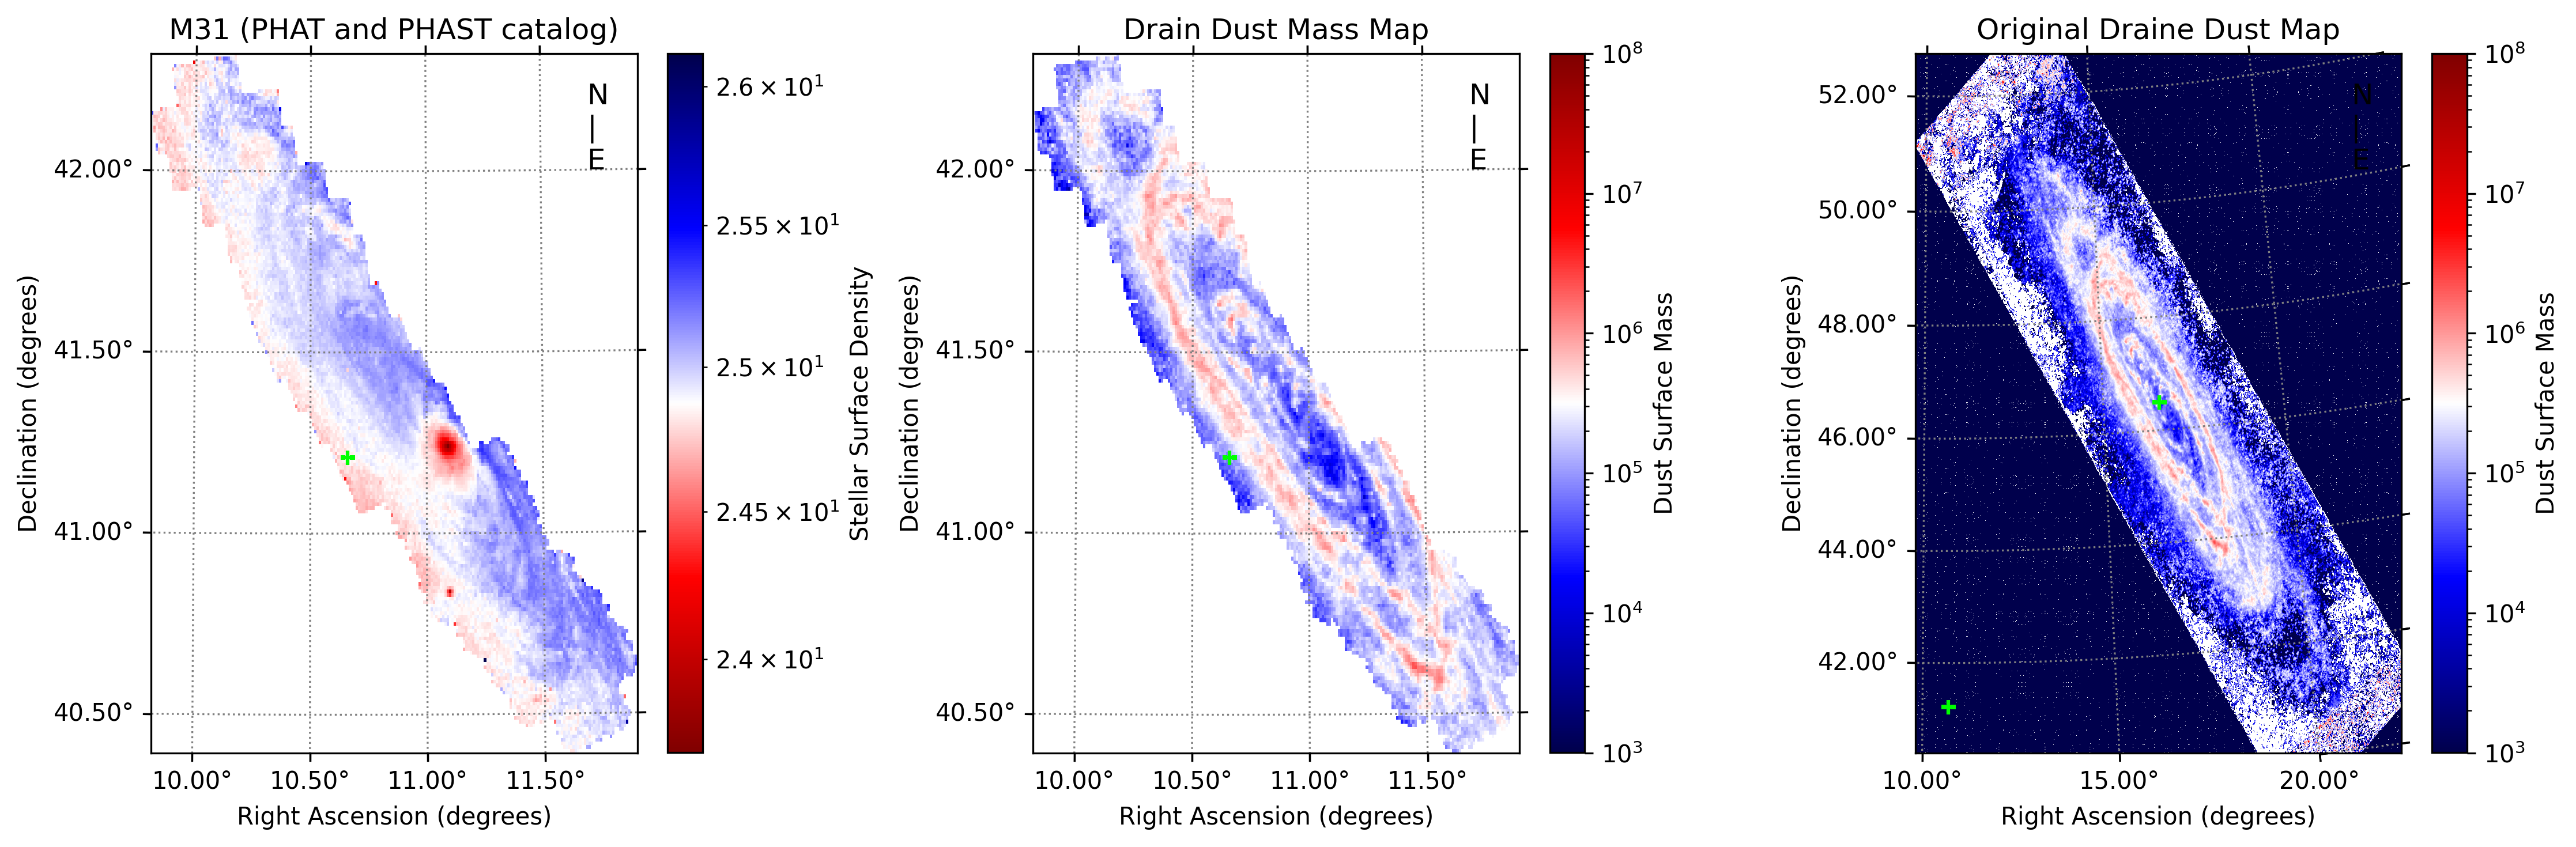

In [17]:
from astropy.visualization.wcsaxes import WCSAxes
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText

# Assuming the rest of your code remains the same

# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': wcs}, dpi=300)

for ax in axs:
    # Set the format of the tick labels to decimal degrees
    ax.coords[0].set_format_unit('deg')
    ax.coords[1].set_format_unit('deg')
    ax.coords[0].set_major_formatter('d.dd')
    ax.coords[1].set_major_formatter('d.dd')

    # Optional: Customize the grid, labels, etc.
    ax.coords.grid(True, color='gray', ls='dotted')
    ax.set_xlabel('Right Ascension (degrees)')
    ax.set_ylabel('Declination (degrees)')

    # Add north-east coordinate label
    text = AnchoredText('N\n|\nE', loc='upper right', frameon=False, pad=0.5, borderpad=0.5, prop=dict(color='black', size=12))
    ax.add_artist(text)

# ax0
# Plot the high_res_data
im0 = axs[0].imshow(np.flip(high_res_data, axis=1), cmap='seismic_r', norm=colors.LogNorm(), aspect='auto', origin='lower')
axs[0].set_title('M31 (PHAT and PHAST catalog)')
cbar0 = plt.colorbar(im0, ax=axs[0])
cbar0.set_label('Stellar Surface Density')
contour_levels = np.nanpercentile(high_res_data, [5, 25, 50, 75, 95, 99])
# axs[0].contour(high_res_data, levels=contour_levels, colors='black')
axs[0].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')

# ax1
im1 = axs[1].imshow(np.flip(reprojected_data, axis=1), cmap='seismic', norm=colors.LogNorm(vmin=1e3, vmax=1e8), aspect='auto', origin='lower')
axs[1].set_title('Drain Dust Mass Map')
# axs[1].contour(high_res_data, levels=contour_levels, colors='black')
cbar1 = plt.colorbar(im1, ax=axs[1])
cbar1.set_label('Dust Surface Mass')
axs[1].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')

# ax2
im2 = axs[2].imshow(low_res_data, cmap='seismic', norm=colors.LogNorm(vmin=1e3, vmax=1e8), aspect='auto')
# axs[2].contour(high_res_data, levels=contour_levels, colors='black')
axs[2].set_title('Original Draine Dust Map')
cbar2 = plt.colorbar(im2, ax=axs[2])
cbar2.set_label('Dust Surface Mass')

with fits.open(input_file_low_res) as hdul_low_res:
        data_low_res = hdul_low_res[0].data
        wcs_low_res = WCS(hdul_low_res[0].header)

axs[2].scatter(wcs_low_res.wcs.crpix[0], wcs_low_res.wcs.crpix[1], marker='+', color='lime')
axs[2].scatter(wcs.wcs.crpix[0], wcs.wcs.crpix[1], marker='+', color='lime')

# axs[2].invert_yaxis()
plt.tight_layout()
plt.show()

## Add Dust map to  maps fits file

In [11]:
# Rescasle and save dust map to Maps fits file
m31_fitspath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits'
with fits.open(m31_fitspath, mode='update') as hdul:
    hdul.info()
    if 'Draine_Dust_Mass_Map' in hdul:
        del hdul['Draine_Dust_Mass_Map']
        # hdul.writeto(m31_fitspath, overwrite=True)
        # hdul.info()
        new_hdu = fits.ImageHDU(data=reprojected_data)
        new_hdu.header['EXTNAME'] = 'Draine_Dust_Mass_Map'
        # Append the new HDU to the existing HDUList
        hdul.append(new_hdu)

        # Save the modified HDUList to the FITS file
        hdul.writeto(m31_fitspath, overwrite=True)
        hdul.info()

    else:
        new_hdu = fits.ImageHDU(data=reprojected_data)
        new_hdu.header['EXTNAME'] = 'Draine_Dust_Mass_Map'
        # Append the new HDU to the existing HDUList
        hdul.append(new_hdu)

        # Save the modified HDUList to the FITS file
        hdul.writeto(m31_fitspath, overwrite=True)
        hdul.info()

# Open the FITS file
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', mode='update') as hdul:
    # Get the primary header
    primary_header = hdul[0].header

    # Loop through each extension
    for hdu in hdul[:]:
        # Set the header of the extension to match the primary header
        for key in primary_header:
            if key not in hdu.header:
                hdu.header[key] = primary_header[key]

Filename: /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  F475W_VEGA    1 ImageHDU        26   (209, 193)   float64   
  2  F475W_SNR     1 ImageHDU        10   (209, 193)   float64   
  3  F475W_CROWD    1 ImageHDU        10   (209, 193)   float64   
  4  F475W_SHARP    1 ImageHDU        10   (209, 193)   float64   
  5  F475W_FLAG    1 ImageHDU        10   (209, 193)   float64   
  6  F814W_VEGA    1 ImageHDU        10   (209, 193)   float64   
  7  F814W_SNR     1 ImageHDU        10   (209, 193)   float64   
  8  F814W_CROWD    1 ImageHDU        10   (209, 193)   float64   
  9  F814W_SHARP    1 ImageHDU        10   (209, 193)   float64   
 10  F814W_FLAG    1 ImageHDU        10   (209, 193)   float64   
 11  F814W_VEGA_ECORR    1 ImageHDU        10   (209, 193)   float64   
 12  F475W_VEGA_ECORR    1 ImageHDU      

## Add Surface Density maps

In [24]:
# Bin MH spatially
m31_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv')
bin_size_deg = 0.01
m31_min_ra, m31_max_ra, m31_min_dec, m31_max_dec, m31_median_values, m31_sum_values, m31_bin_counts_nonzero, = create_spatial_bins_and_median_optimized(m31_df.ra, m31_df.dec, m31_df.interpolated_MH, bin_size_deg)



# Add Stellar Density 
m31_fitspath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits'
with fits.open(m31_fitspath, mode='update') as hdul:
    if 'STELLAR_DENSITY' in hdul:
        del hdul['STELLAR_DENSITY']
    hdul.info()
    new_hdu = fits.ImageHDU(data=m31_bin_counts_nonzero.T)
    new_hdu.header['EXTNAME'] = 'STELLAR_DENSITY'
    # Append the new HDU to the existing HDUList
    hdul.append(new_hdu)

    # Save the modified HDUList to the FITS file
    hdul.writeto(m31_fitspath, overwrite=True)
    hdul.info()

# Open the FITS file
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', mode='update') as hdul:
    # Get the primary header
    primary_header = hdul[0].header

    # Loop through each extension
    for hdu in hdul[1:]:
        # Set the header of the extension to match the primary header
        for key in primary_header:
            if key not in hdu.header:
                hdu.header[key] = primary_header[key]

Filename: /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  F475W_VEGA    1 ImageHDU        26   (209, 193)   float64   
  2  F475W_SNR     1 ImageHDU        25   (209, 193)   float64   
  3  F475W_CROWD    1 ImageHDU        25   (209, 193)   float64   
  4  F475W_SHARP    1 ImageHDU        25   (209, 193)   float64   
  5  F475W_FLAG    1 ImageHDU        25   (209, 193)   float64   
  6  F814W_VEGA    1 ImageHDU        25   (209, 193)   float64   
  7  F814W_SNR     1 ImageHDU        25   (209, 193)   float64   
  8  F814W_CROWD    1 ImageHDU        25   (209, 193)   float64   
  9  F814W_SHARP    1 ImageHDU        25   (209, 193)   float64   
 10  F814W_FLAG    1 ImageHDU        25   (209, 193)   float64   
 11  F814W_VEGA_ECORR    1 ImageHDU        25   (209, 193)   float64   
 12  F475W_VEGA_ECORR    1 ImageHDU      

In [18]:
# check header
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits') as hdu:
    header = hdu[3].header

    # Extract the WCS
    wcs = WCS(header)
    print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


# EXTRA - Not part the original process

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193
(193, 209)


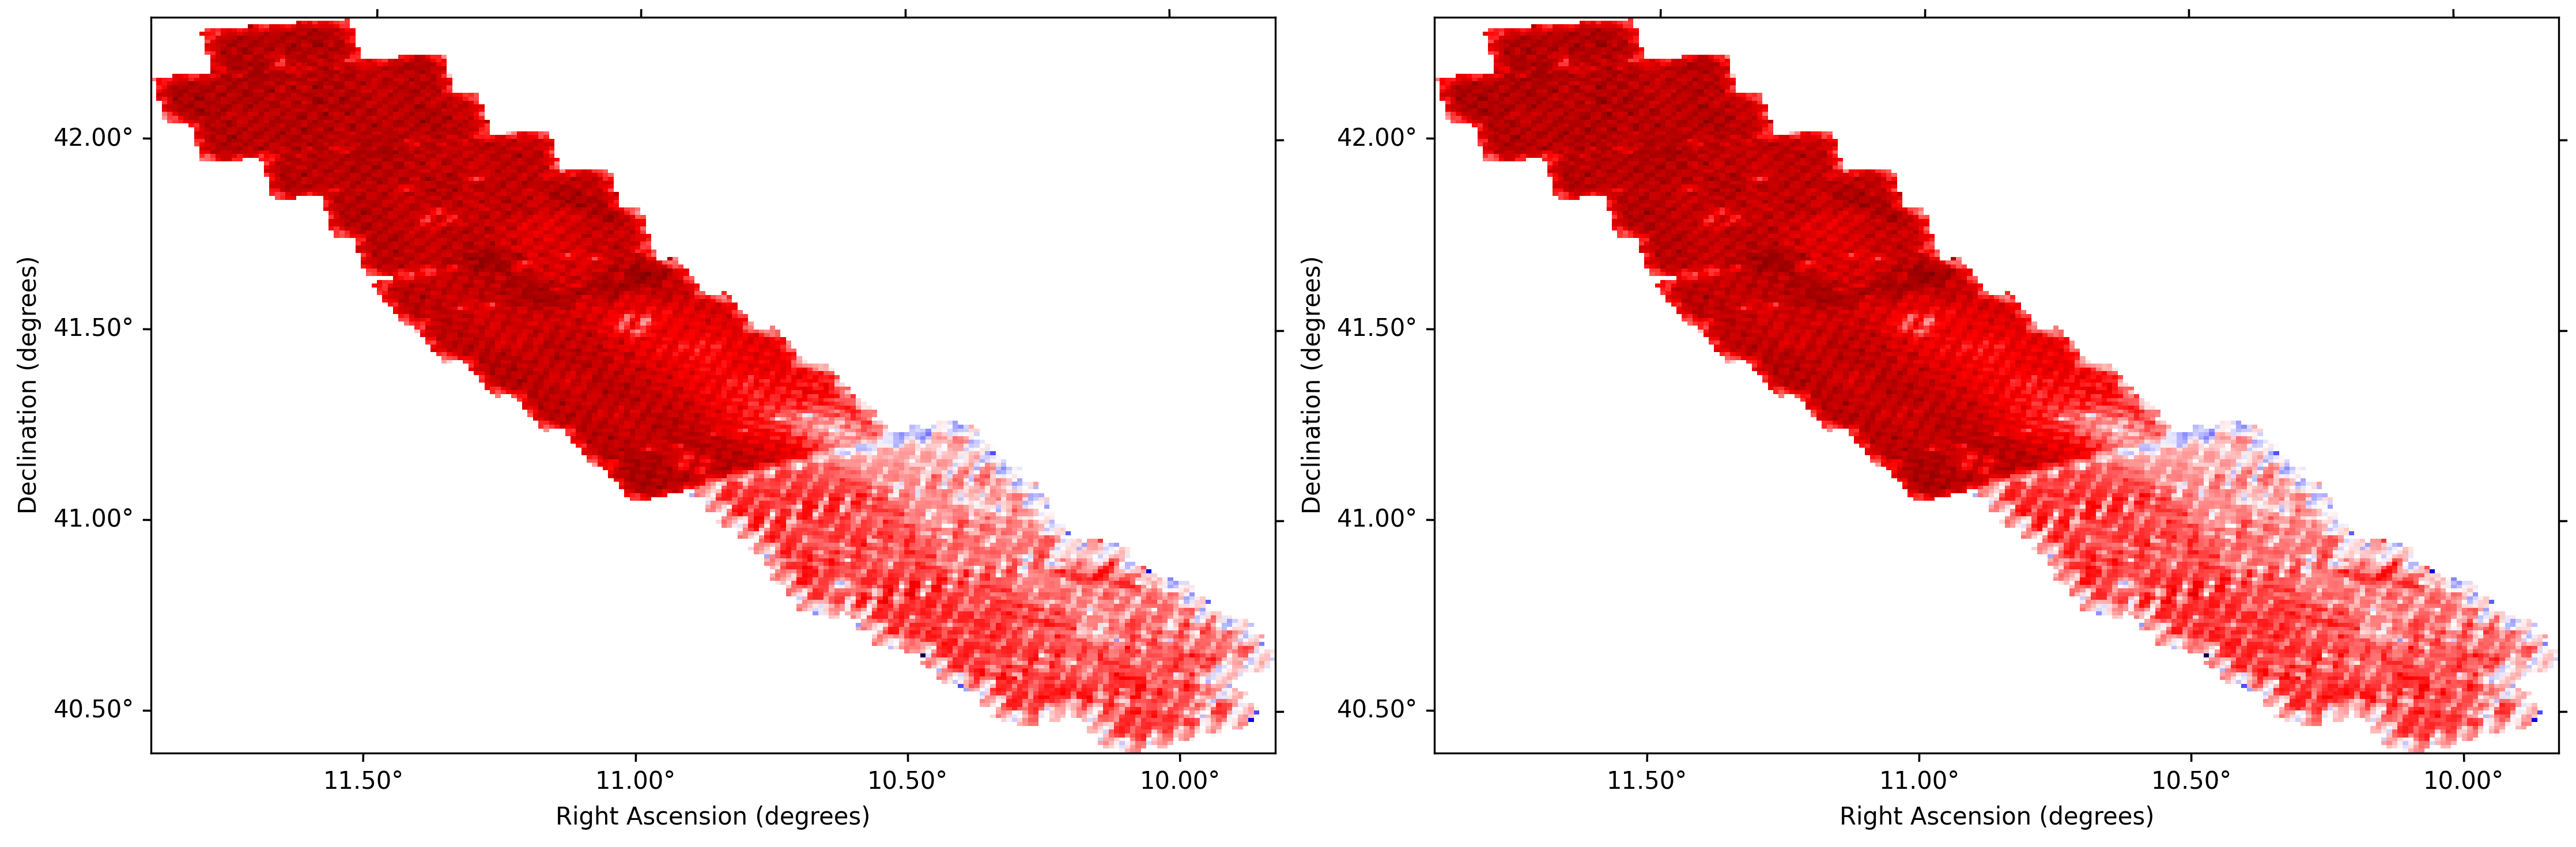

In [19]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import colors

# adjust the images in m31_g15_RGB_maps.fits to match the other catalogs
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits') as hdu:
    # Extract the WCS
    header = hdu[2].header
    wcs = WCS(header)
    print(wcs)
    # Start with the first image
    data_map = hdu[2].data
    print(data_map.shape)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': wcs}, dpi=300)
    for ax in axs:
        # Set the format of the tick labels to decimal degrees
        ax.coords[0].set_format_unit('deg')
        ax.coords[1].set_format_unit('deg')
        ax.coords[0].set_major_formatter('d.dd')
        ax.coords[1].set_major_formatter('d.dd')

        # Optional: Customize the grid, labels, etc.
        # ax.coords.grid(True, color='gray', ls='dotted')
        ax.set_xlabel('Right Ascension (degrees)')
        ax.set_ylabel('Declination (degrees)')
        ax.imshow(data_map, cmap='seismic', norm=colors.LogNorm(), aspect='auto')

        # Invert the x-axis
        ax.invert_xaxis()

plt.tight_layout()
plt.show()

# This is permanent

Extension 1: Data transposed and updated in FITS file
Extension 1: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


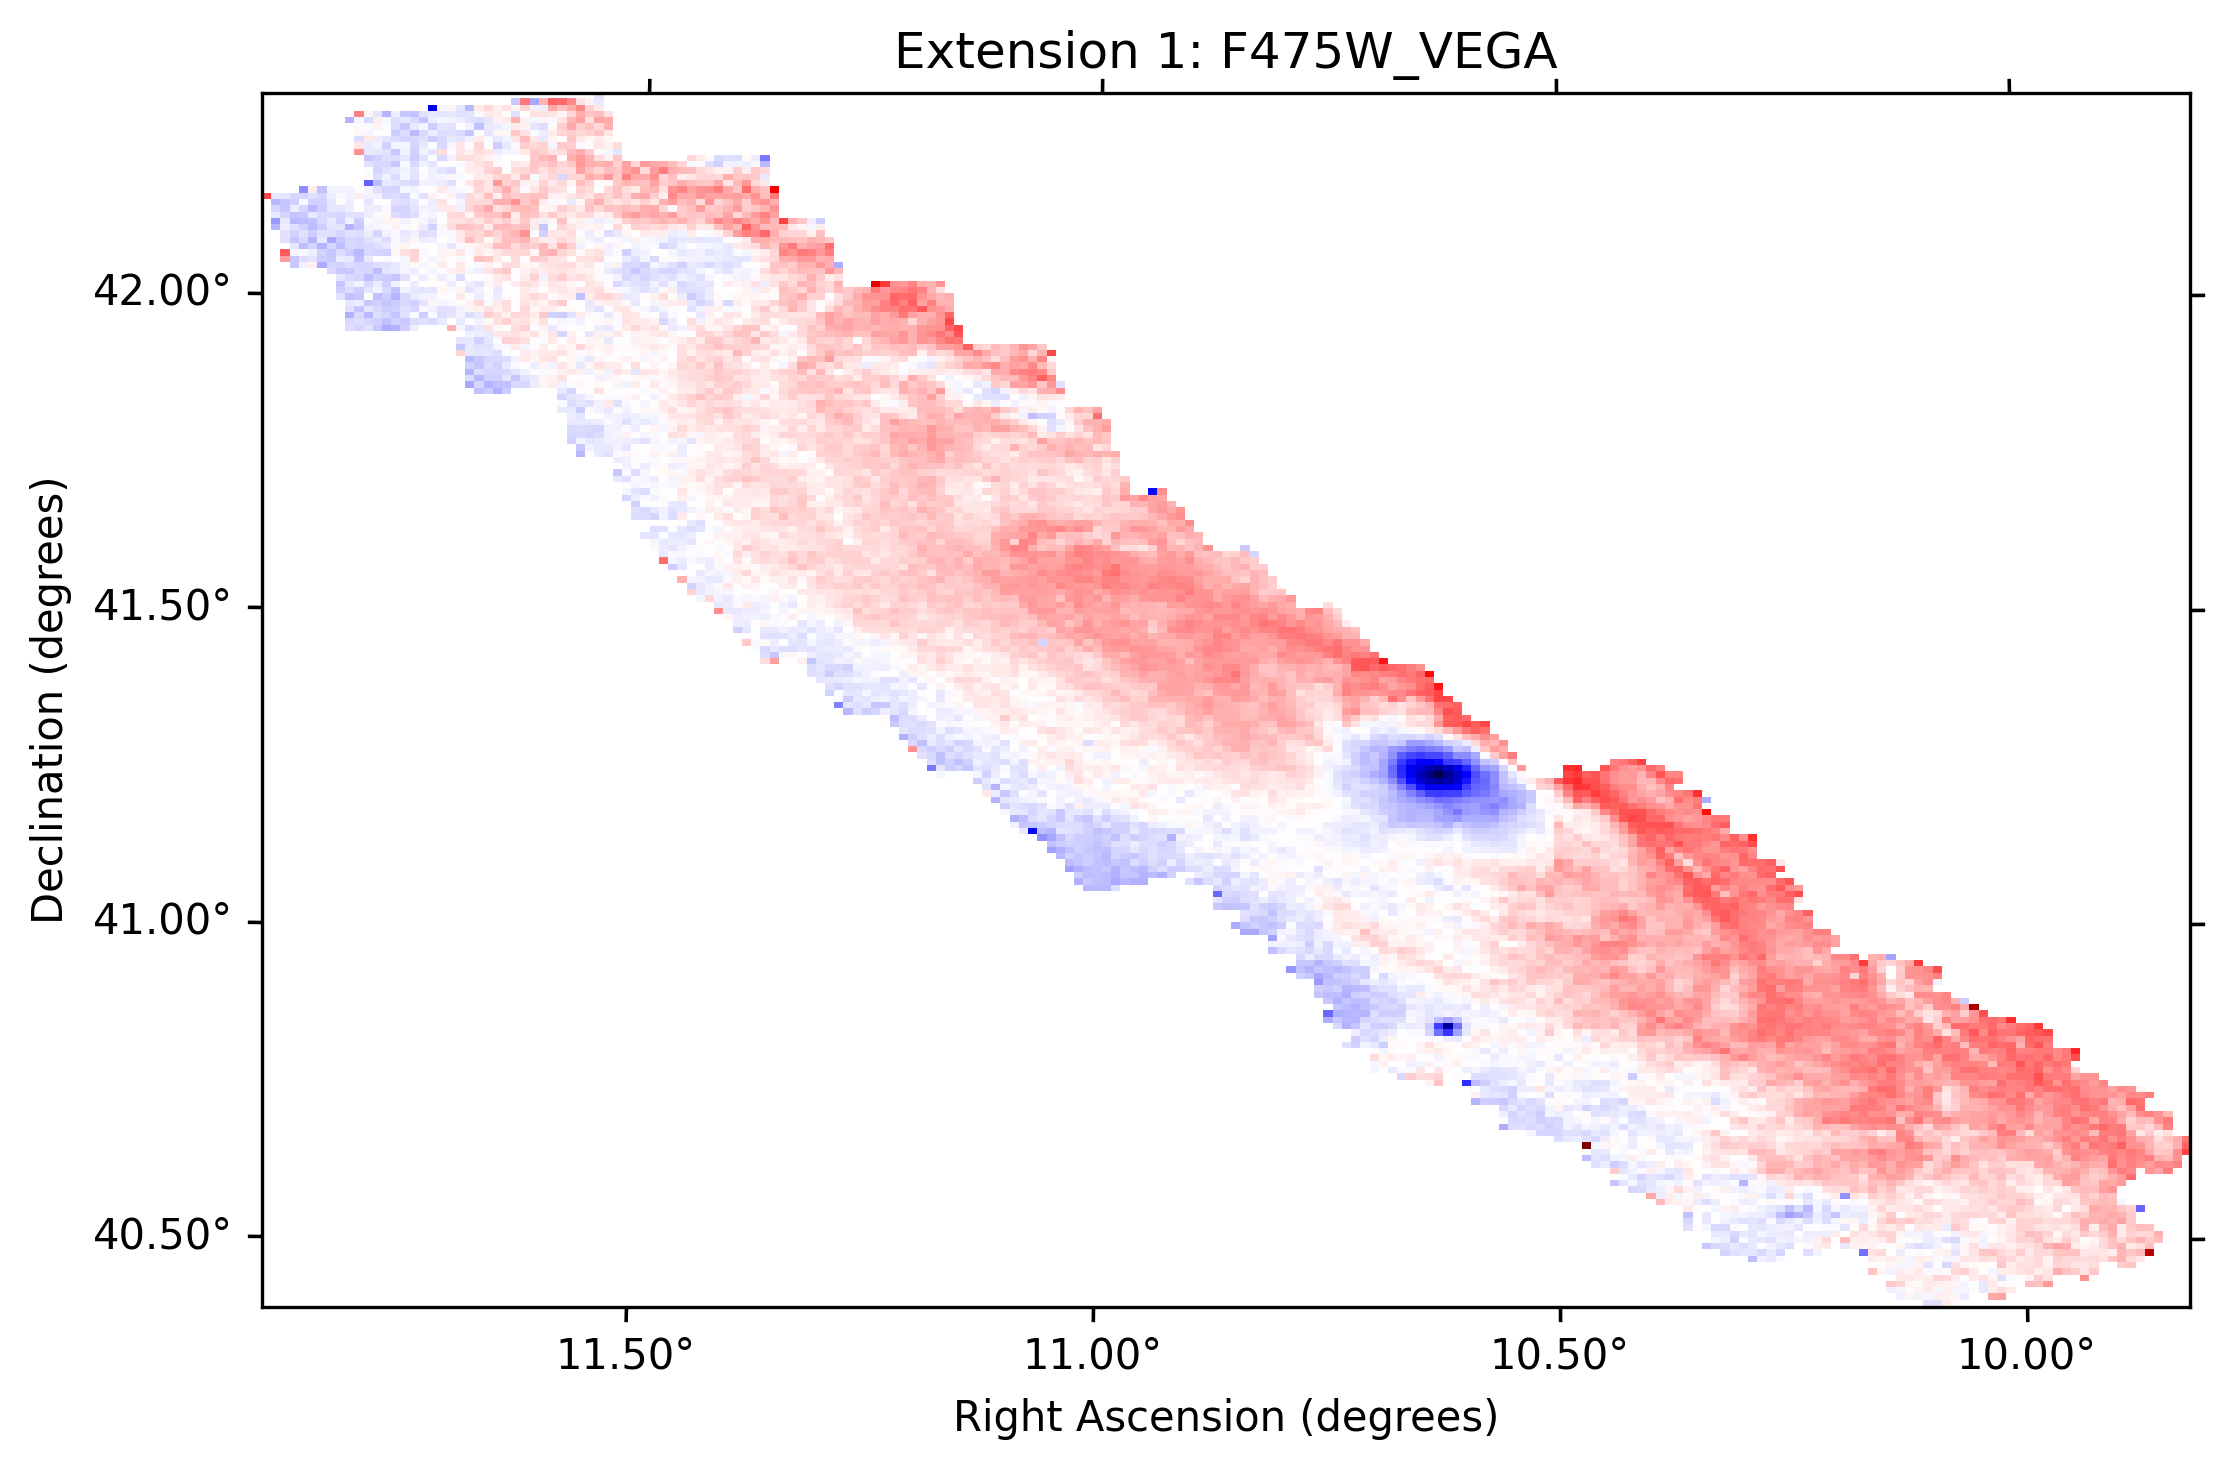

Extension 2: Data transposed and updated in FITS file
Extension 2: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


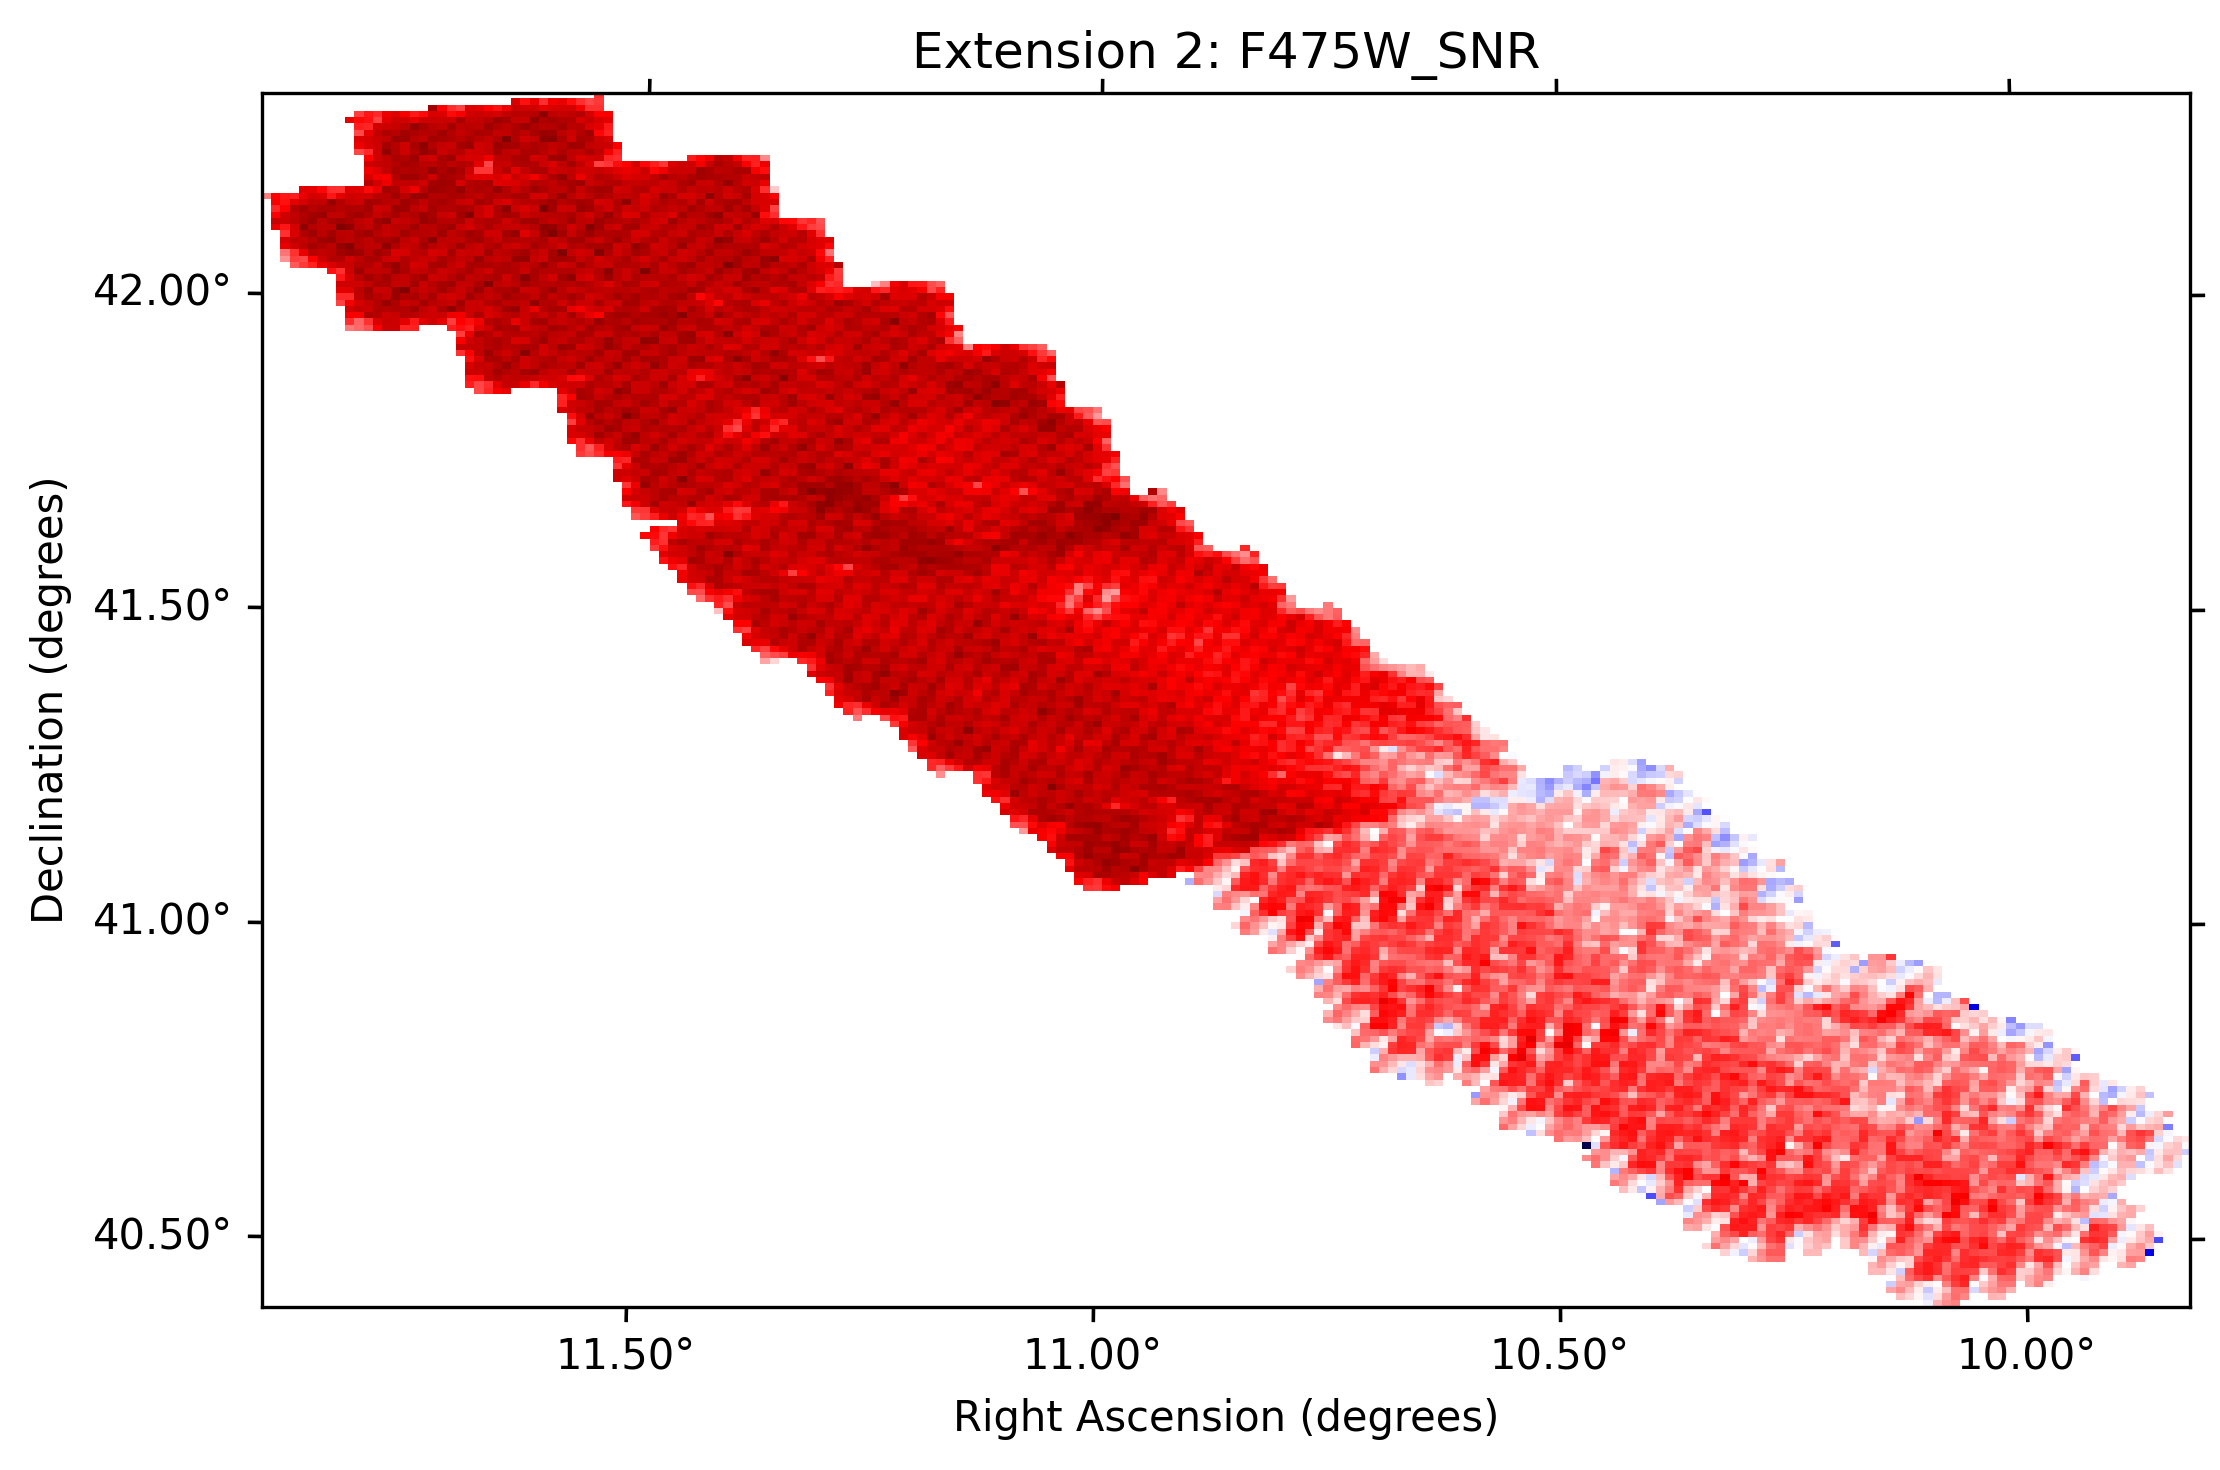

Extension 3: Data transposed and updated in FITS file
Extension 3: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


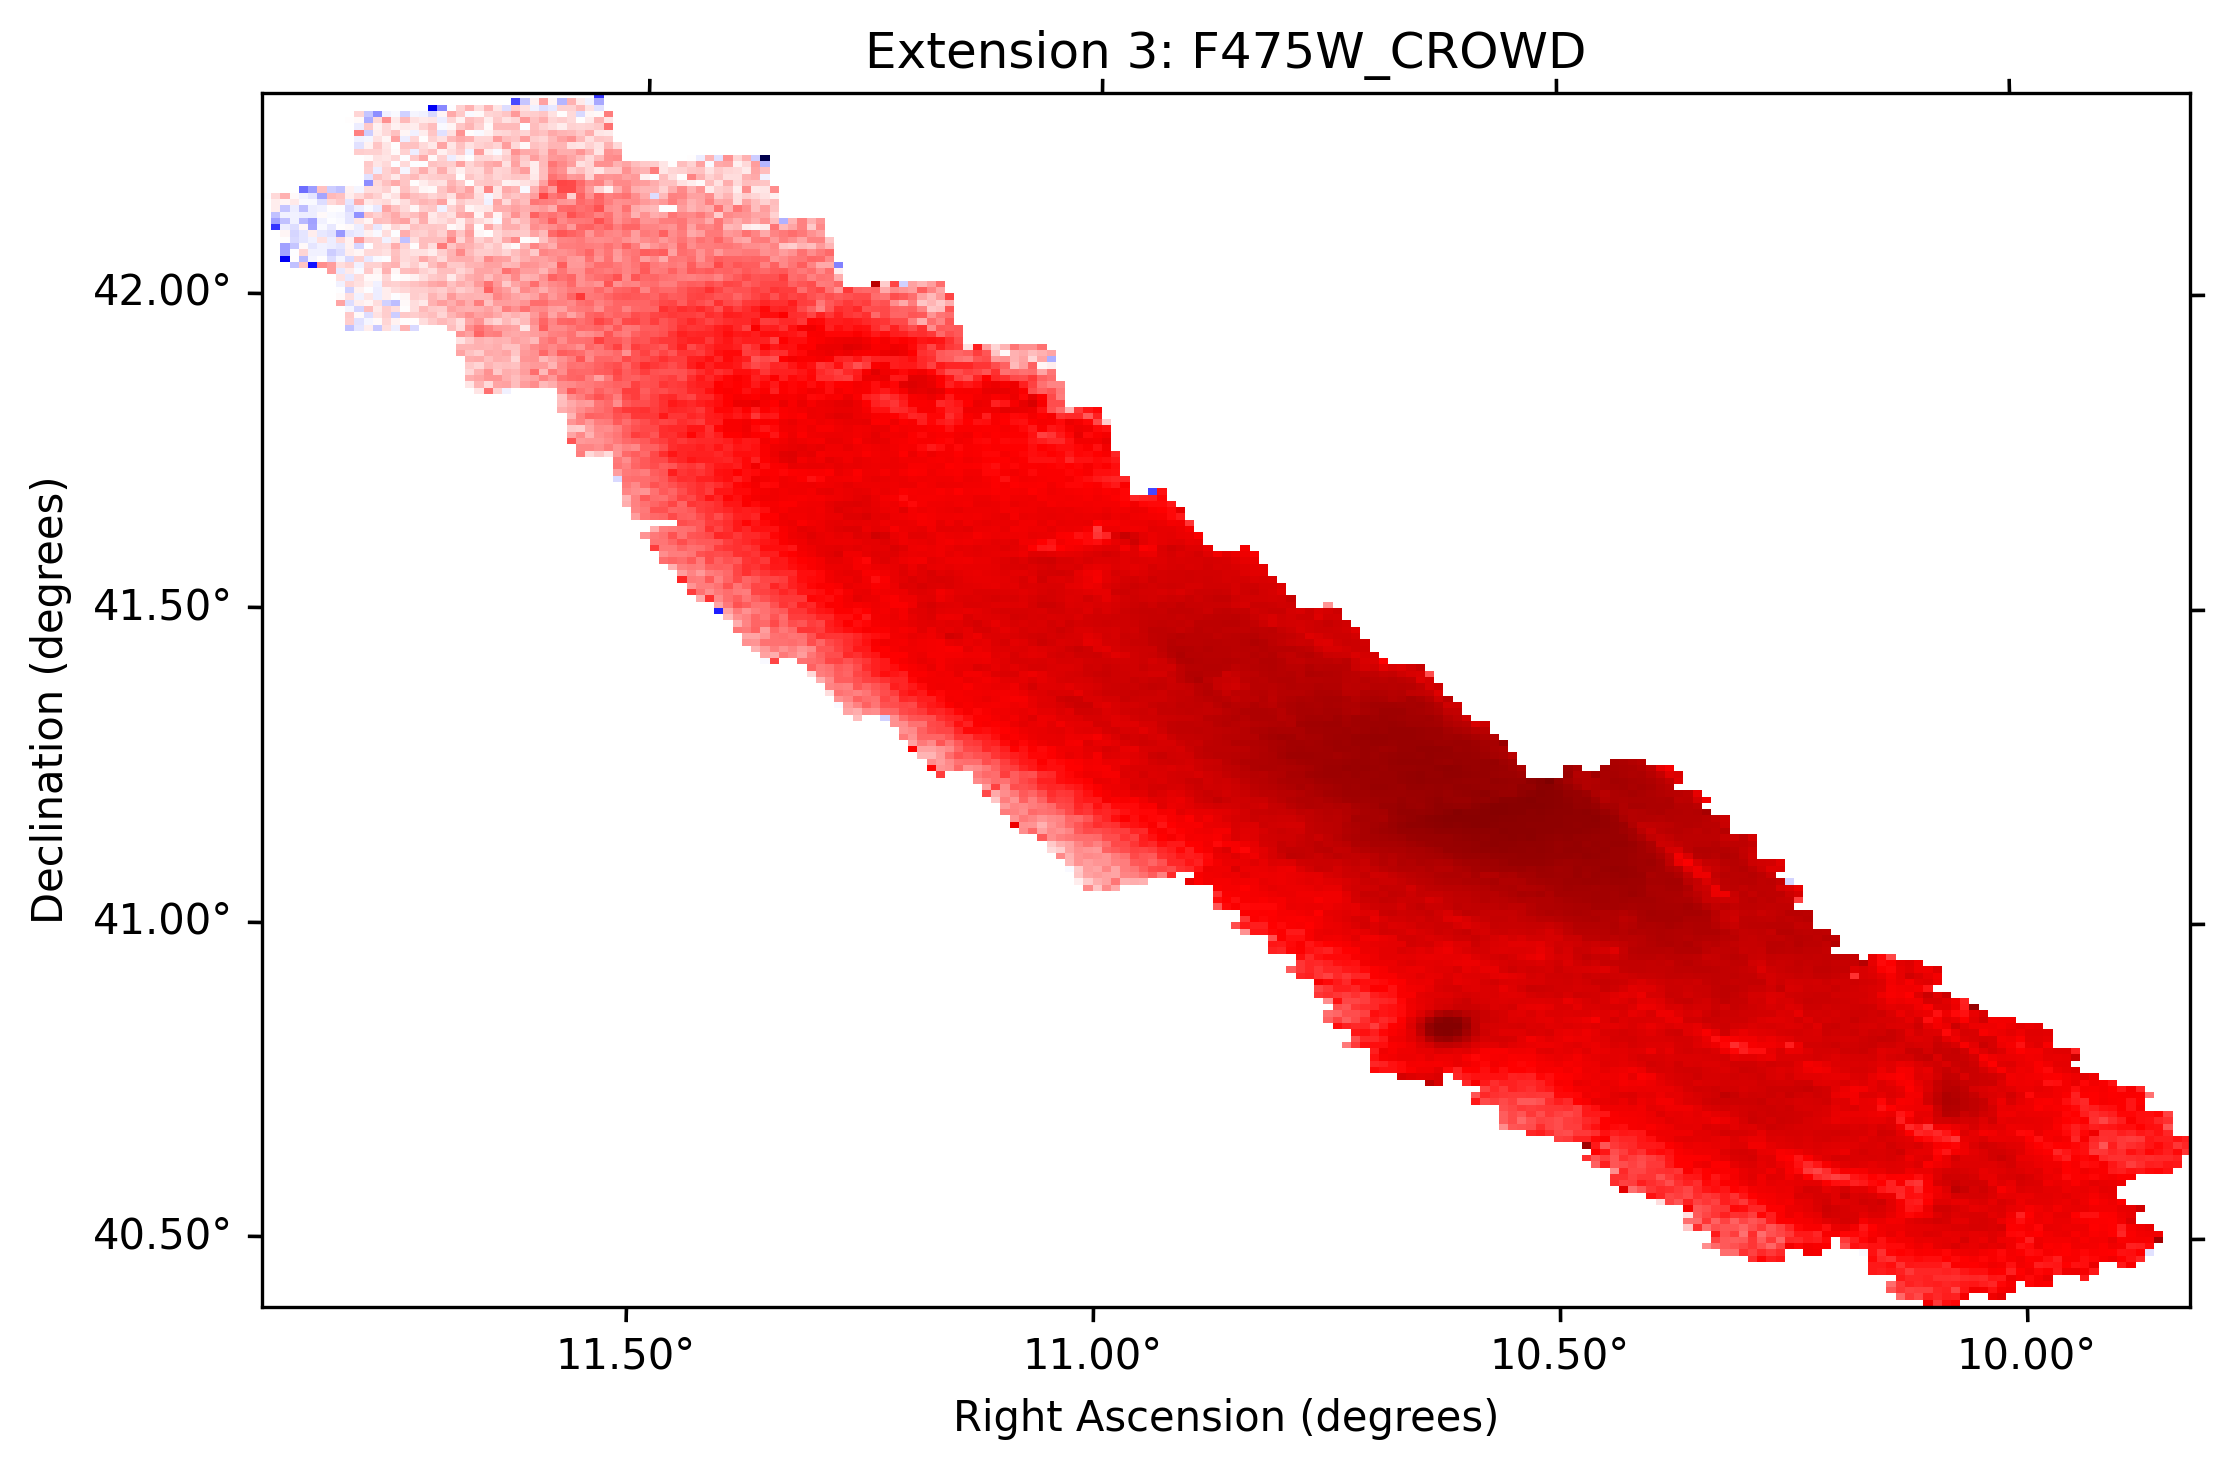

Extension 4: Data transposed and updated in FITS file
Extension 4: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


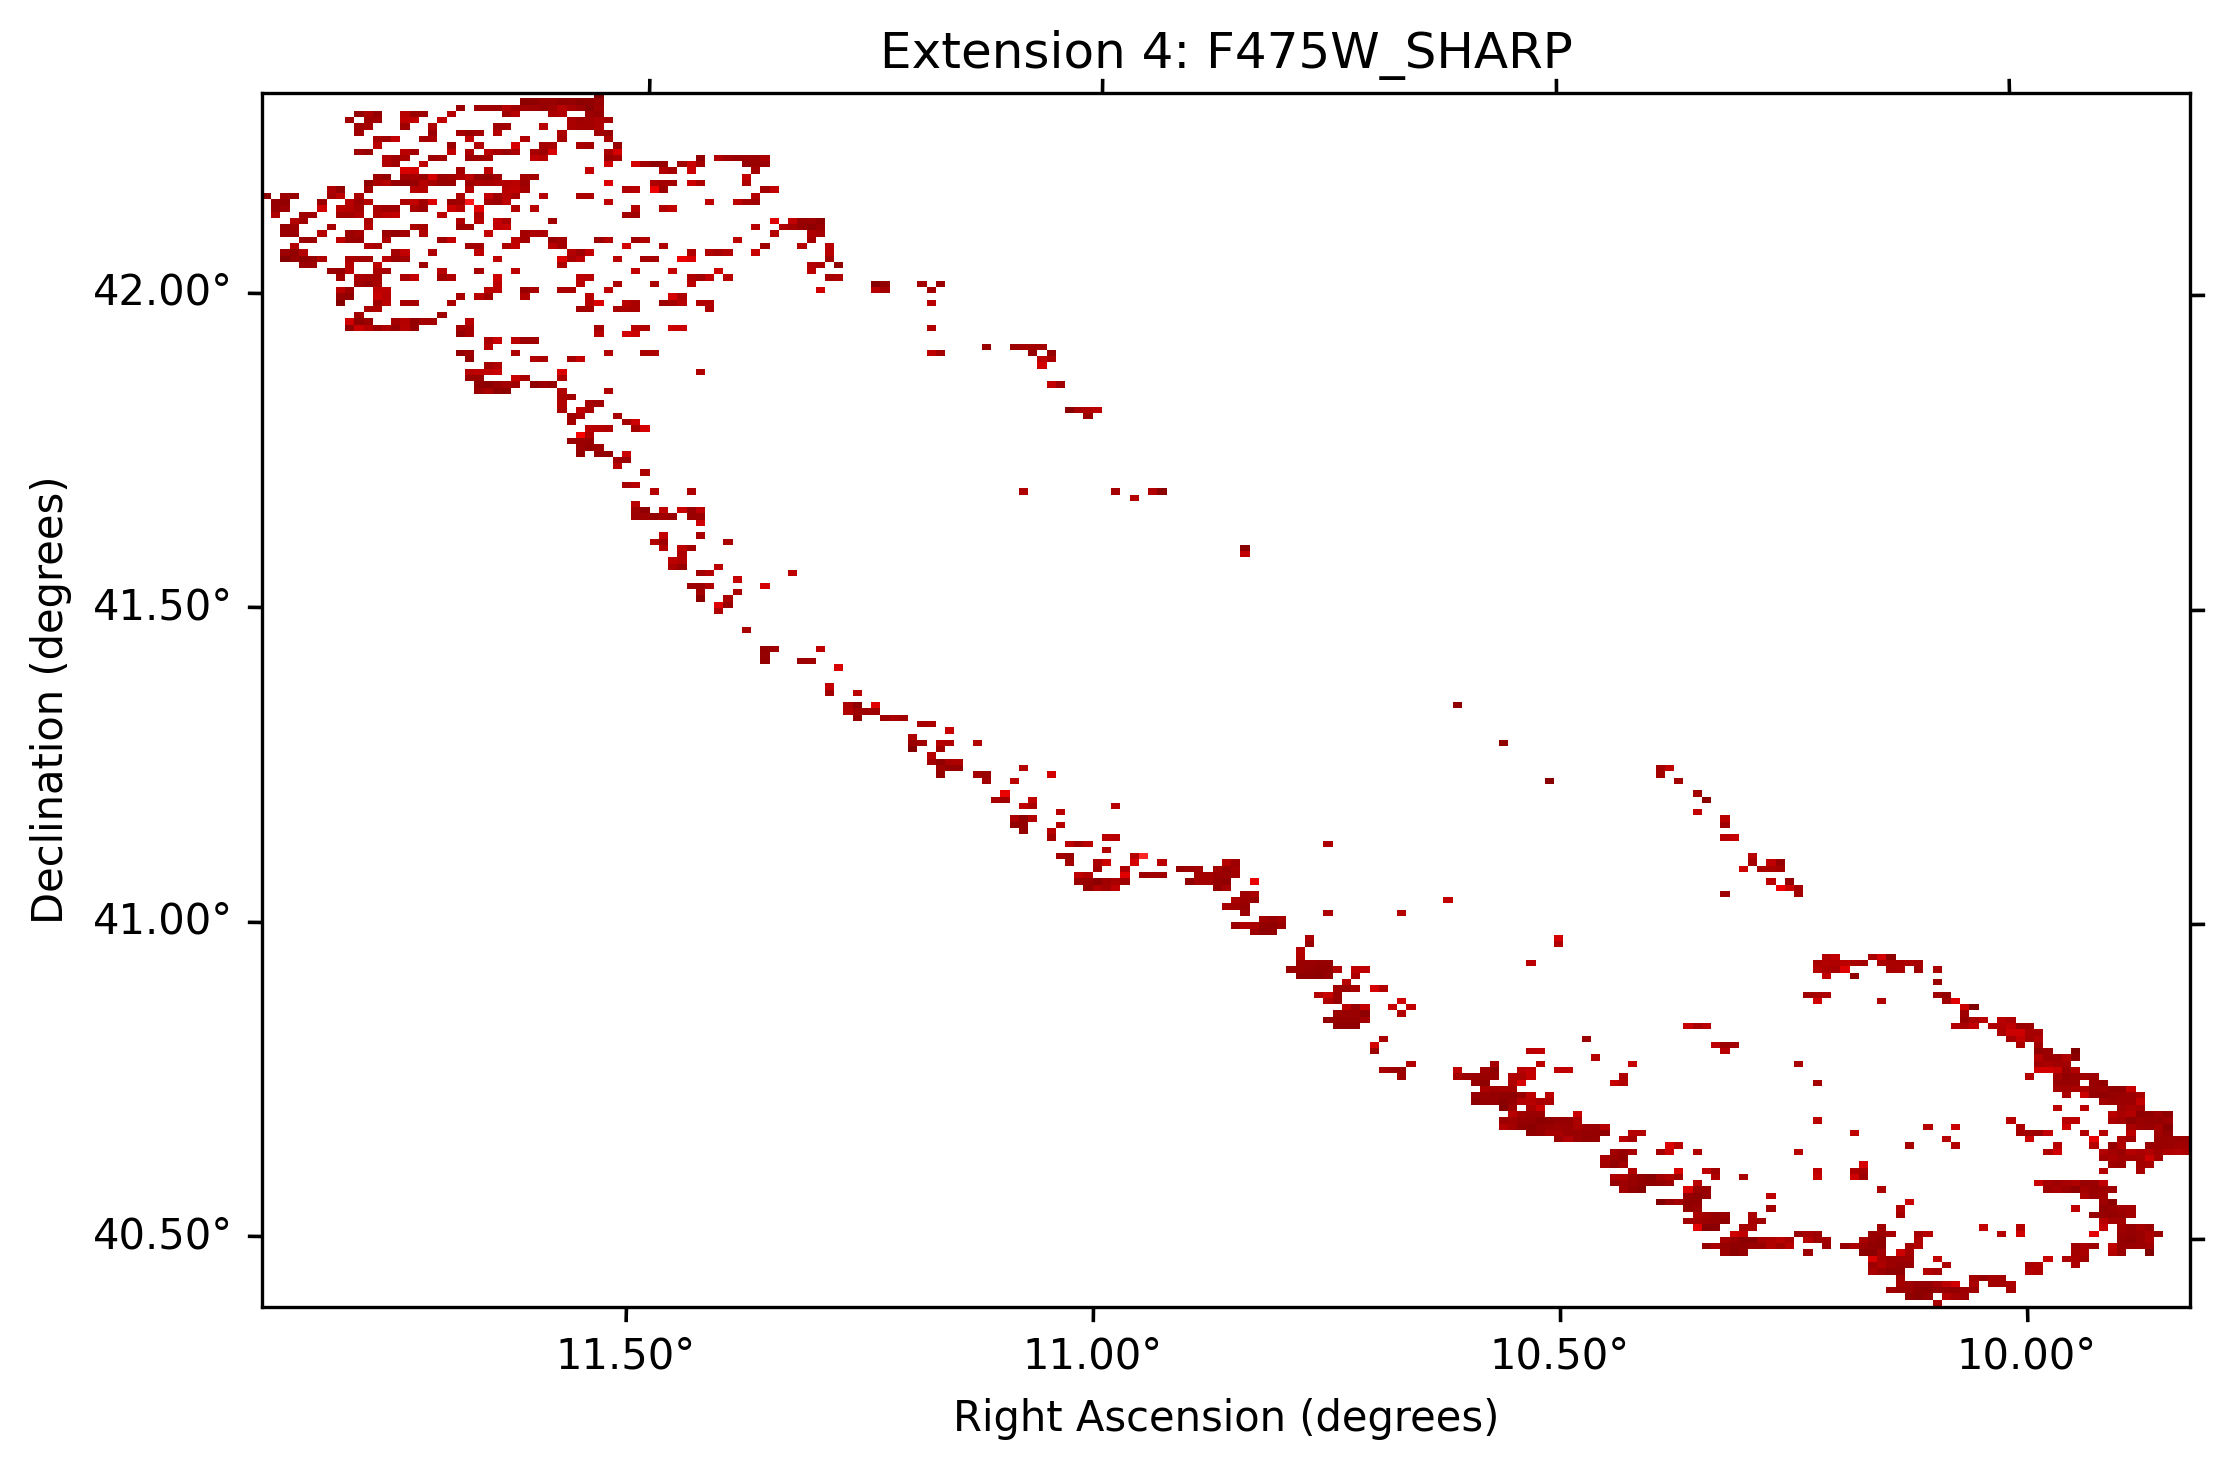

Extension 5: Data transposed and updated in FITS file
Extension 5: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


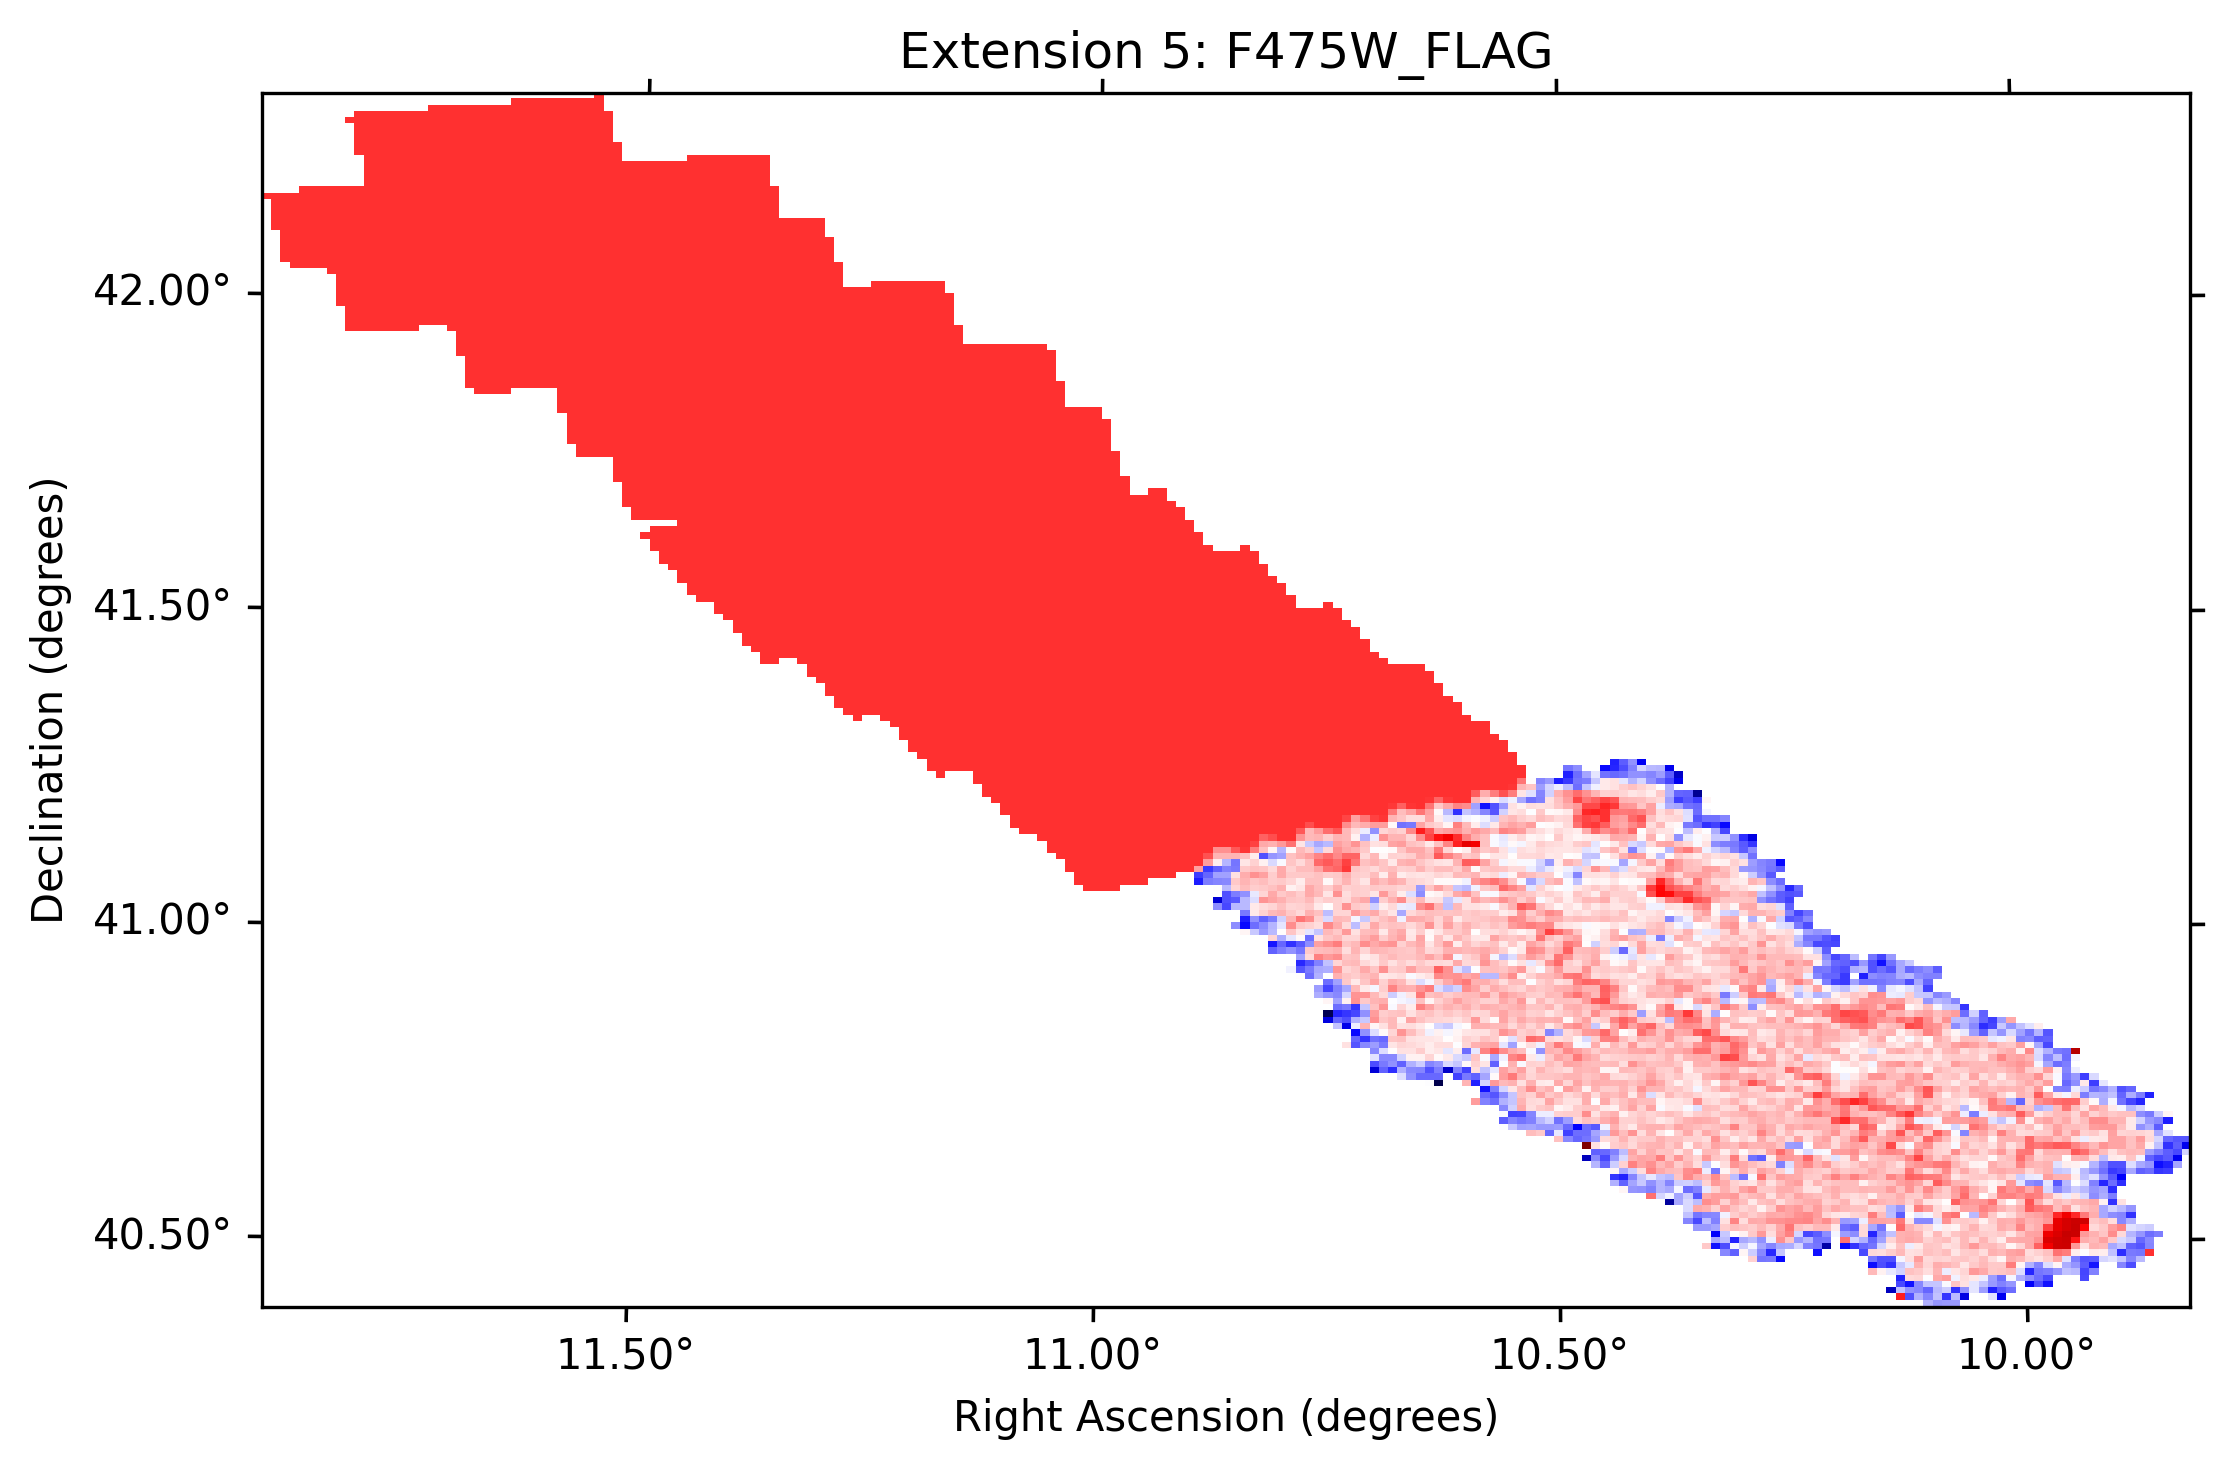

Extension 6: Data transposed and updated in FITS file
Extension 6: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


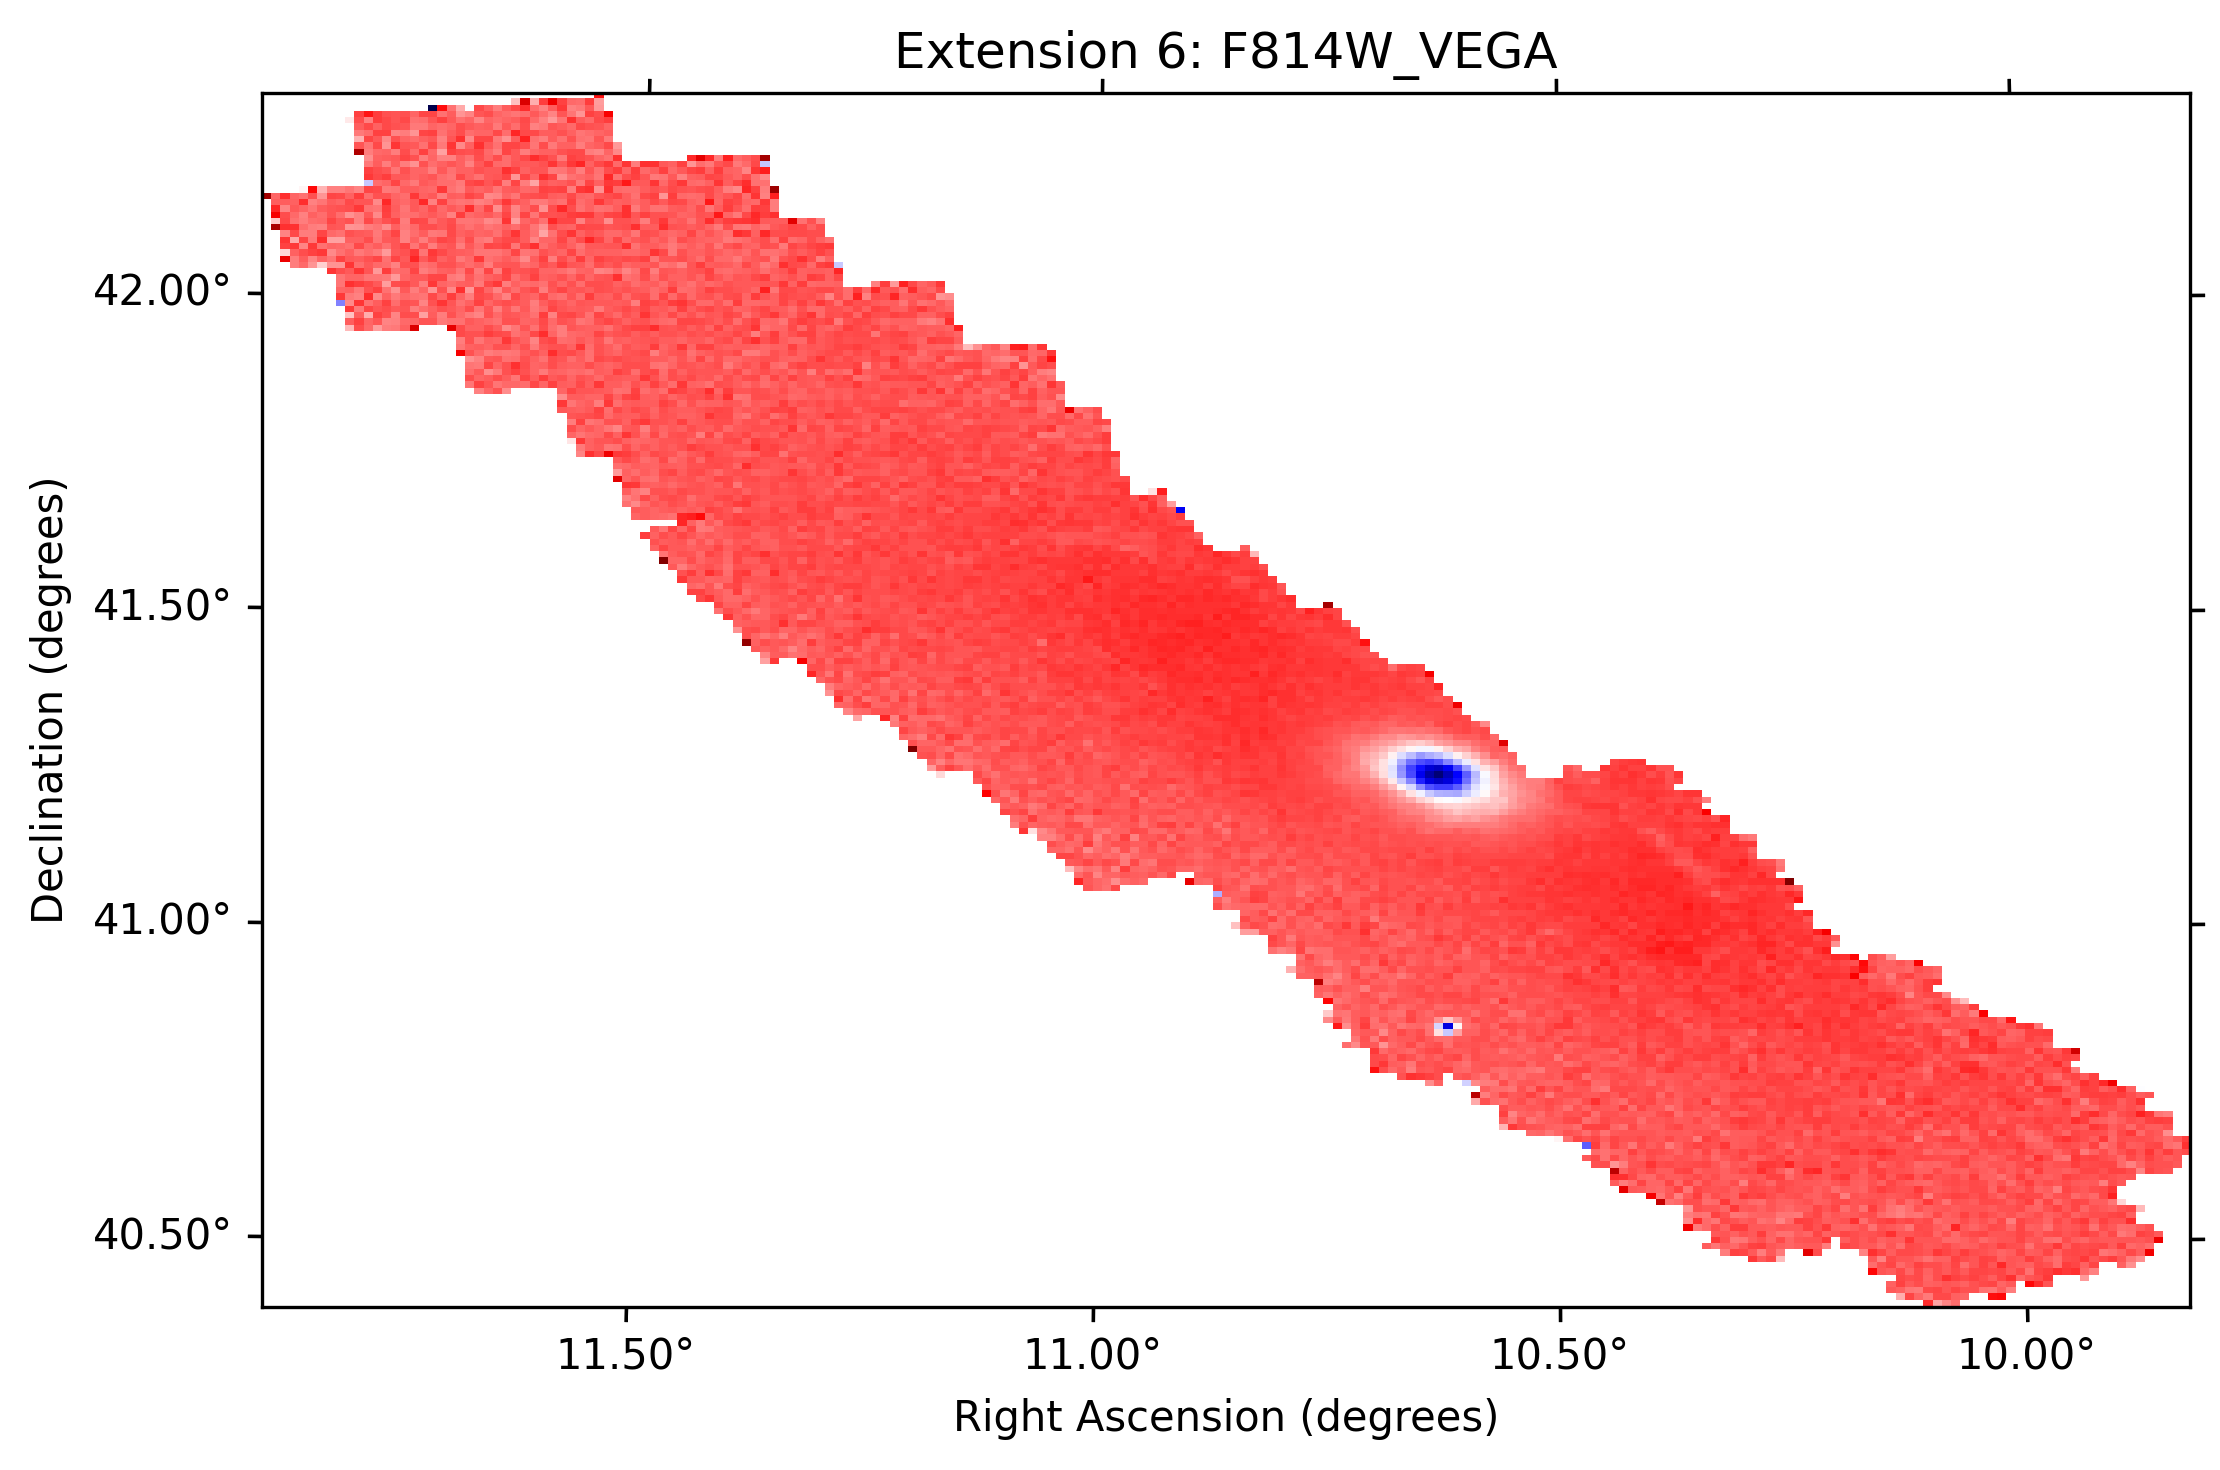

Extension 7: Data transposed and updated in FITS file
Extension 7: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


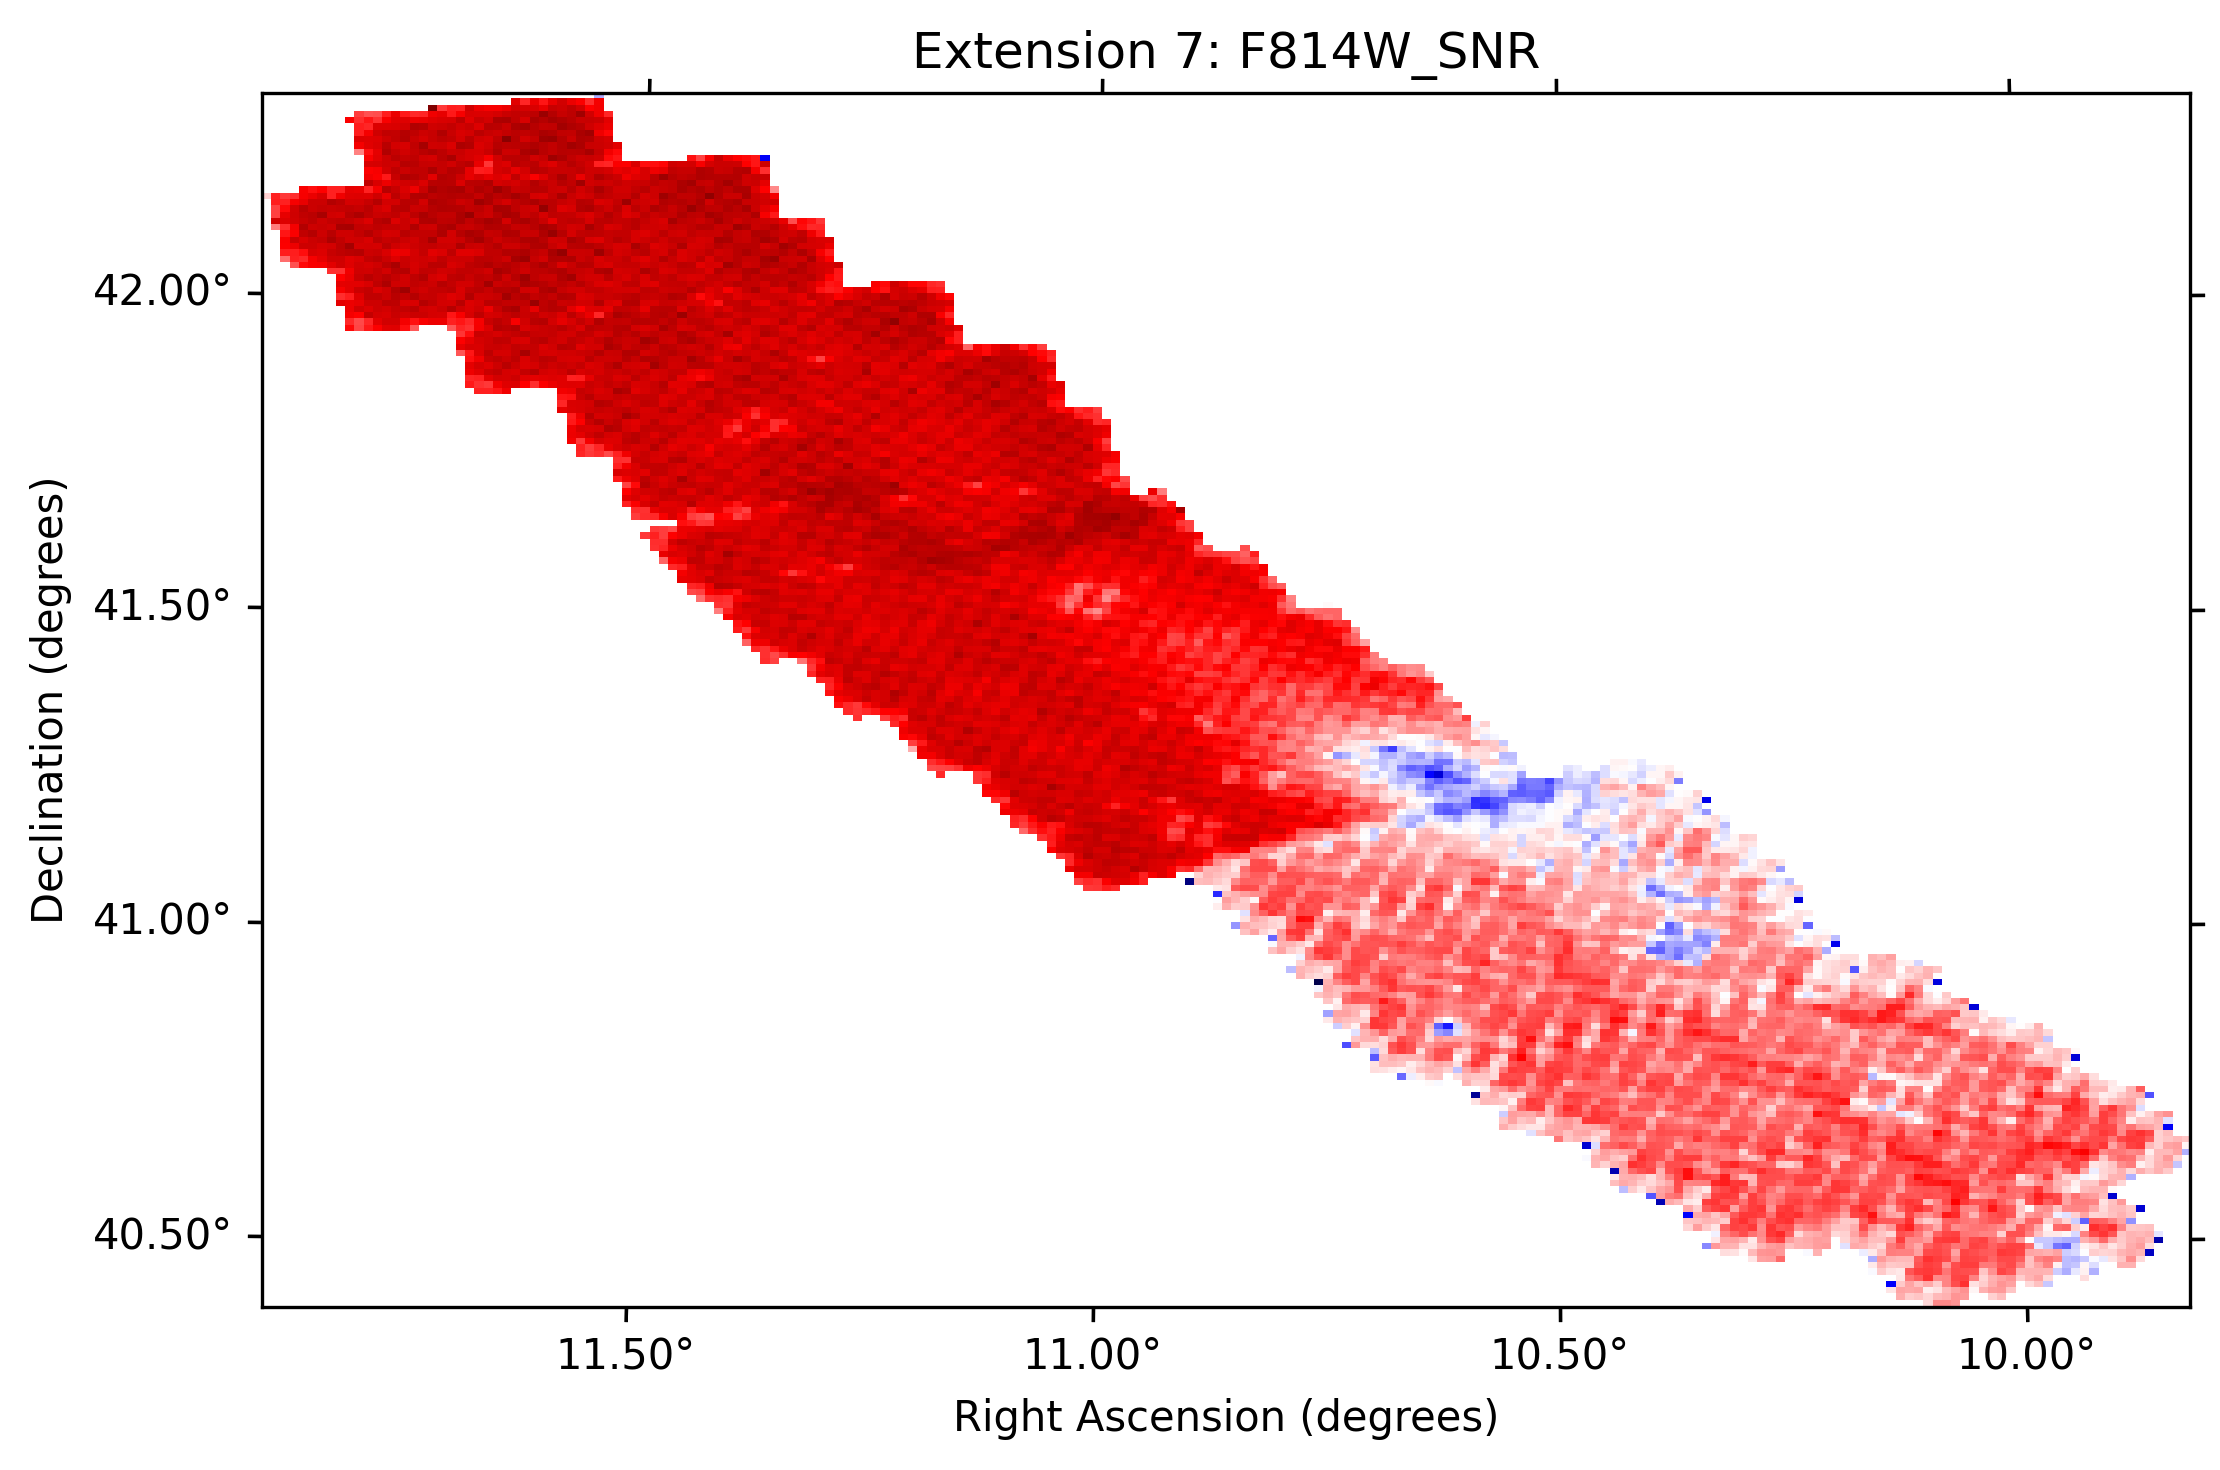

Extension 8: Data transposed and updated in FITS file
Extension 8: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


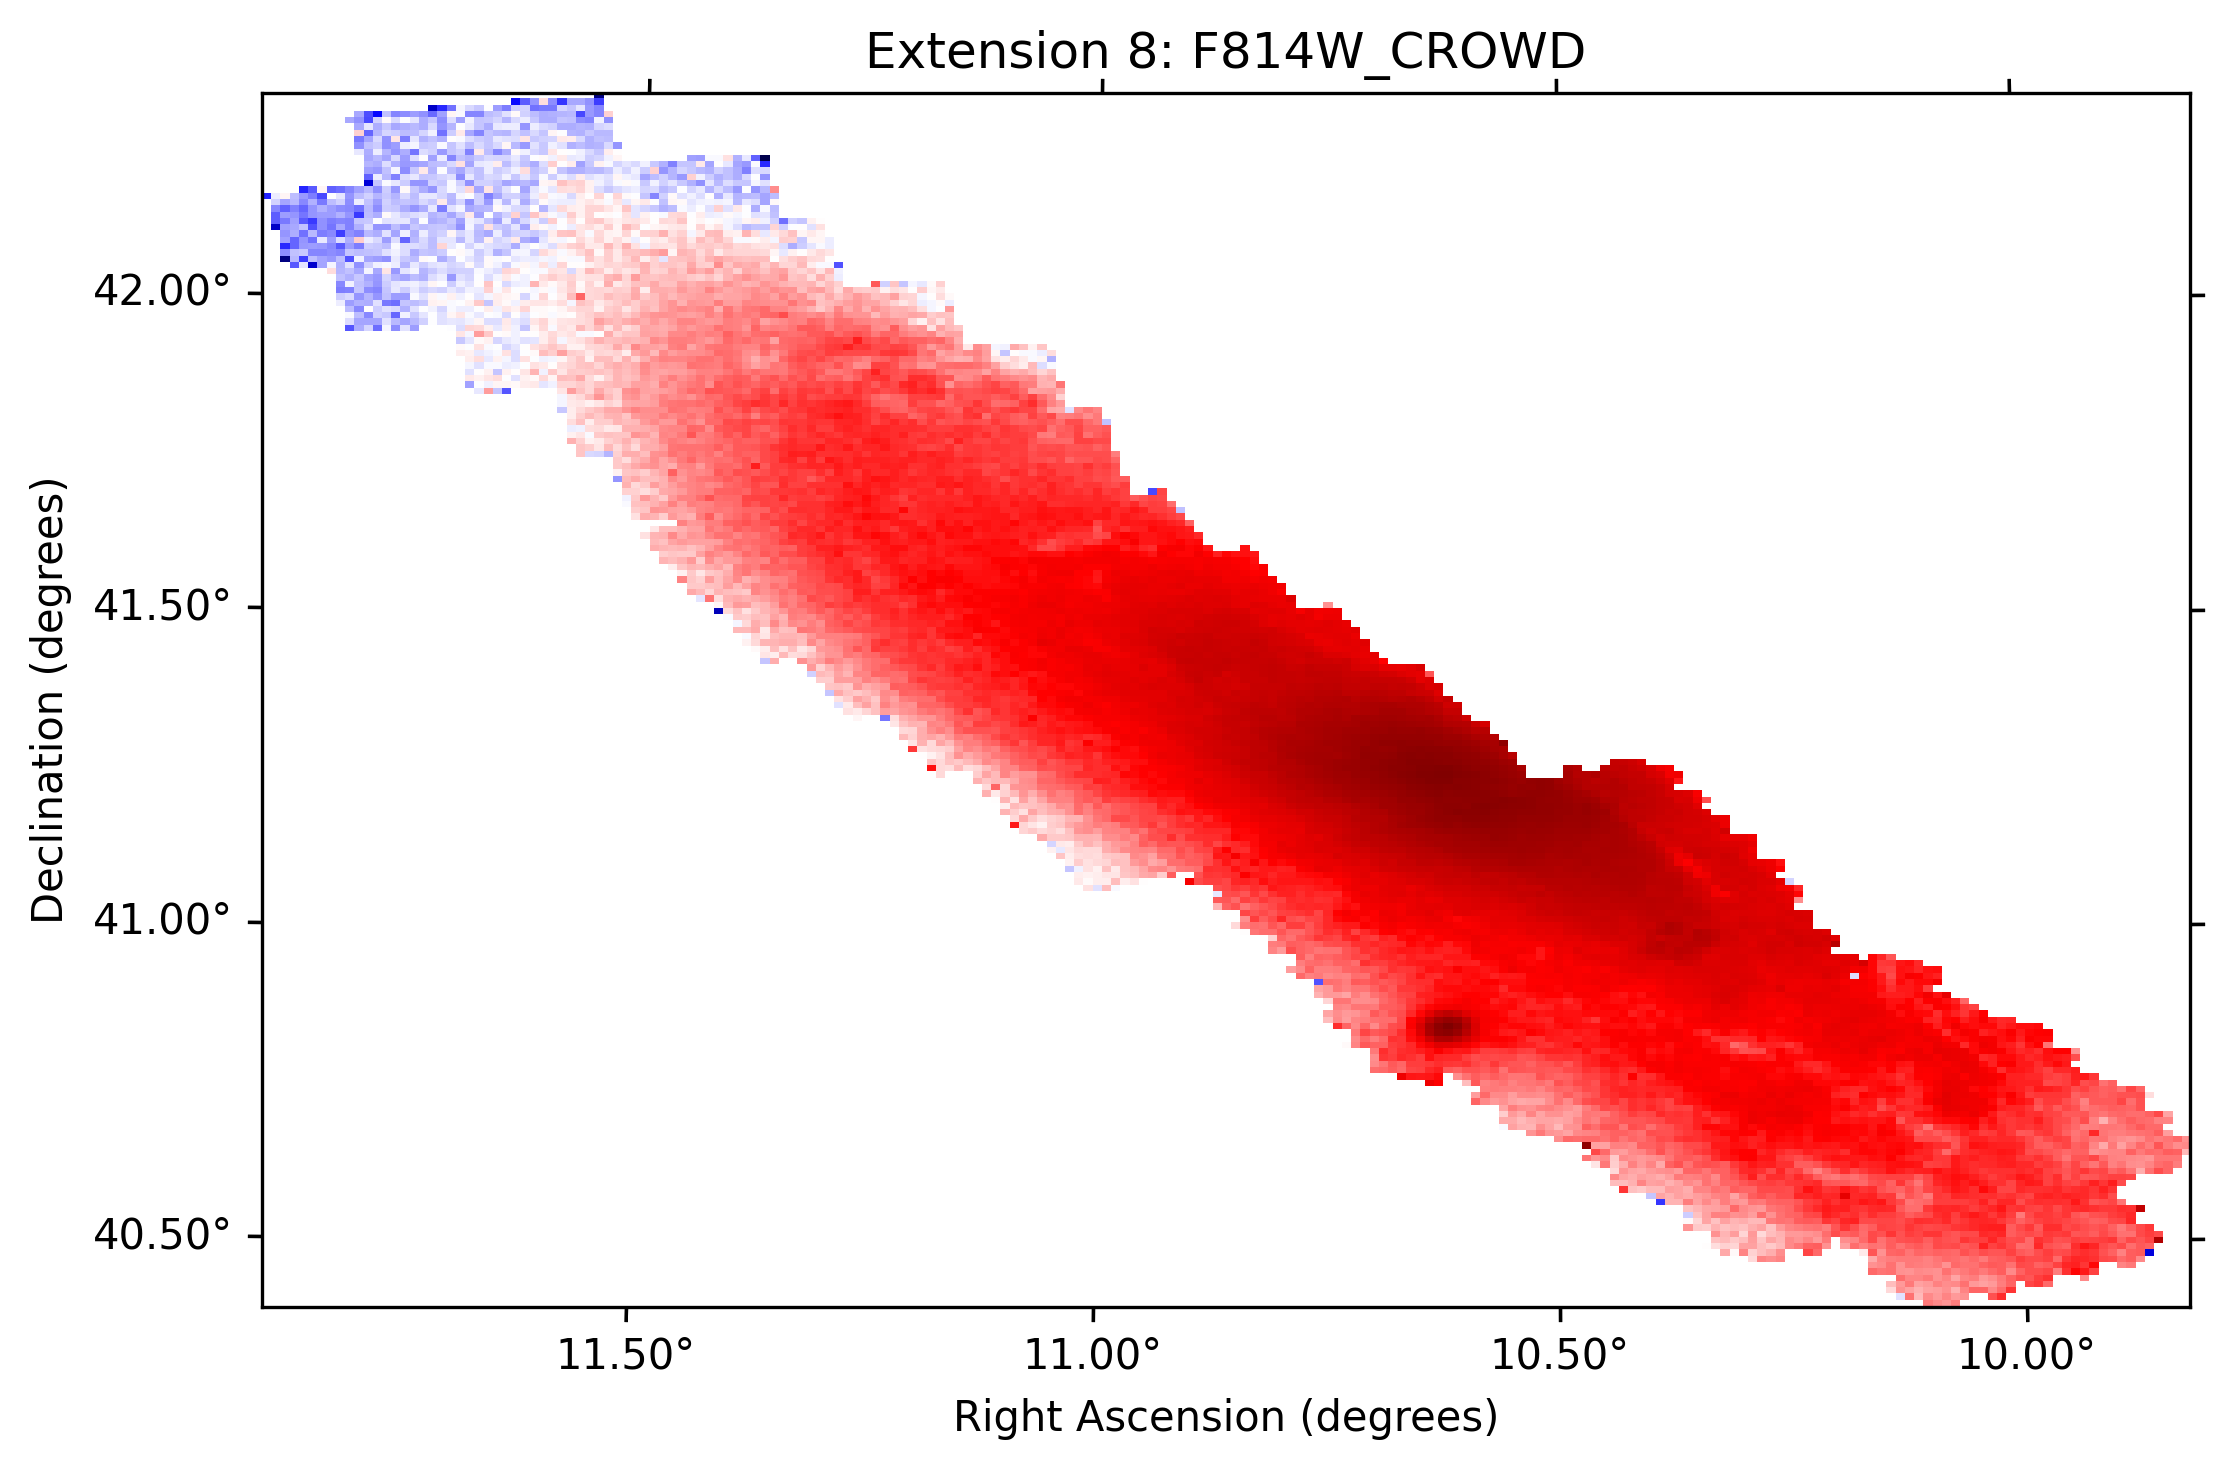

Extension 9: Data transposed and updated in FITS file
Extension 9: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


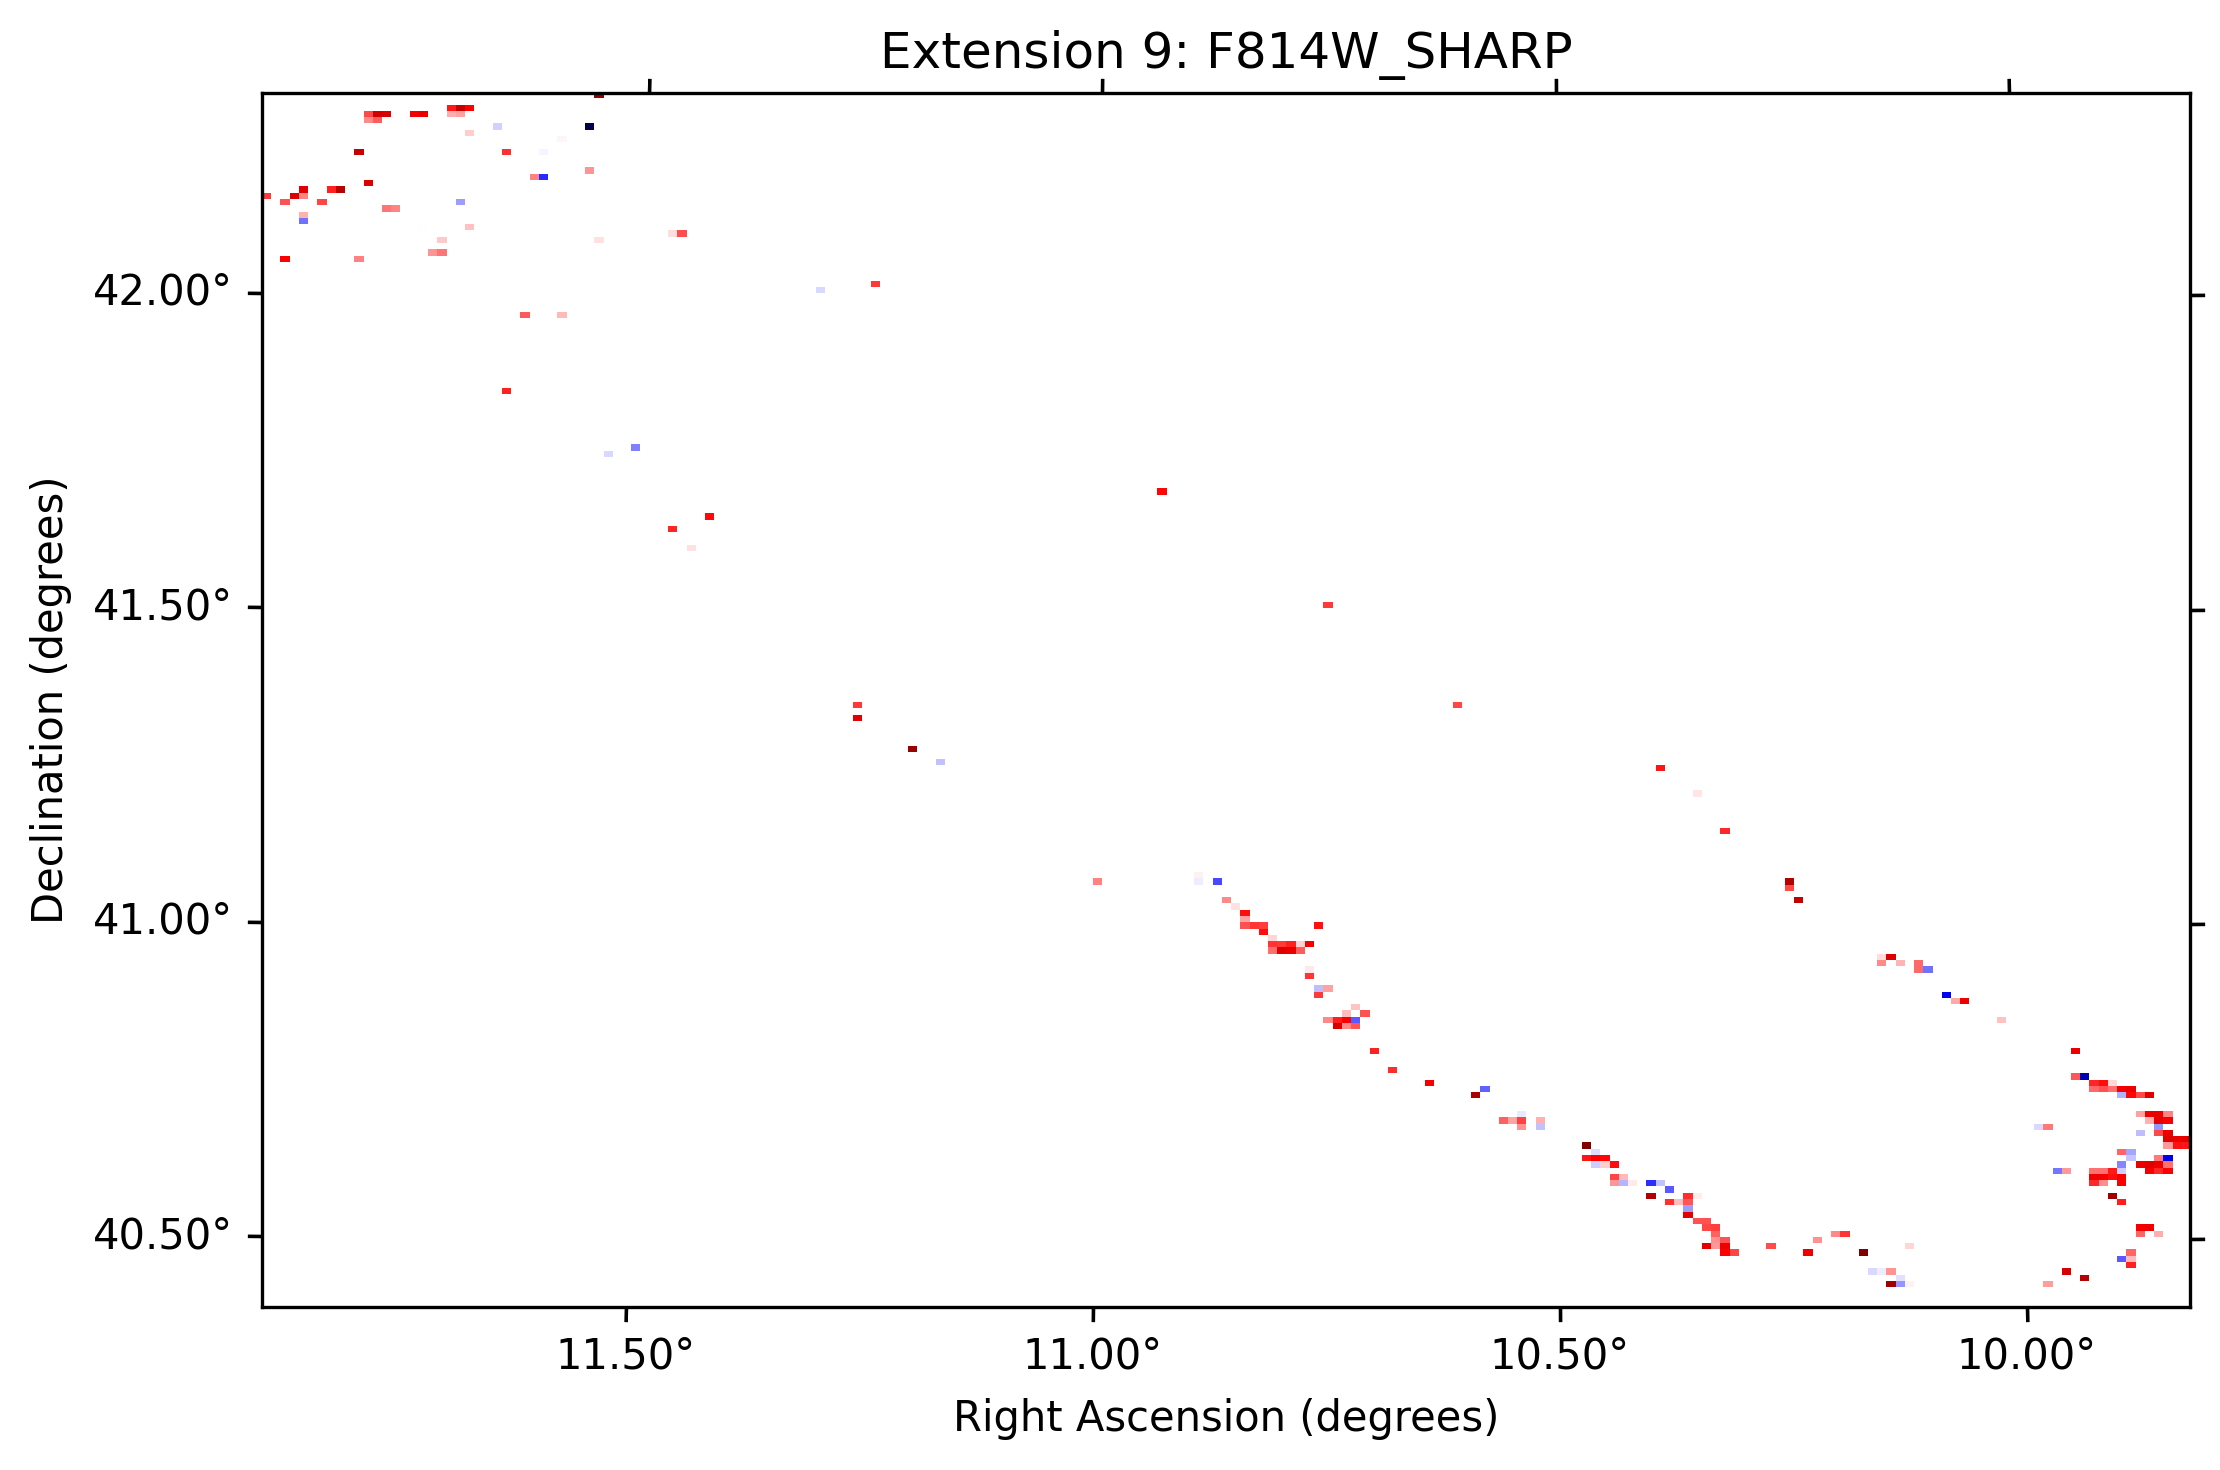

Extension 10: Data transposed and updated in FITS file
Extension 10: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


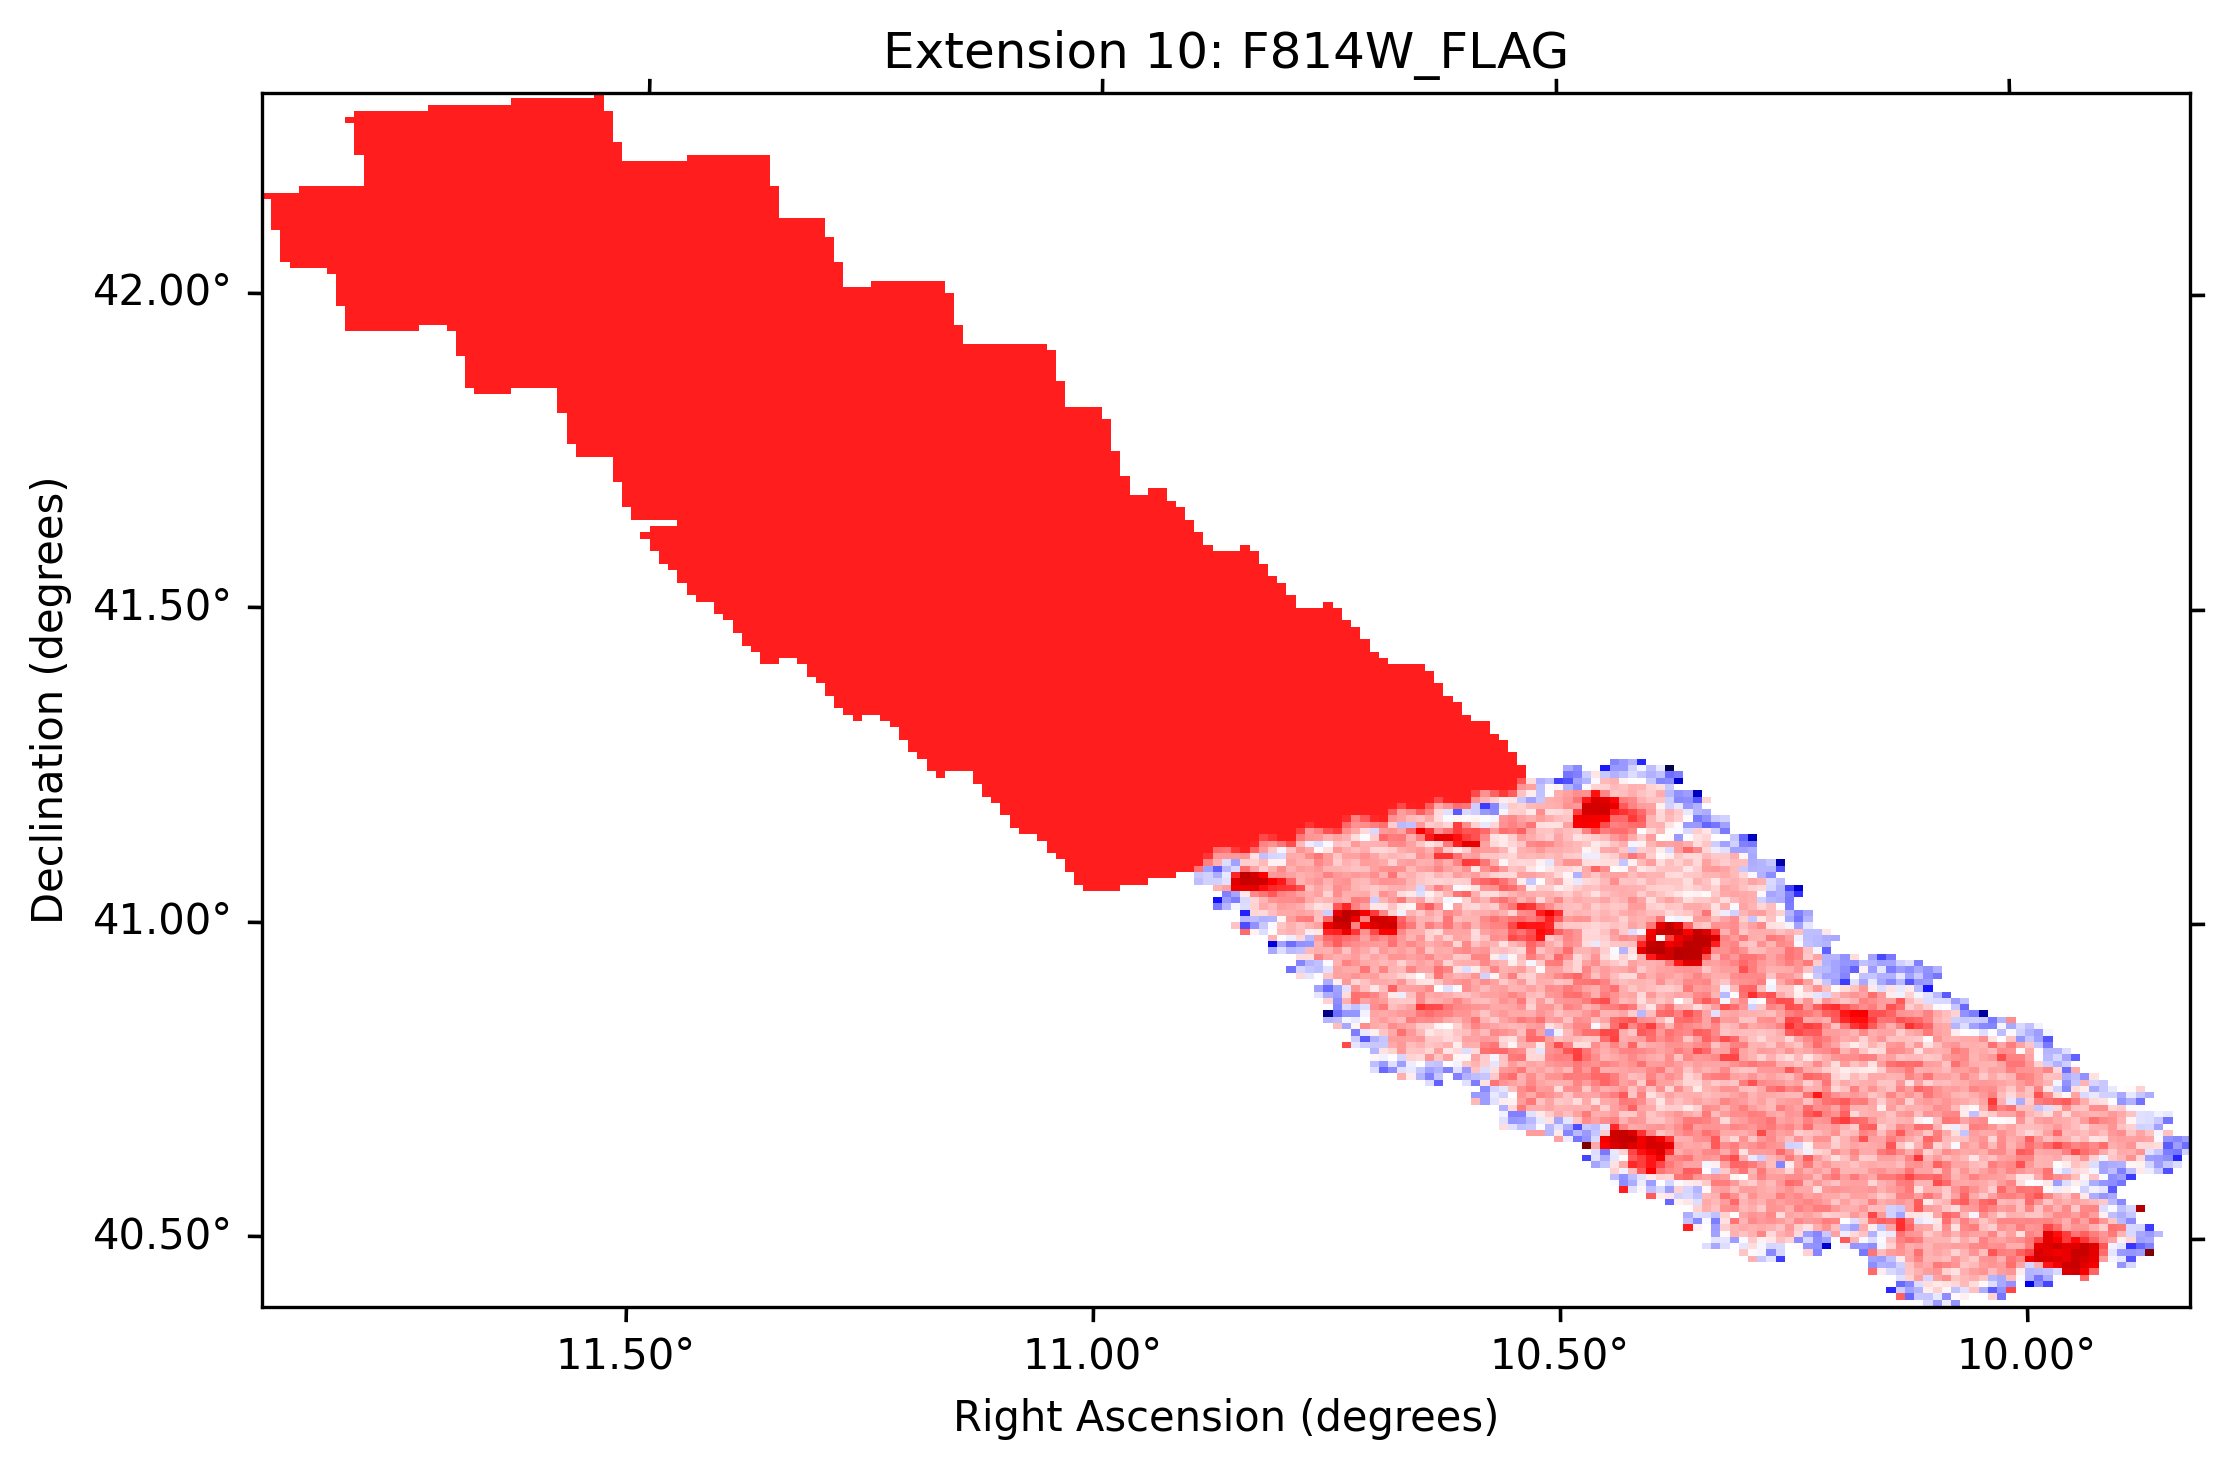

Extension 11: Data transposed and updated in FITS file
Extension 11: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


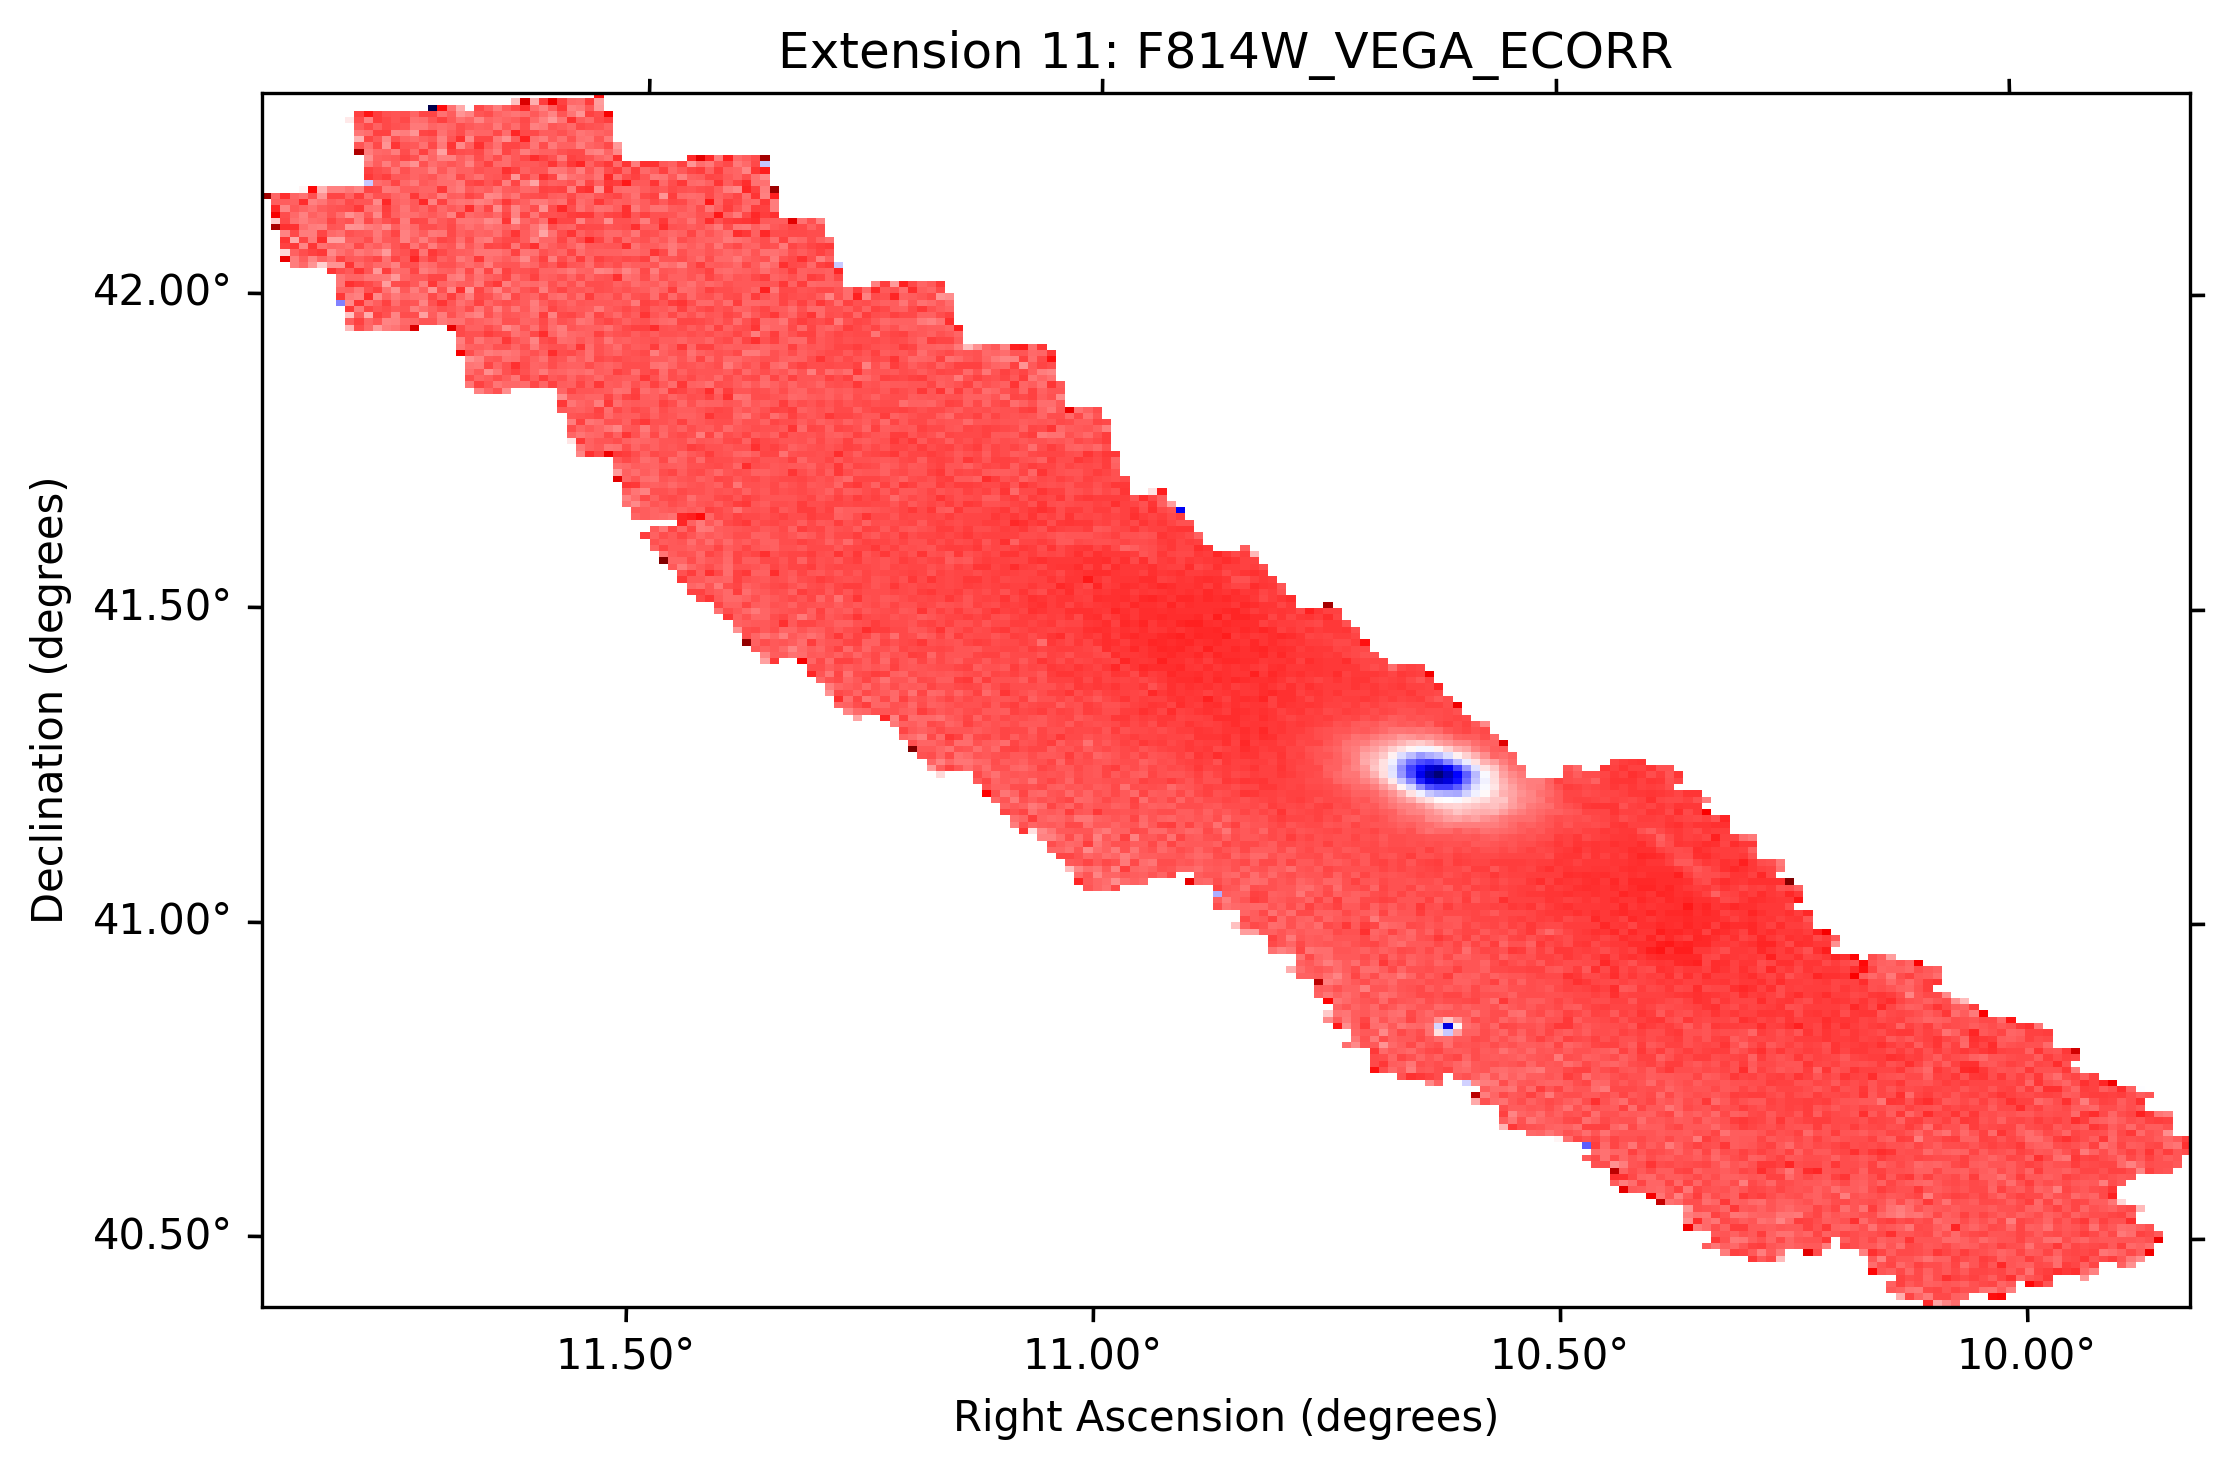

Extension 12: Data transposed and updated in FITS file
Extension 12: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


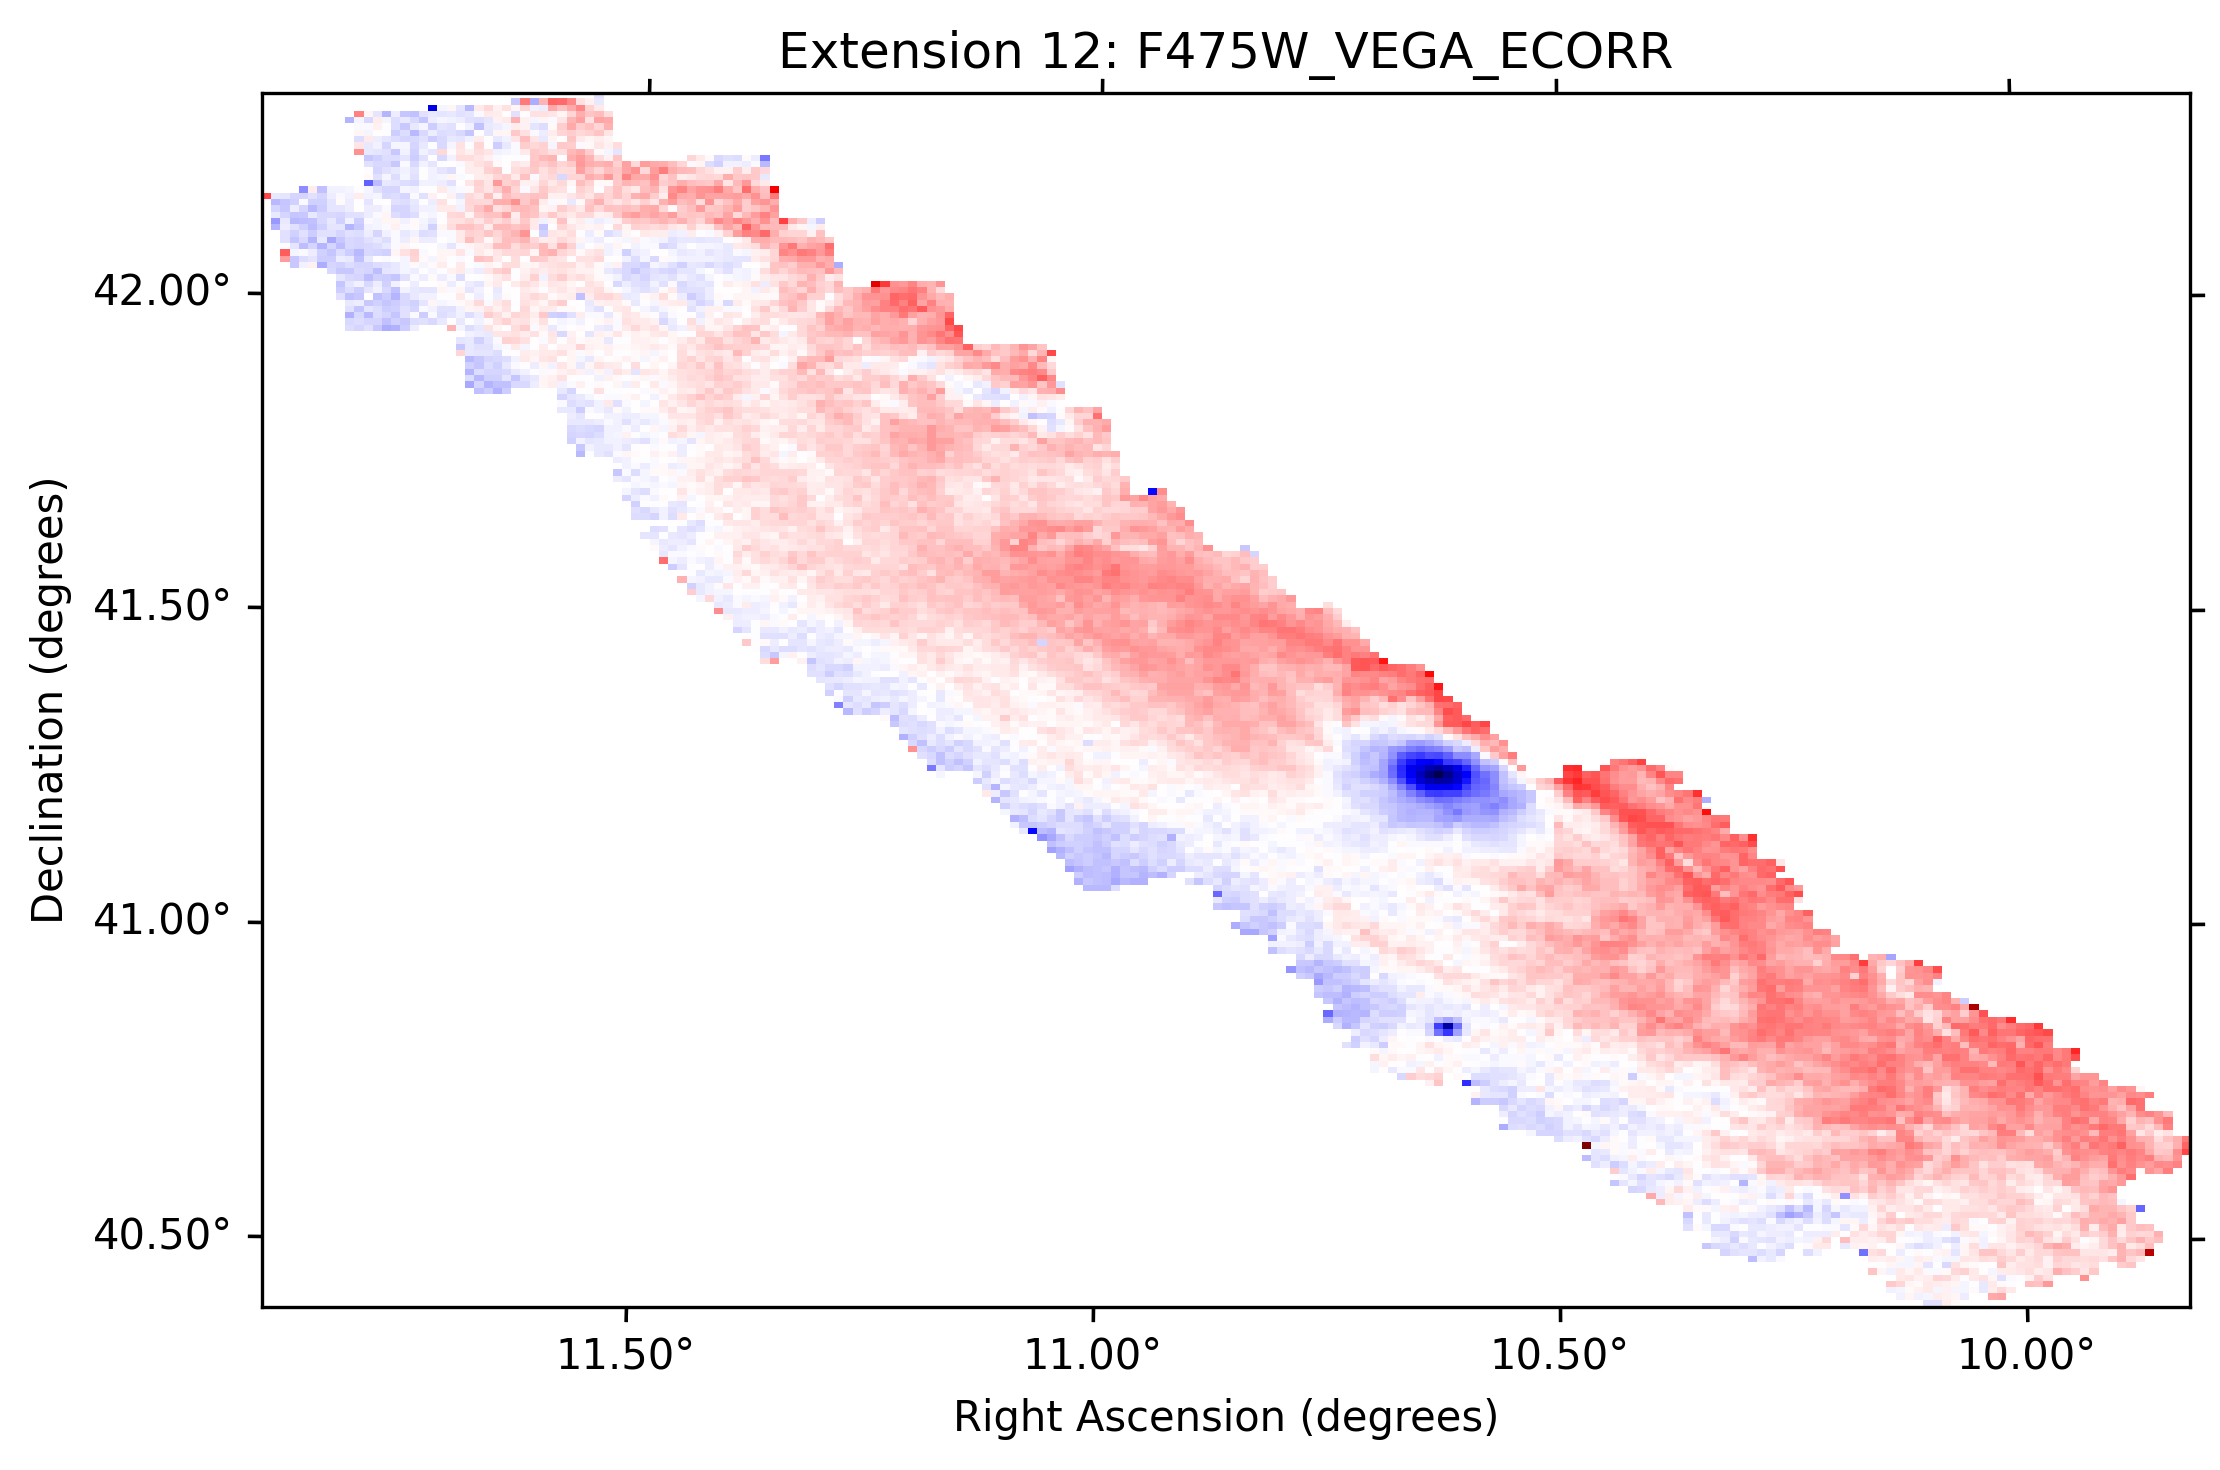

Extension 13: Data transposed and updated in FITS file
Extension 13: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


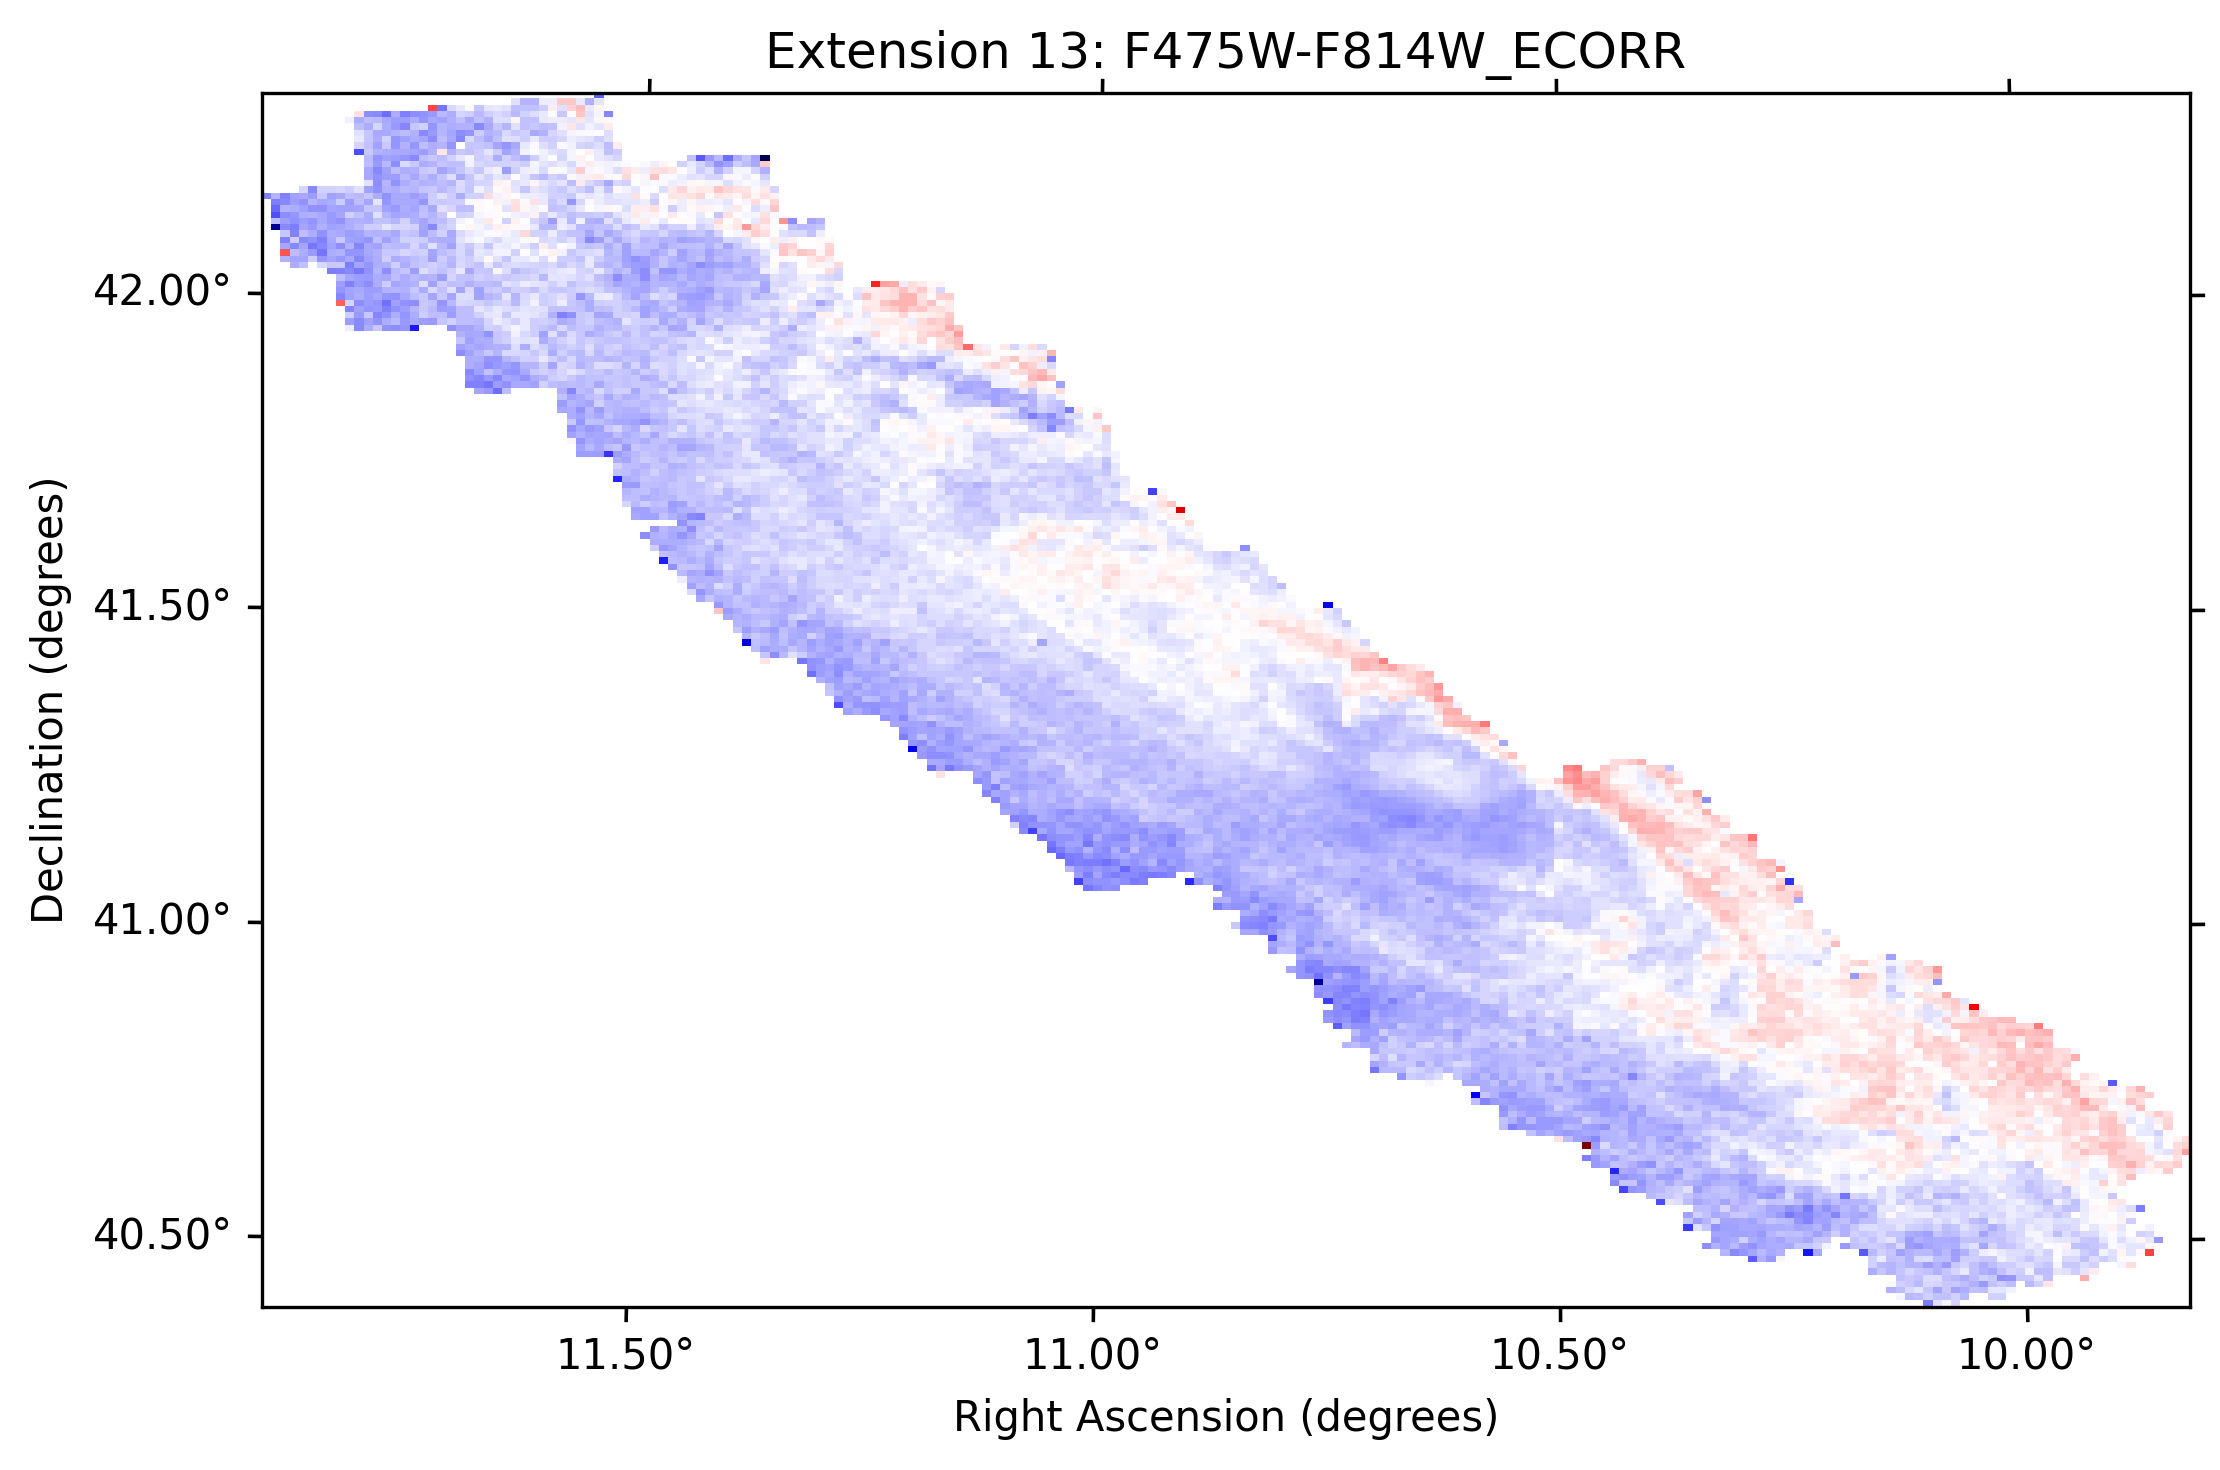

Extension 14: Data transposed and updated in FITS file
Extension 14: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


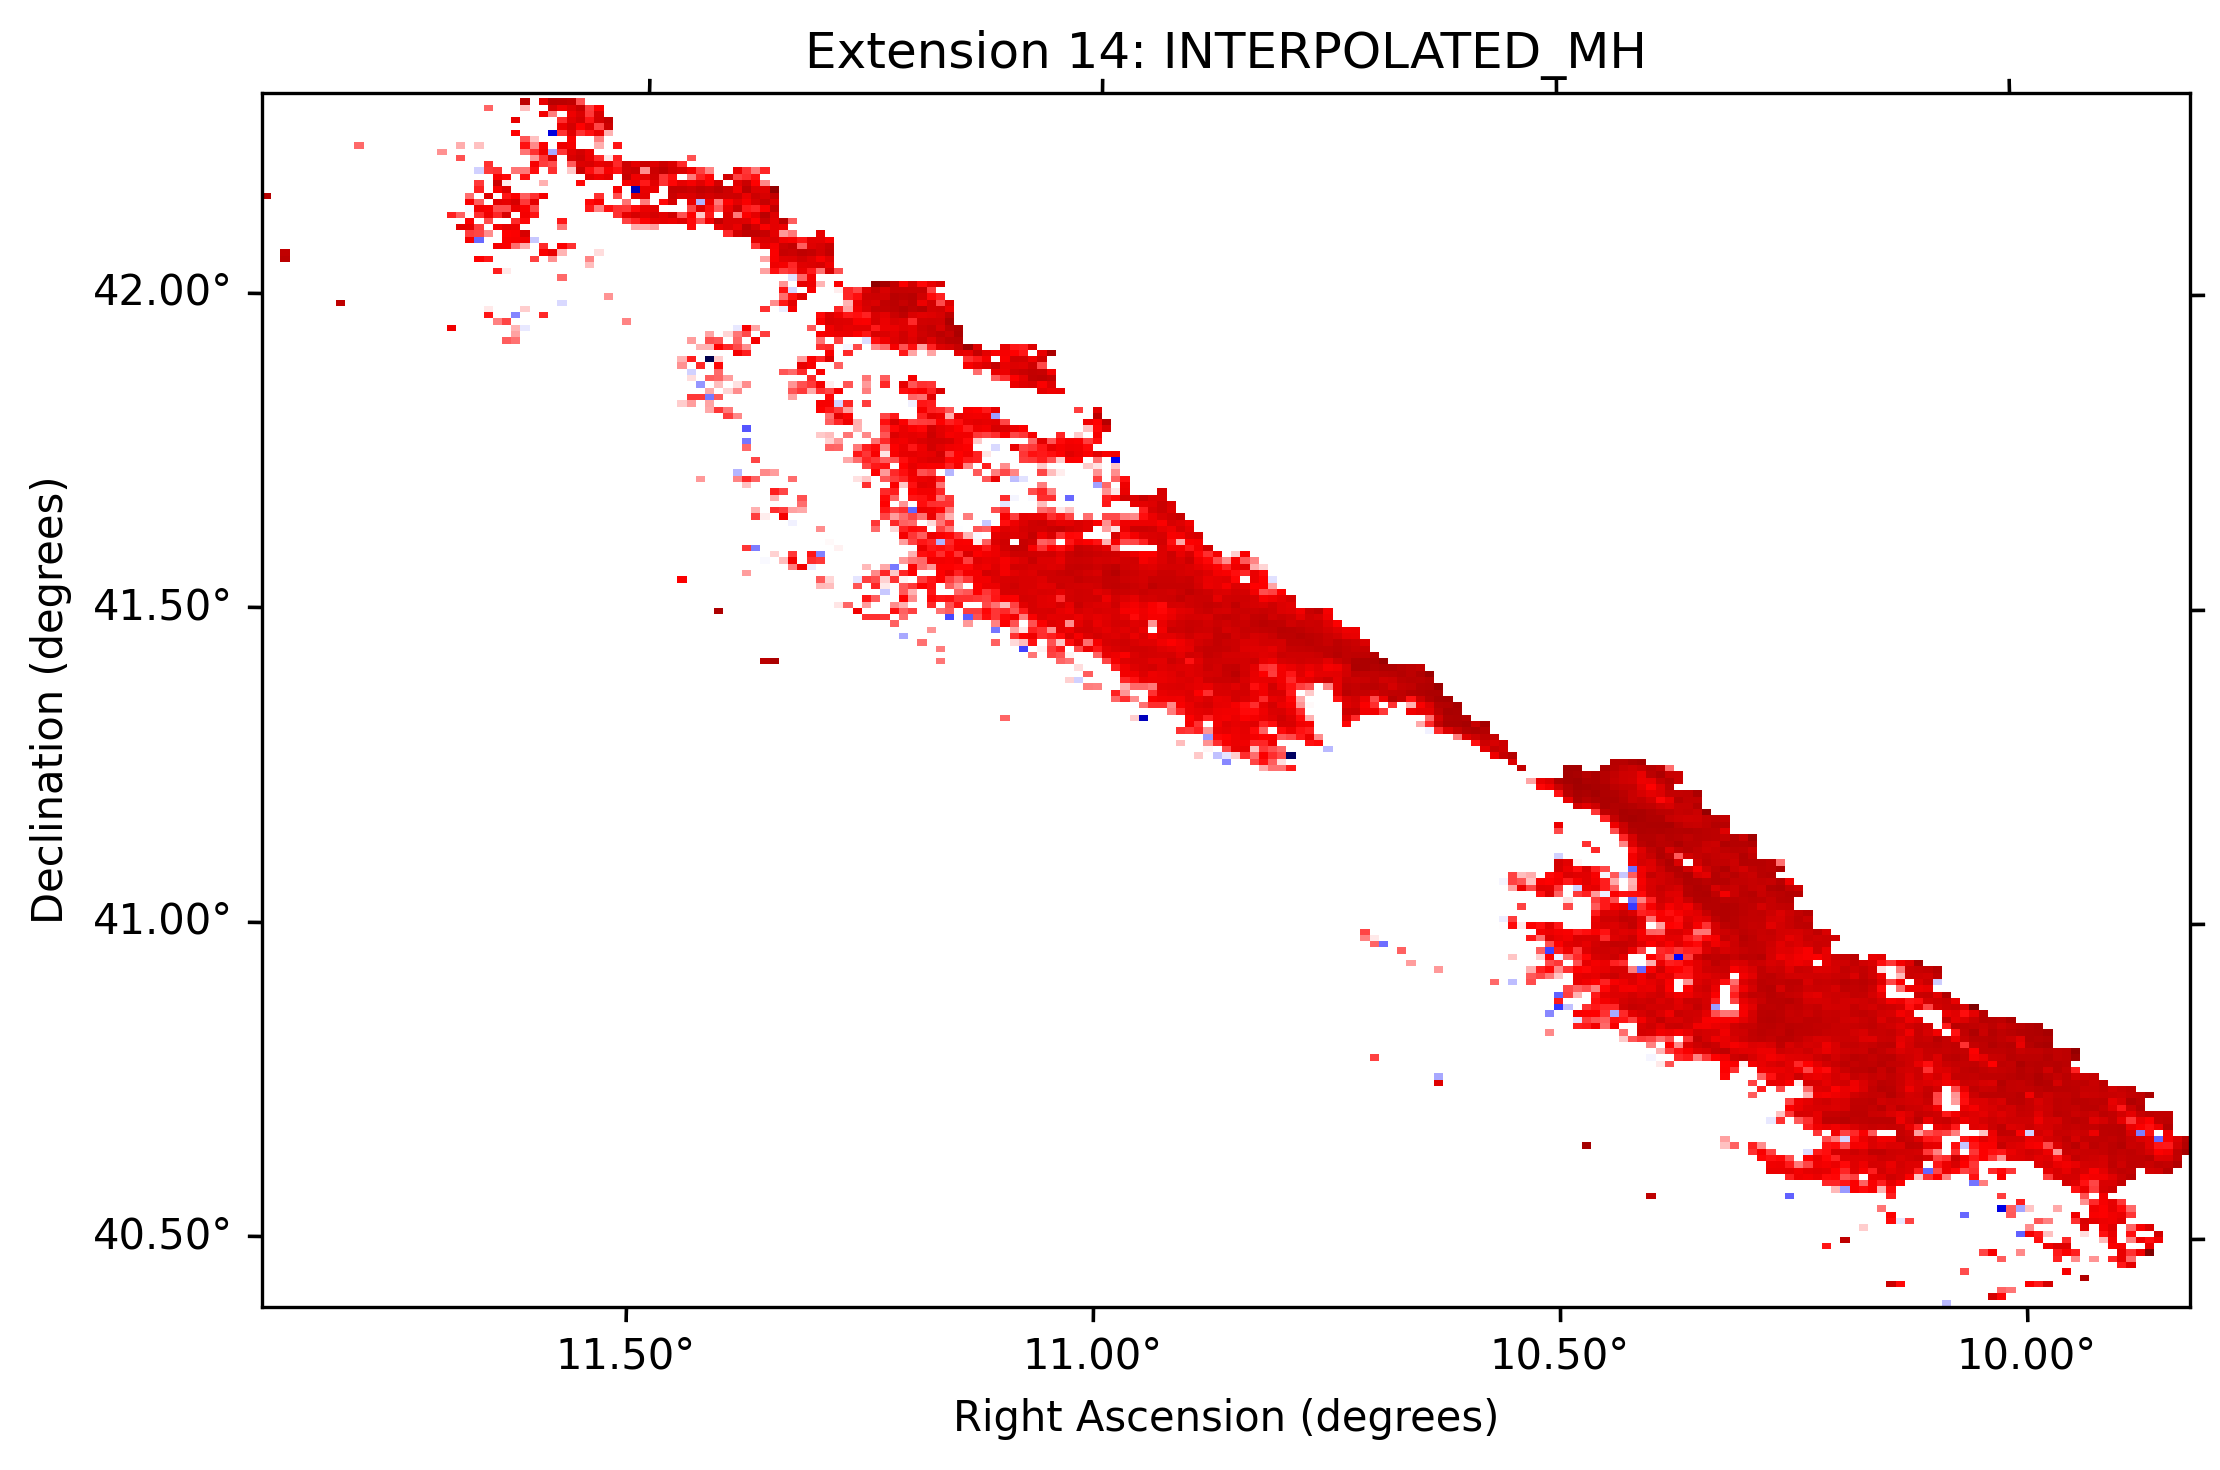

Extension 15: Data transposed and updated in FITS file
Extension 15: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


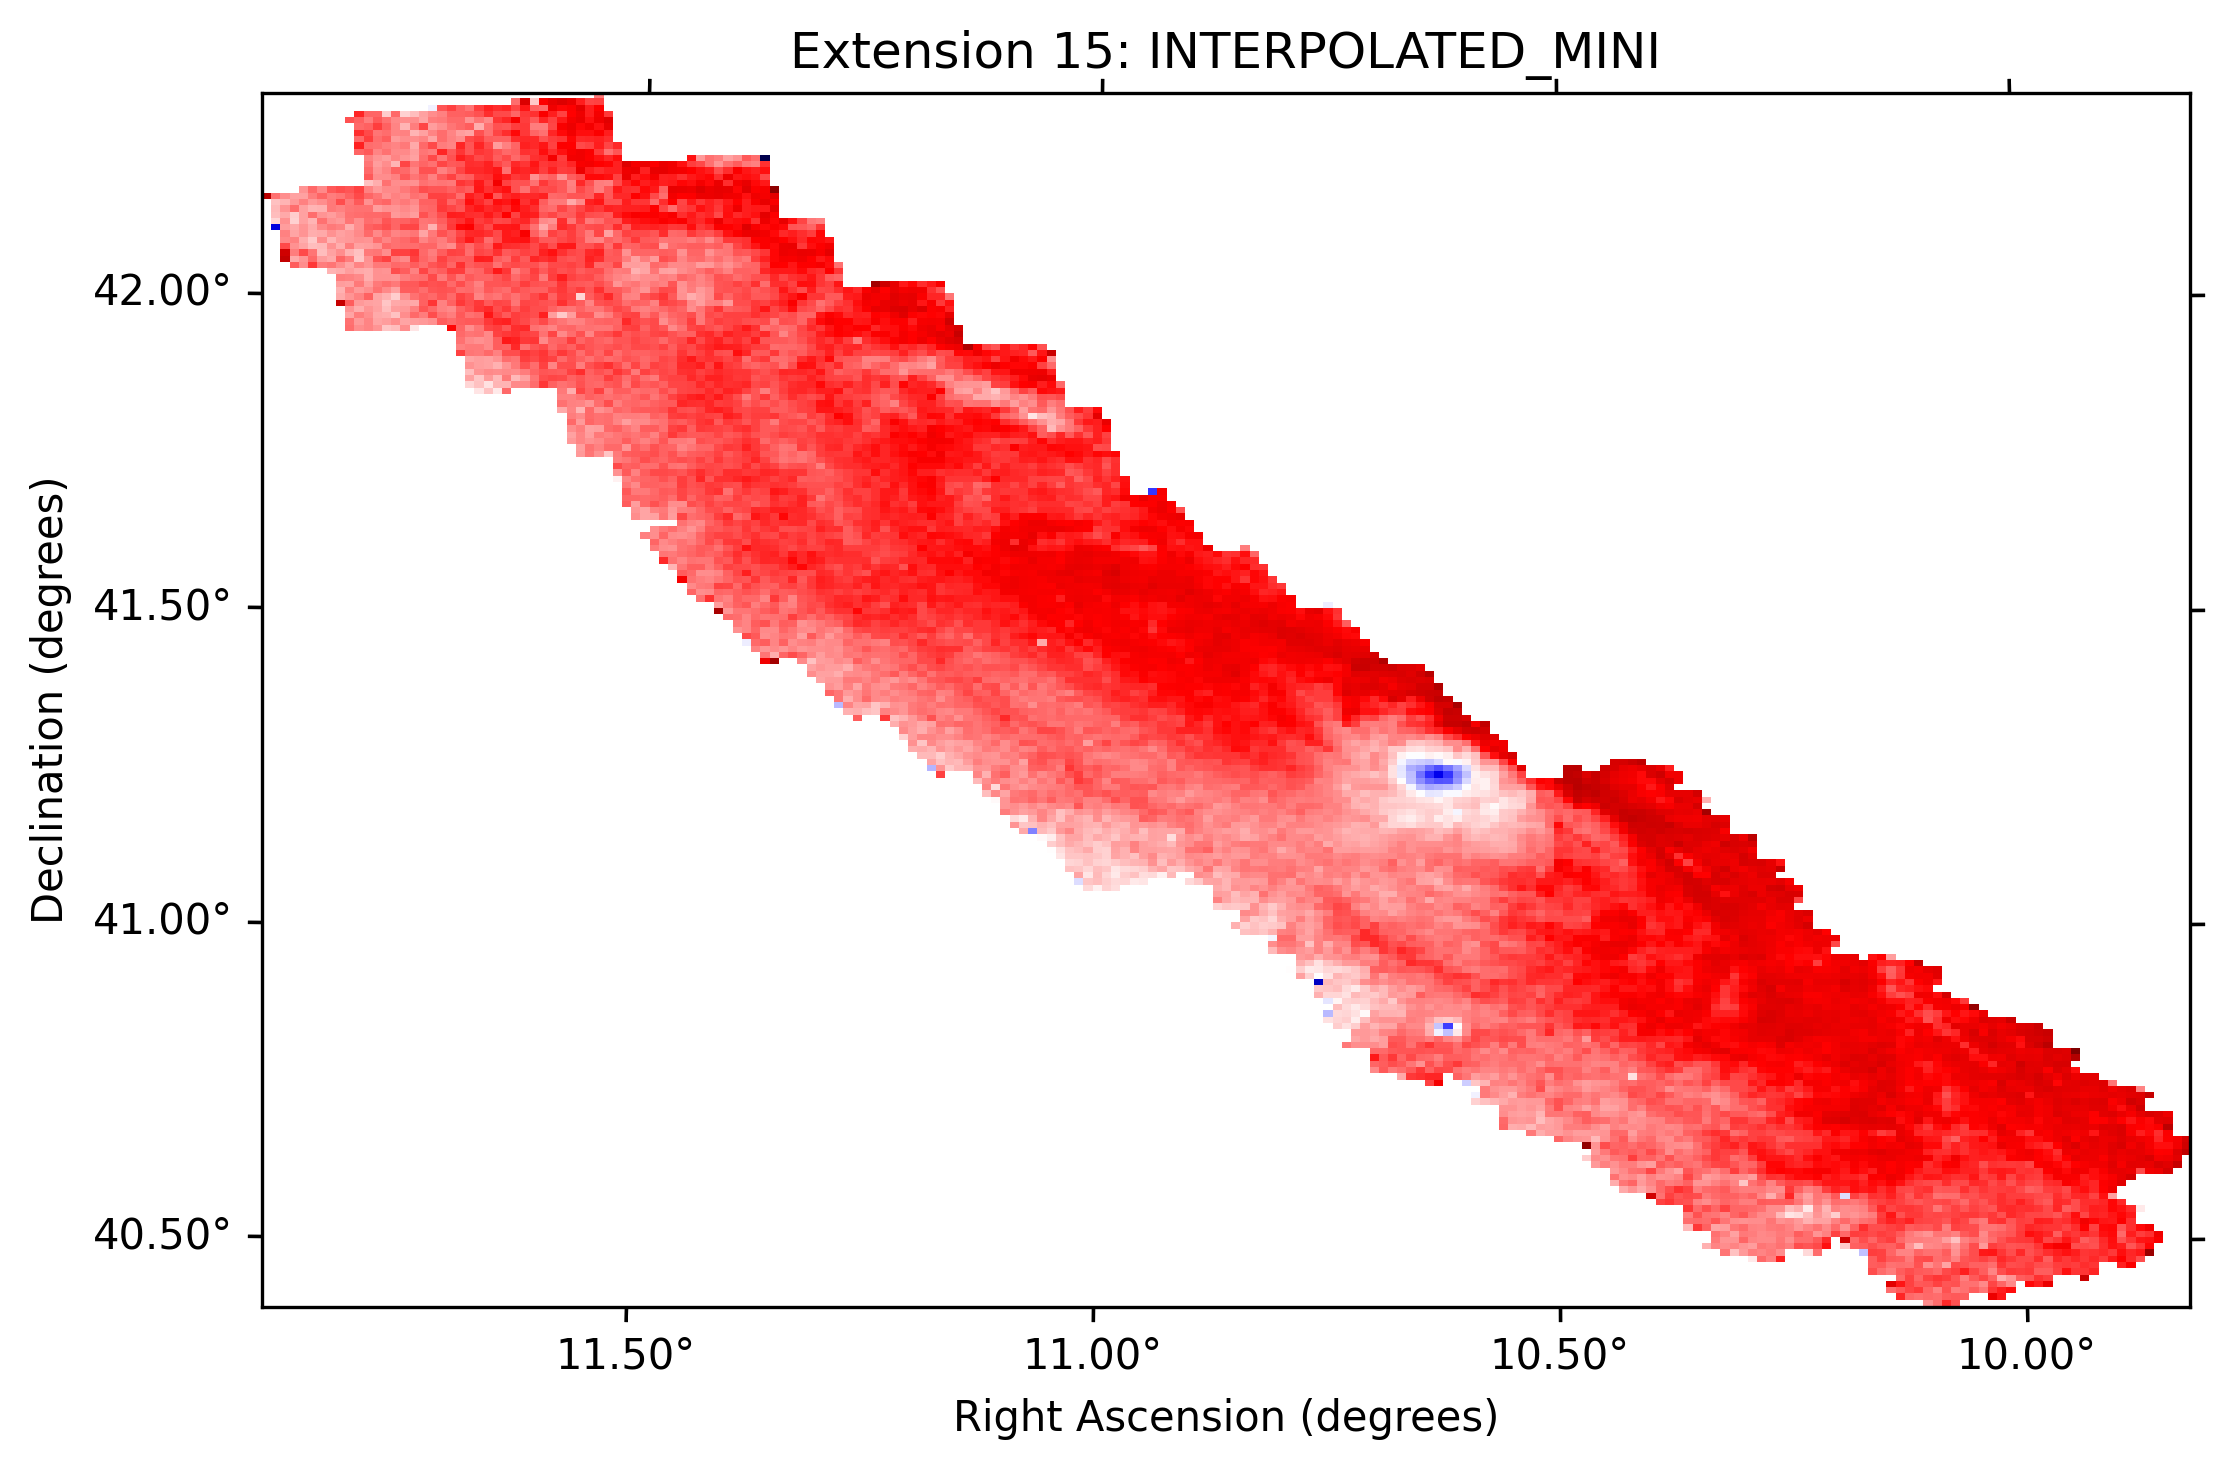

Extension 16: Data transposed and updated in FITS file
Extension 16: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


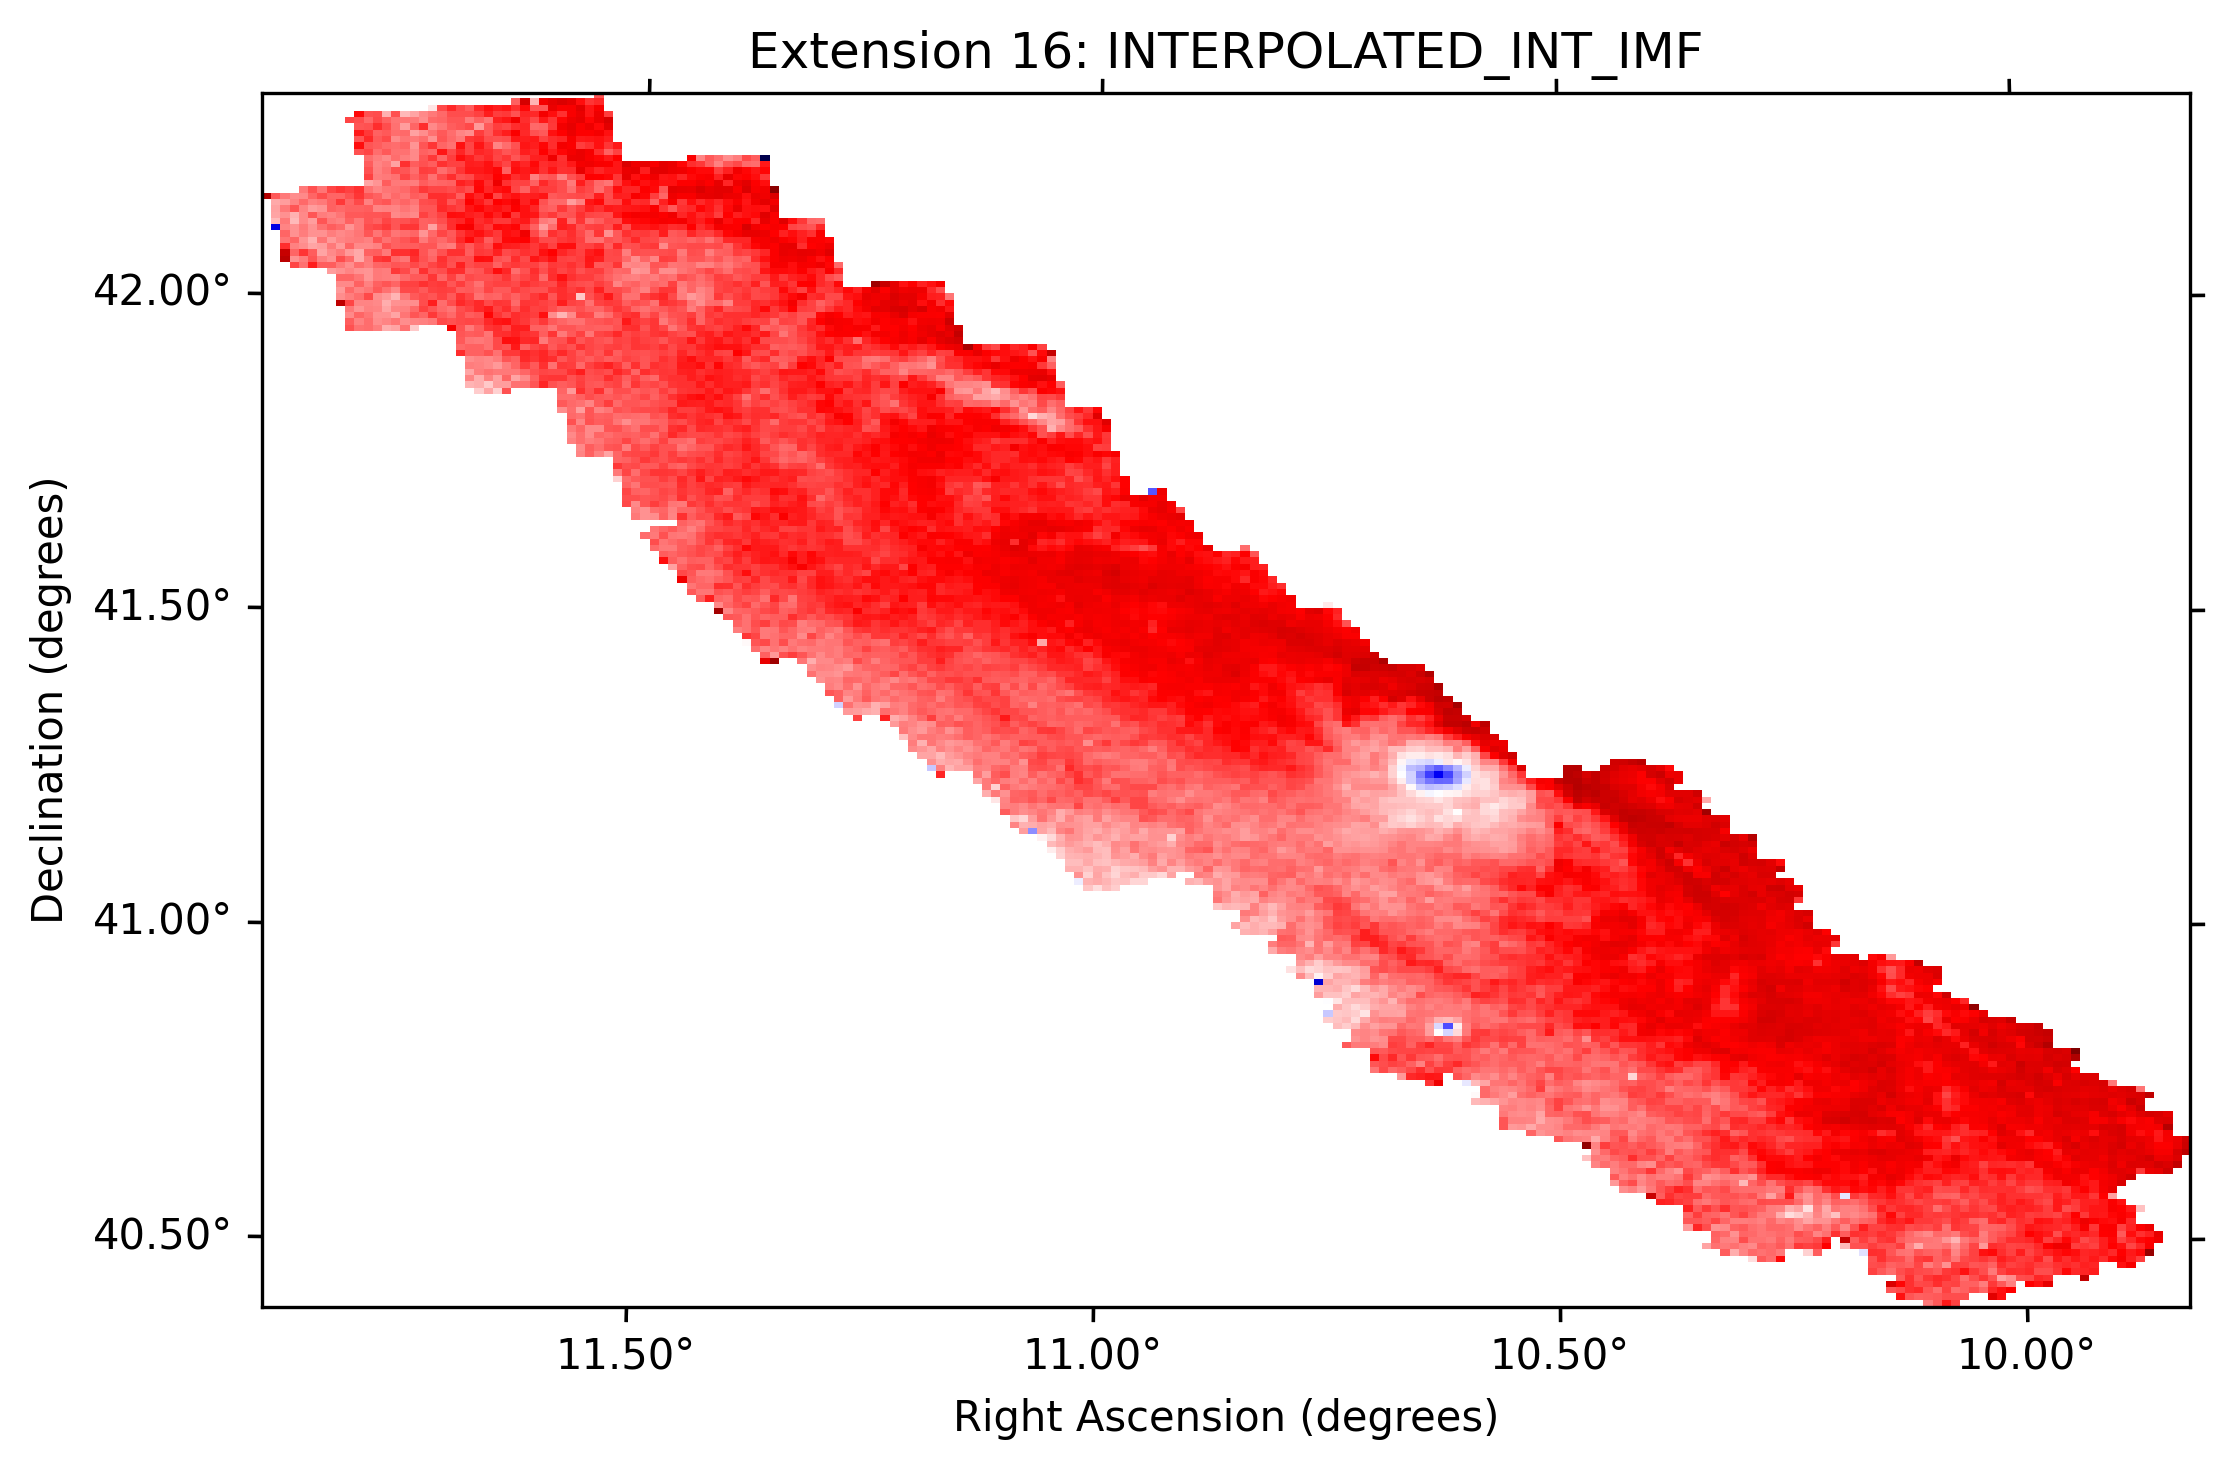

Extension 17: Data transposed and updated in FITS file
Extension 17: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


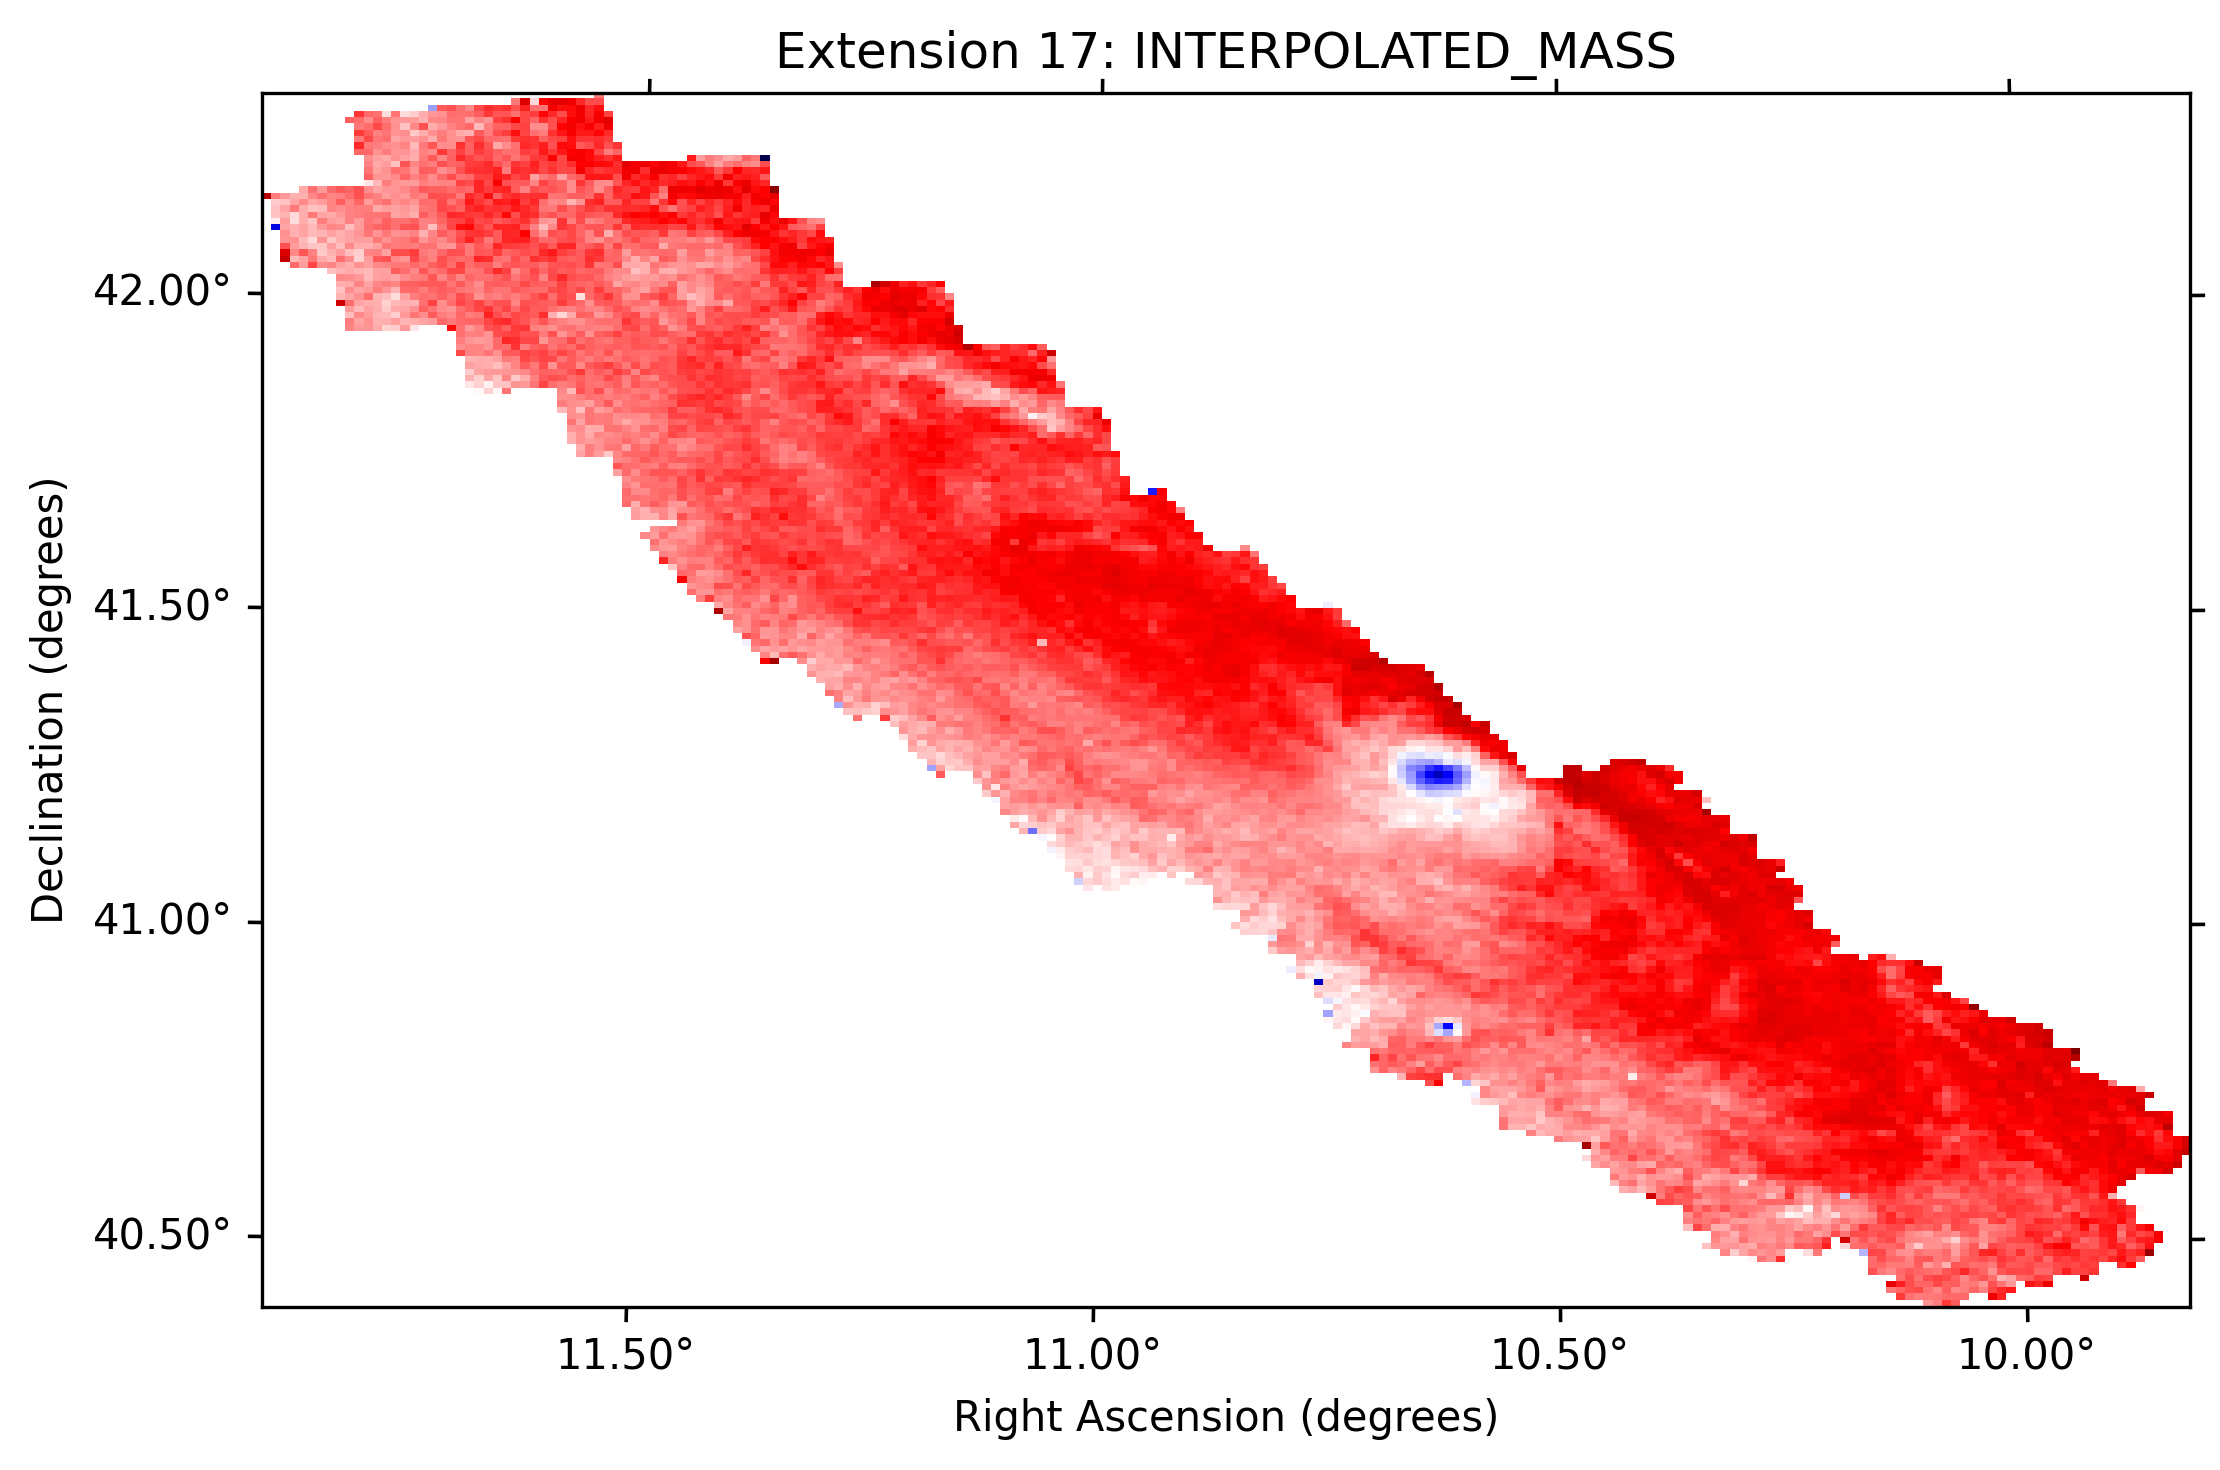

Extension 18: Data transposed and updated in FITS file
Extension 18: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


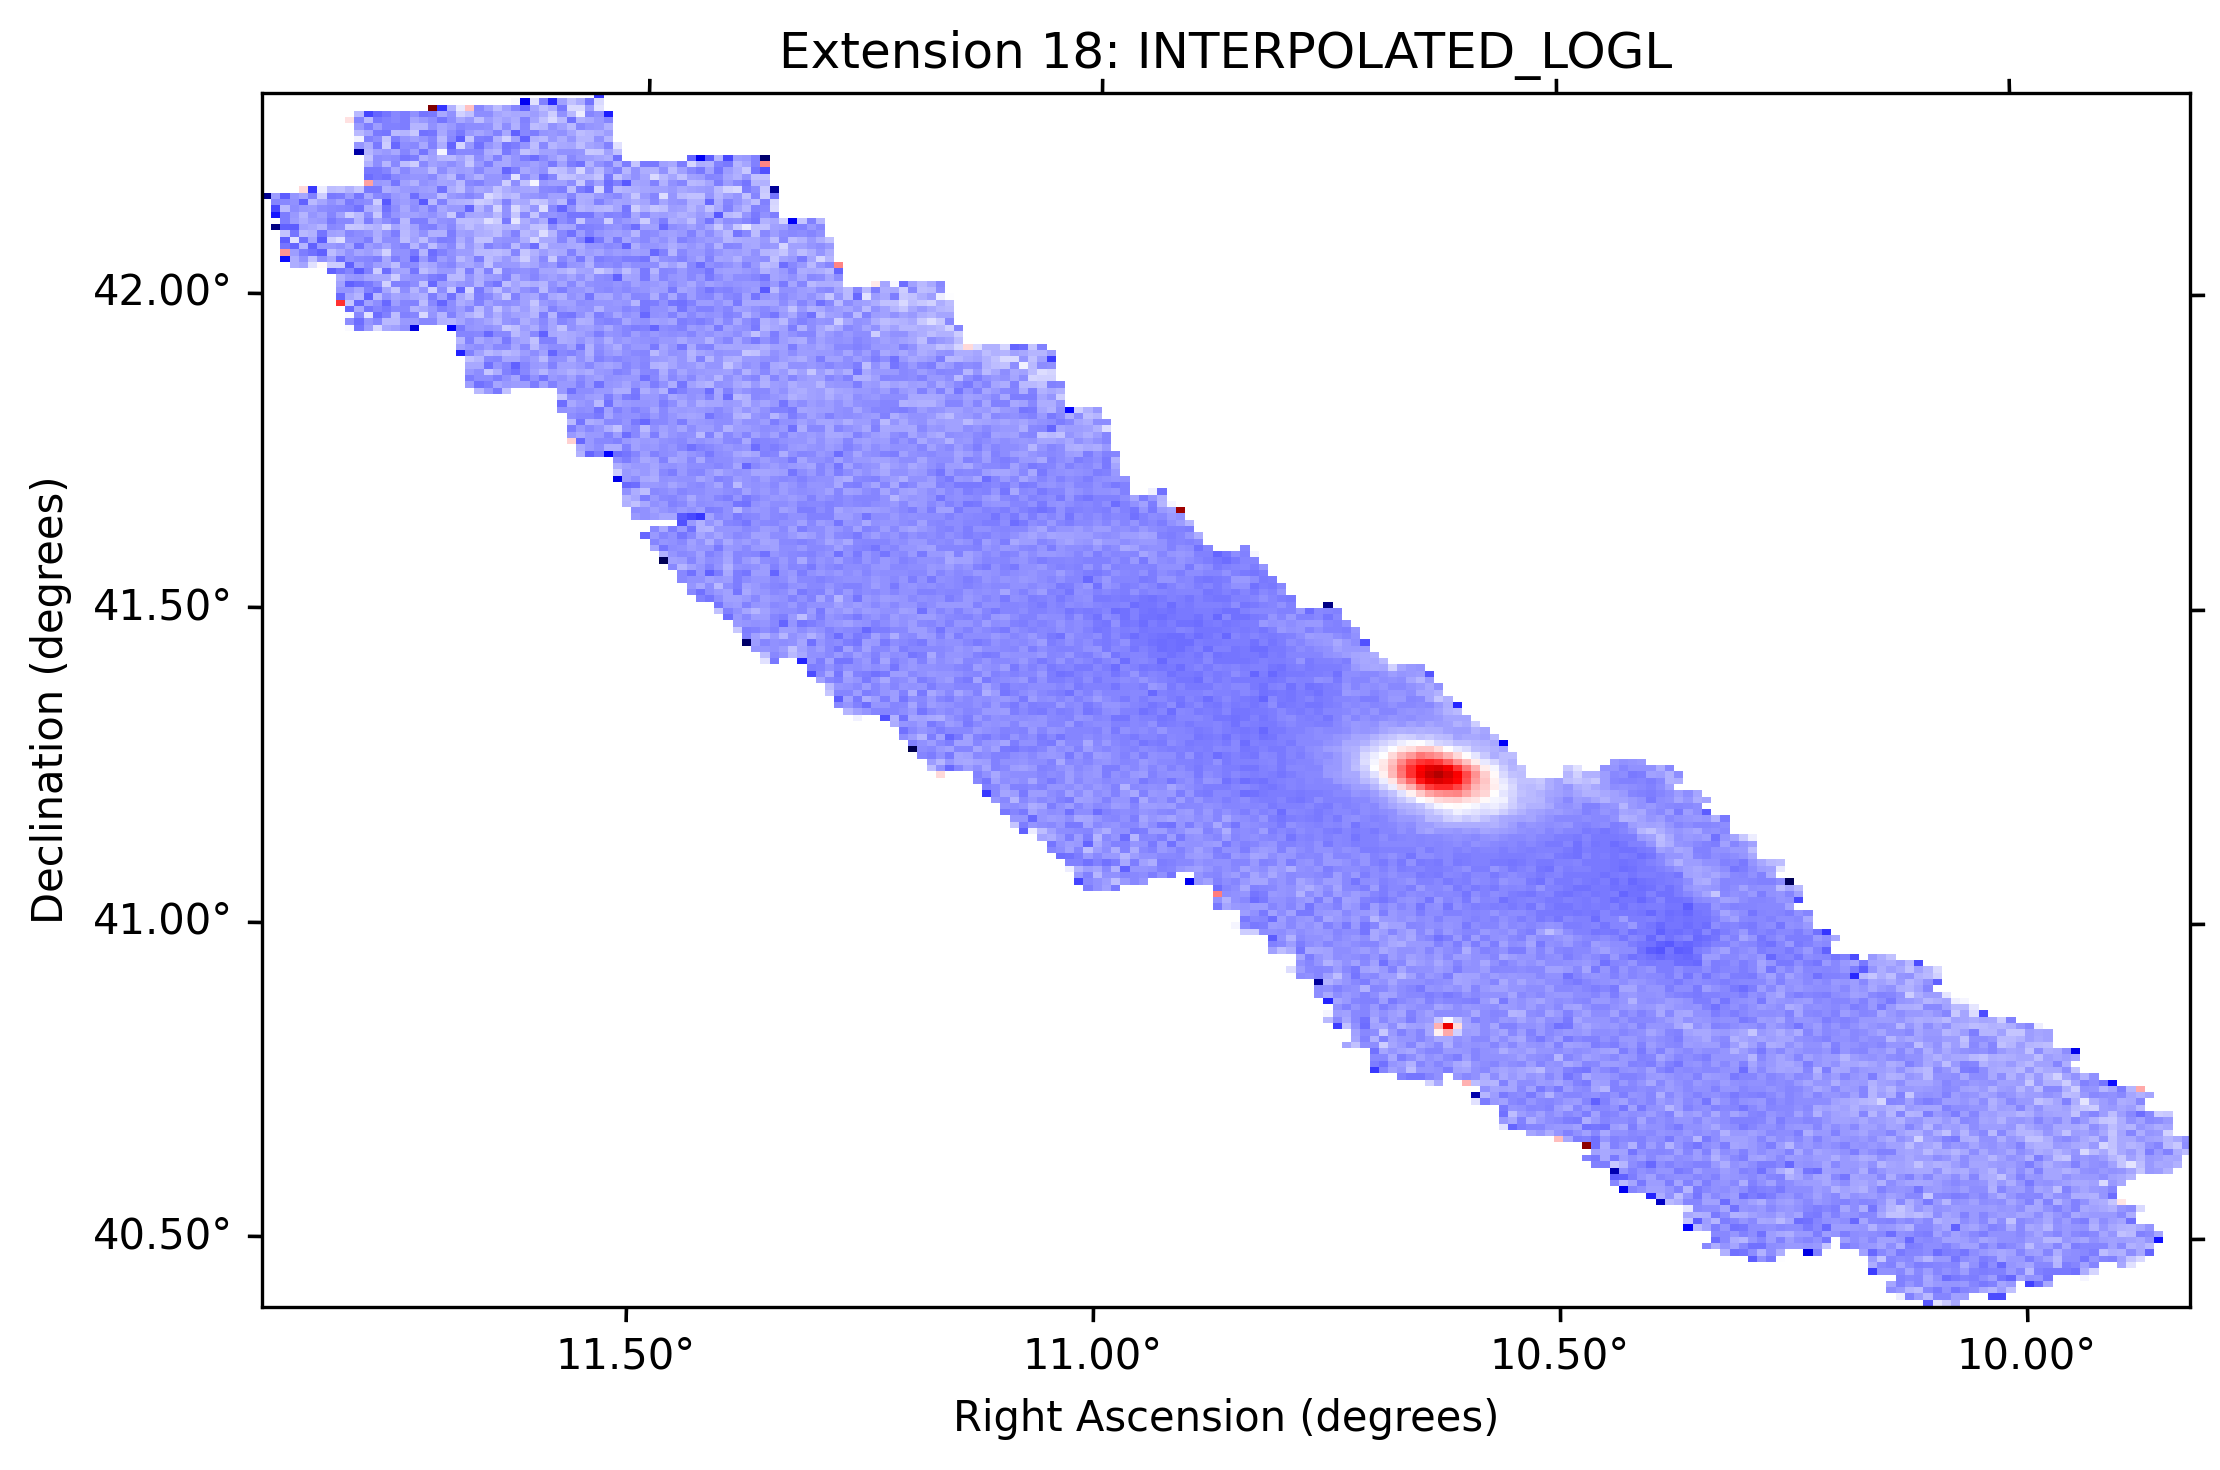

Extension 19: Data transposed and updated in FITS file
Extension 19: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


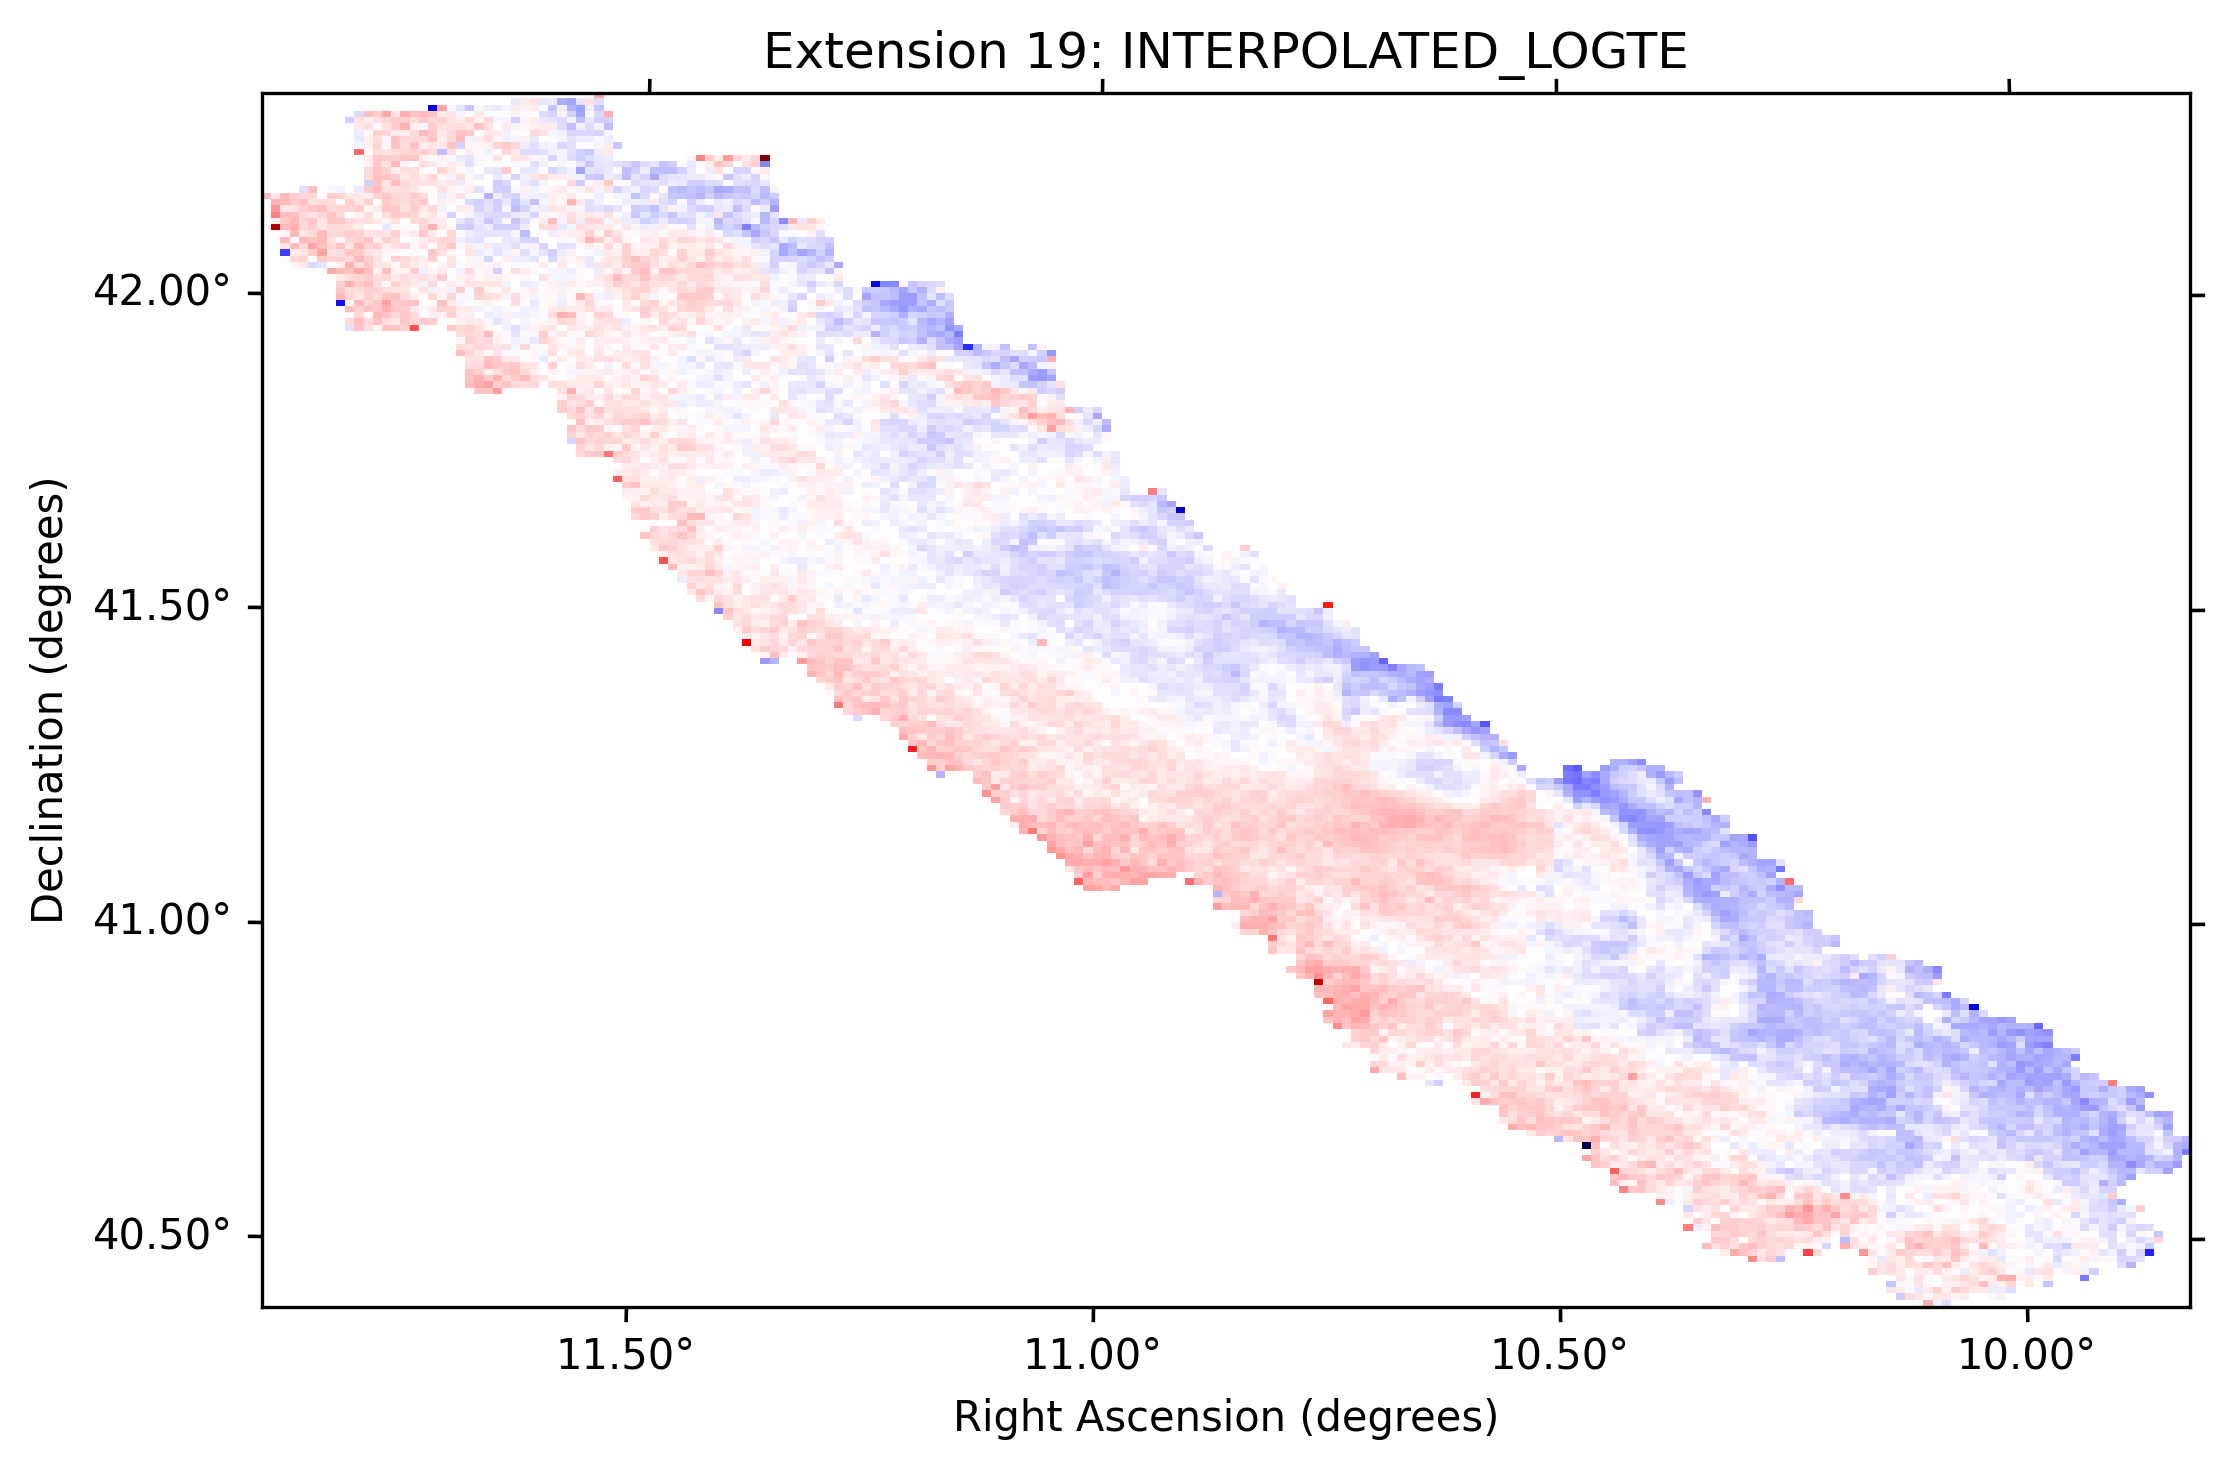

Extension 20: Data transposed and updated in FITS file
Extension 20: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


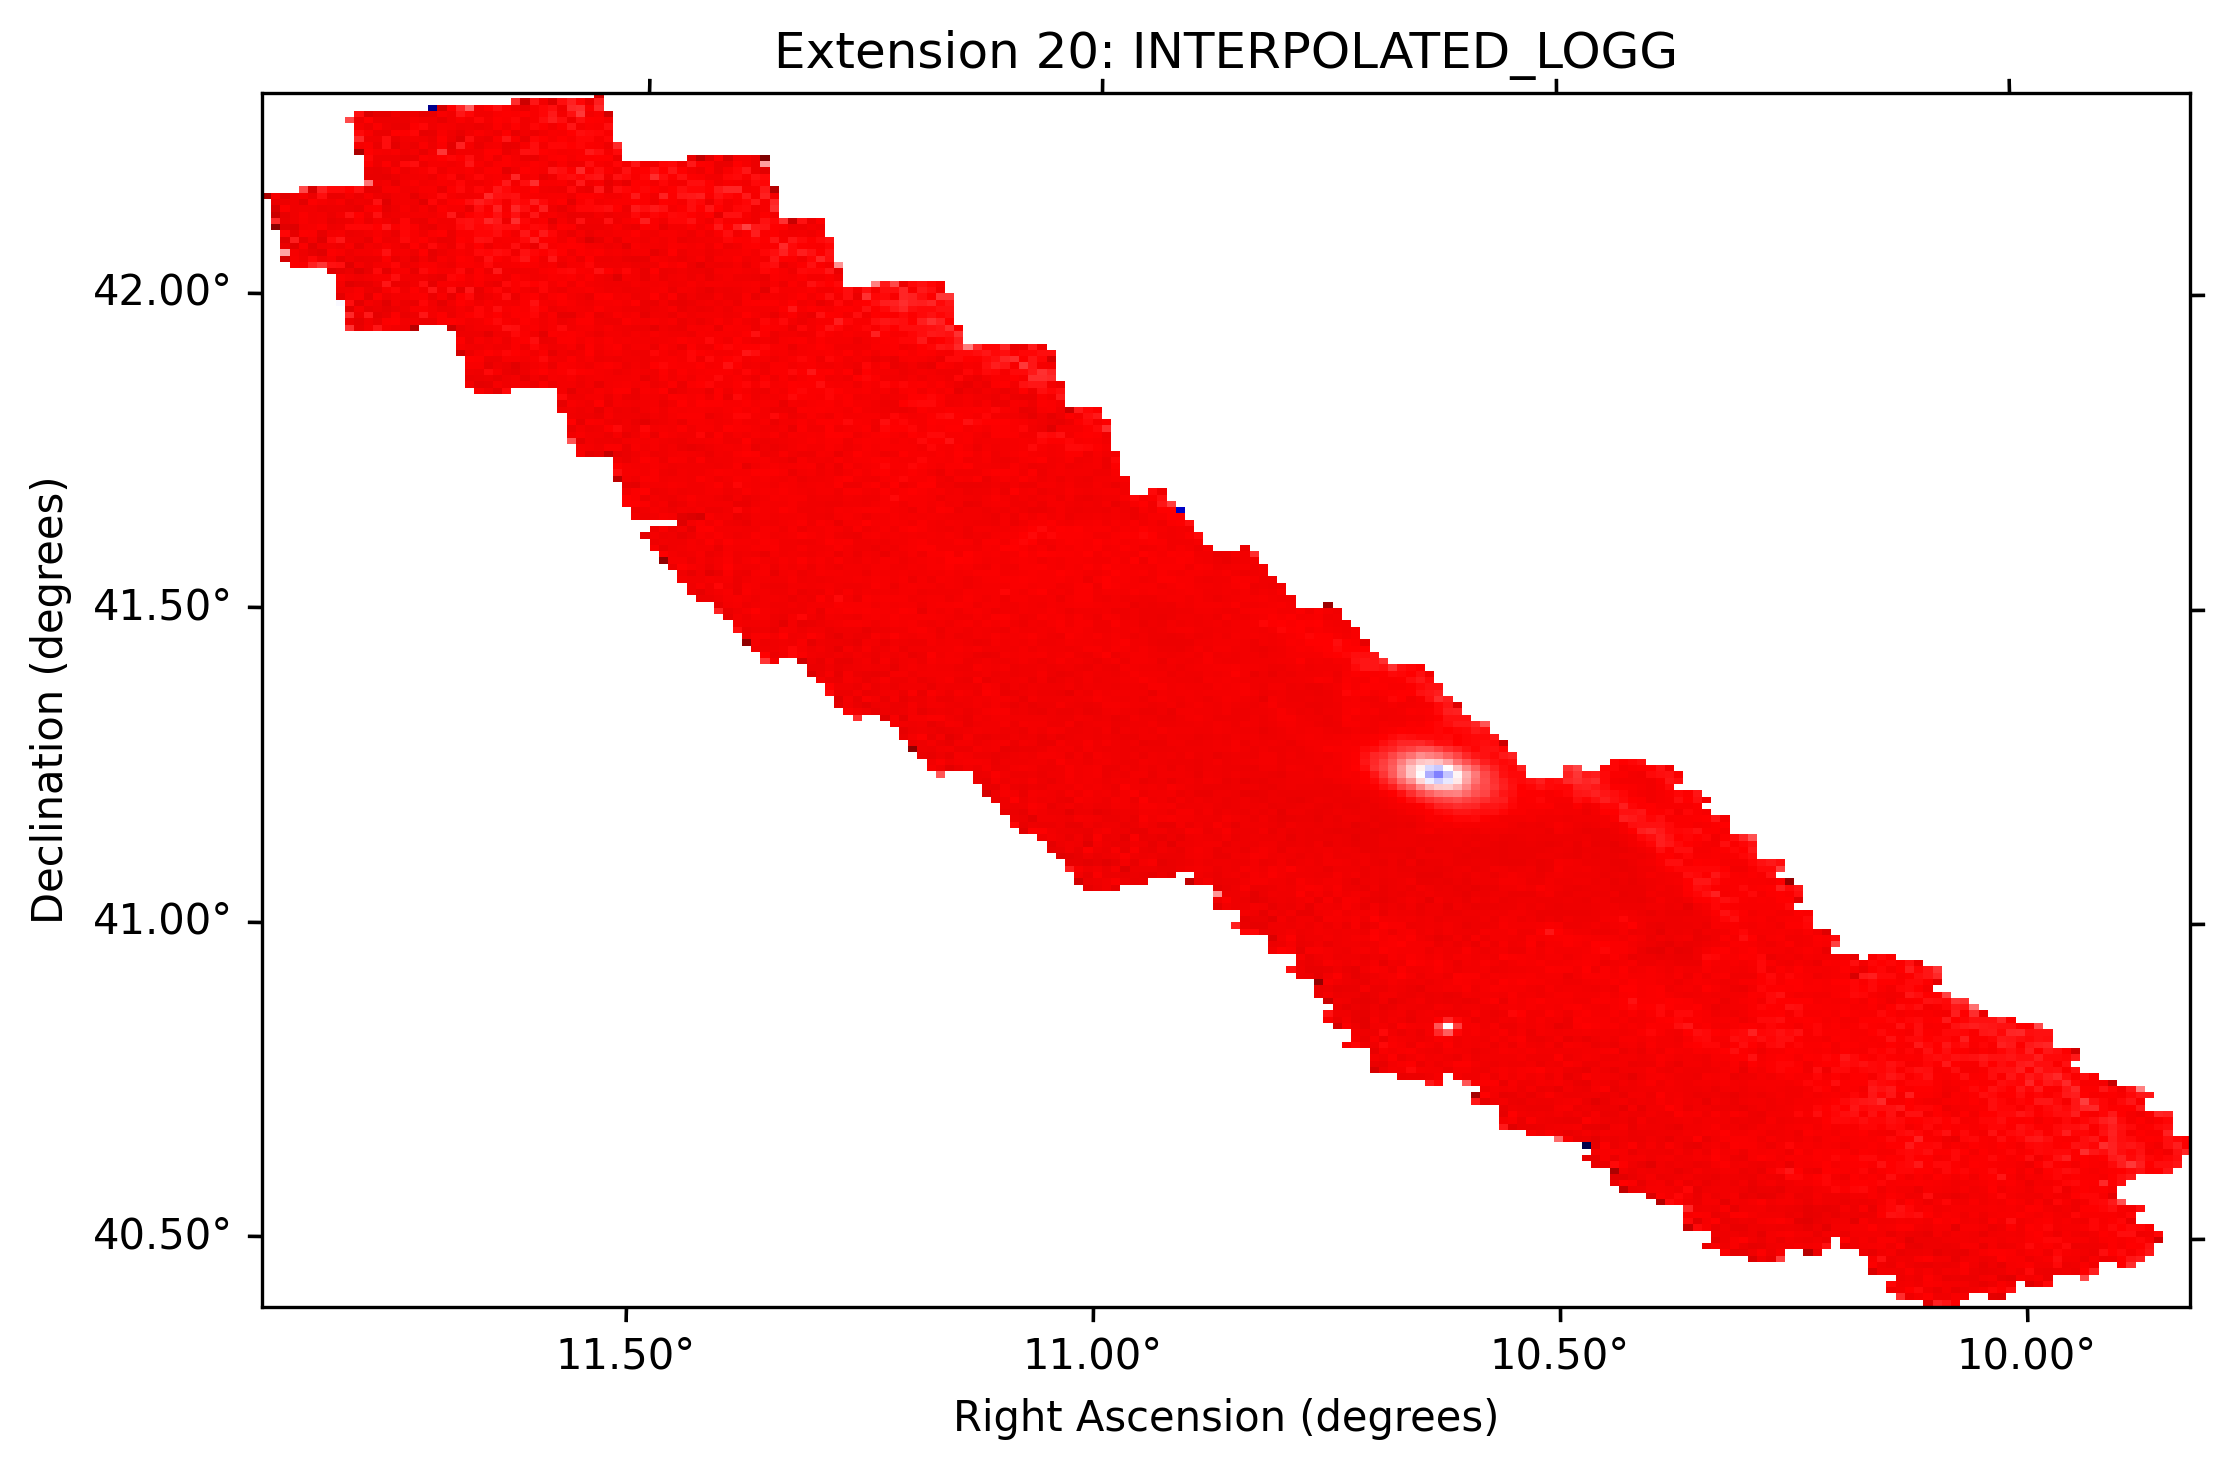

Extension 21: Data transposed and updated in FITS file
Extension 21: WCS info
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193


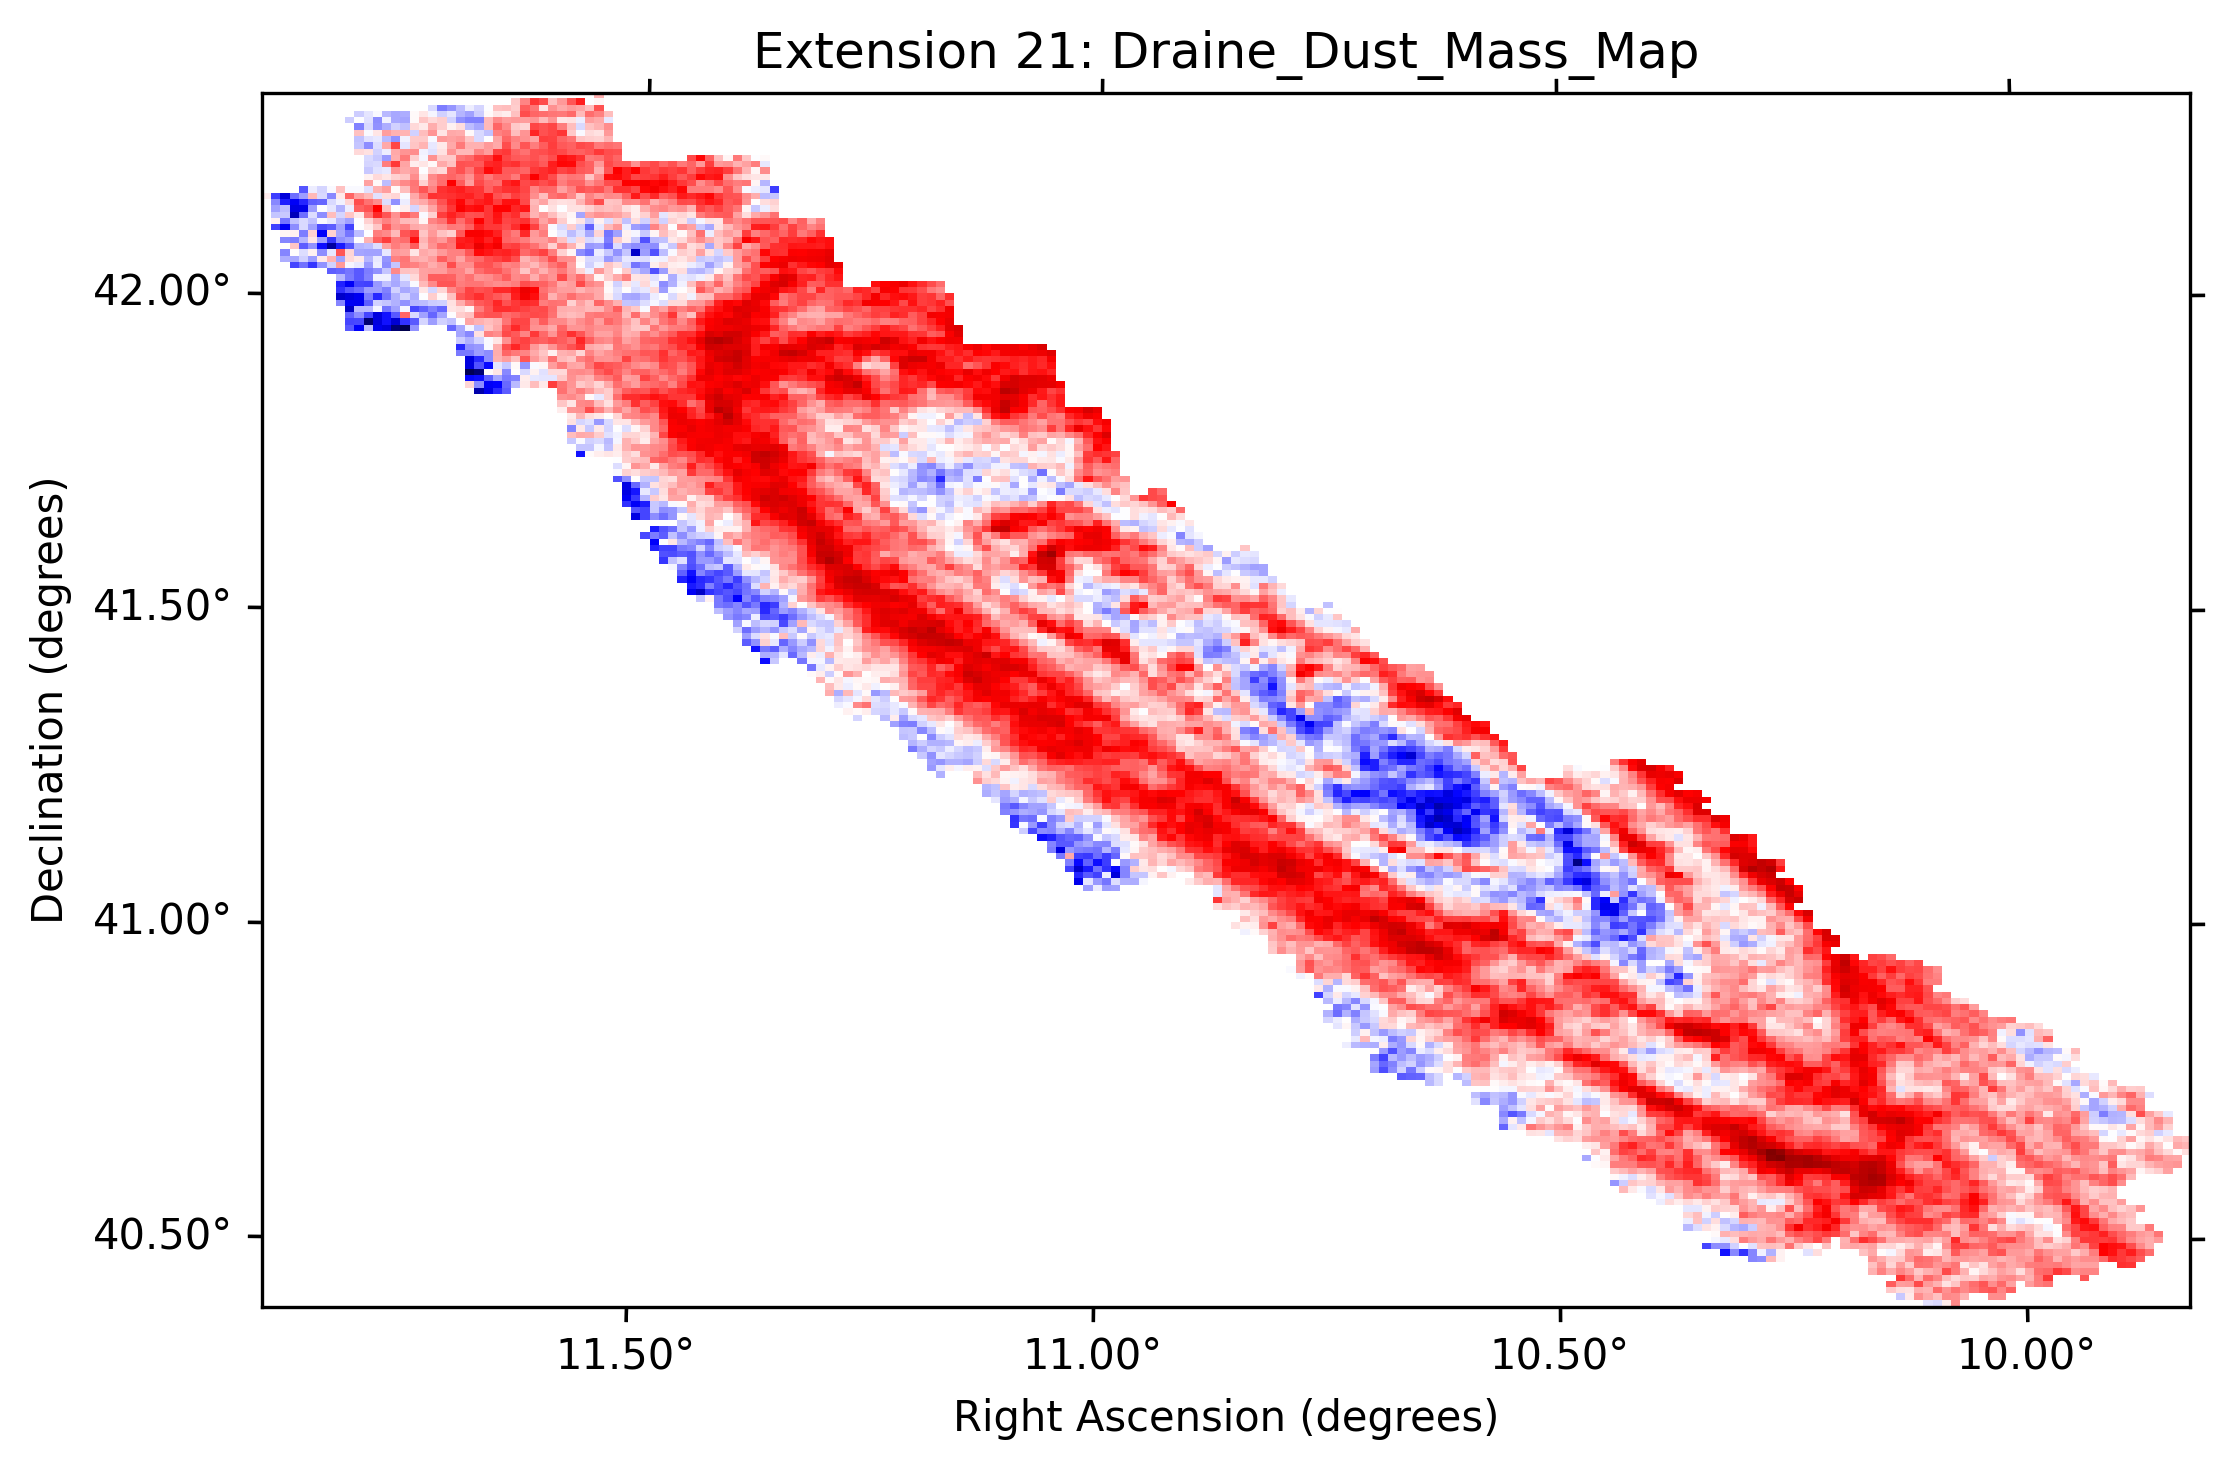

Saving fits file...


In [20]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import colors

# Path to the FITS file
fits_file_path = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits'

# Open the FITS file in update mode
with fits.open(fits_file_path) as hdu_list:
    # Iterate through each extension
    for i, hdu in enumerate(hdu_list):
        if hdu.data is not None:
            # Transpose the data
            # hdu.data = hdu.data
            print(f"Extension {i}: Data transposed and updated in FITS file")

            # Extract the WCS
            header = hdu.header
            wcs = WCS(header)
            print(f"Extension {i}: WCS info")
            print(wcs)
            
            # Create a figure and axis with WCS projection
            fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), subplot_kw={'projection': wcs}, dpi=300)
            
            # Set the format of the tick labels to decimal degrees
            ax.coords[0].set_format_unit('deg')
            ax.coords[1].set_format_unit('deg')
            ax.coords[0].set_major_formatter('d.dd')
            ax.coords[1].set_major_formatter('d.dd')
            
            # Optional: Customize the grid, labels, etc.
            # ax.coords.grid(True, color='gray', ls='dotted')
            ax.set_xlabel('Right Ascension (degrees)')
            ax.set_ylabel('Declination (degrees)')
            
            # Display the transposed data
            ax.imshow(hdu.data, cmap='seismic', norm=colors.LogNorm(), aspect='auto')
            
            # Invert the x-axis
            ax.invert_xaxis()
            
            # Set the title with the extension name
            ax.set_title(f"Extension {i}: {hdu.name}")
            
            # Adjust layout and show the plot
            plt.tight_layout()
            plt.show()

    # Save changes to the FITS file
    print('Saving fits file...')
    # hdul.writeto(fits_file_path, overwrite=overwrite)
    # hdu_list.flush()
    

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 10.65 41.2 
CRPIX : 84.0 81.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 0.0075241490889572 0.01 
NAXIS : 209  193
(193, 209)


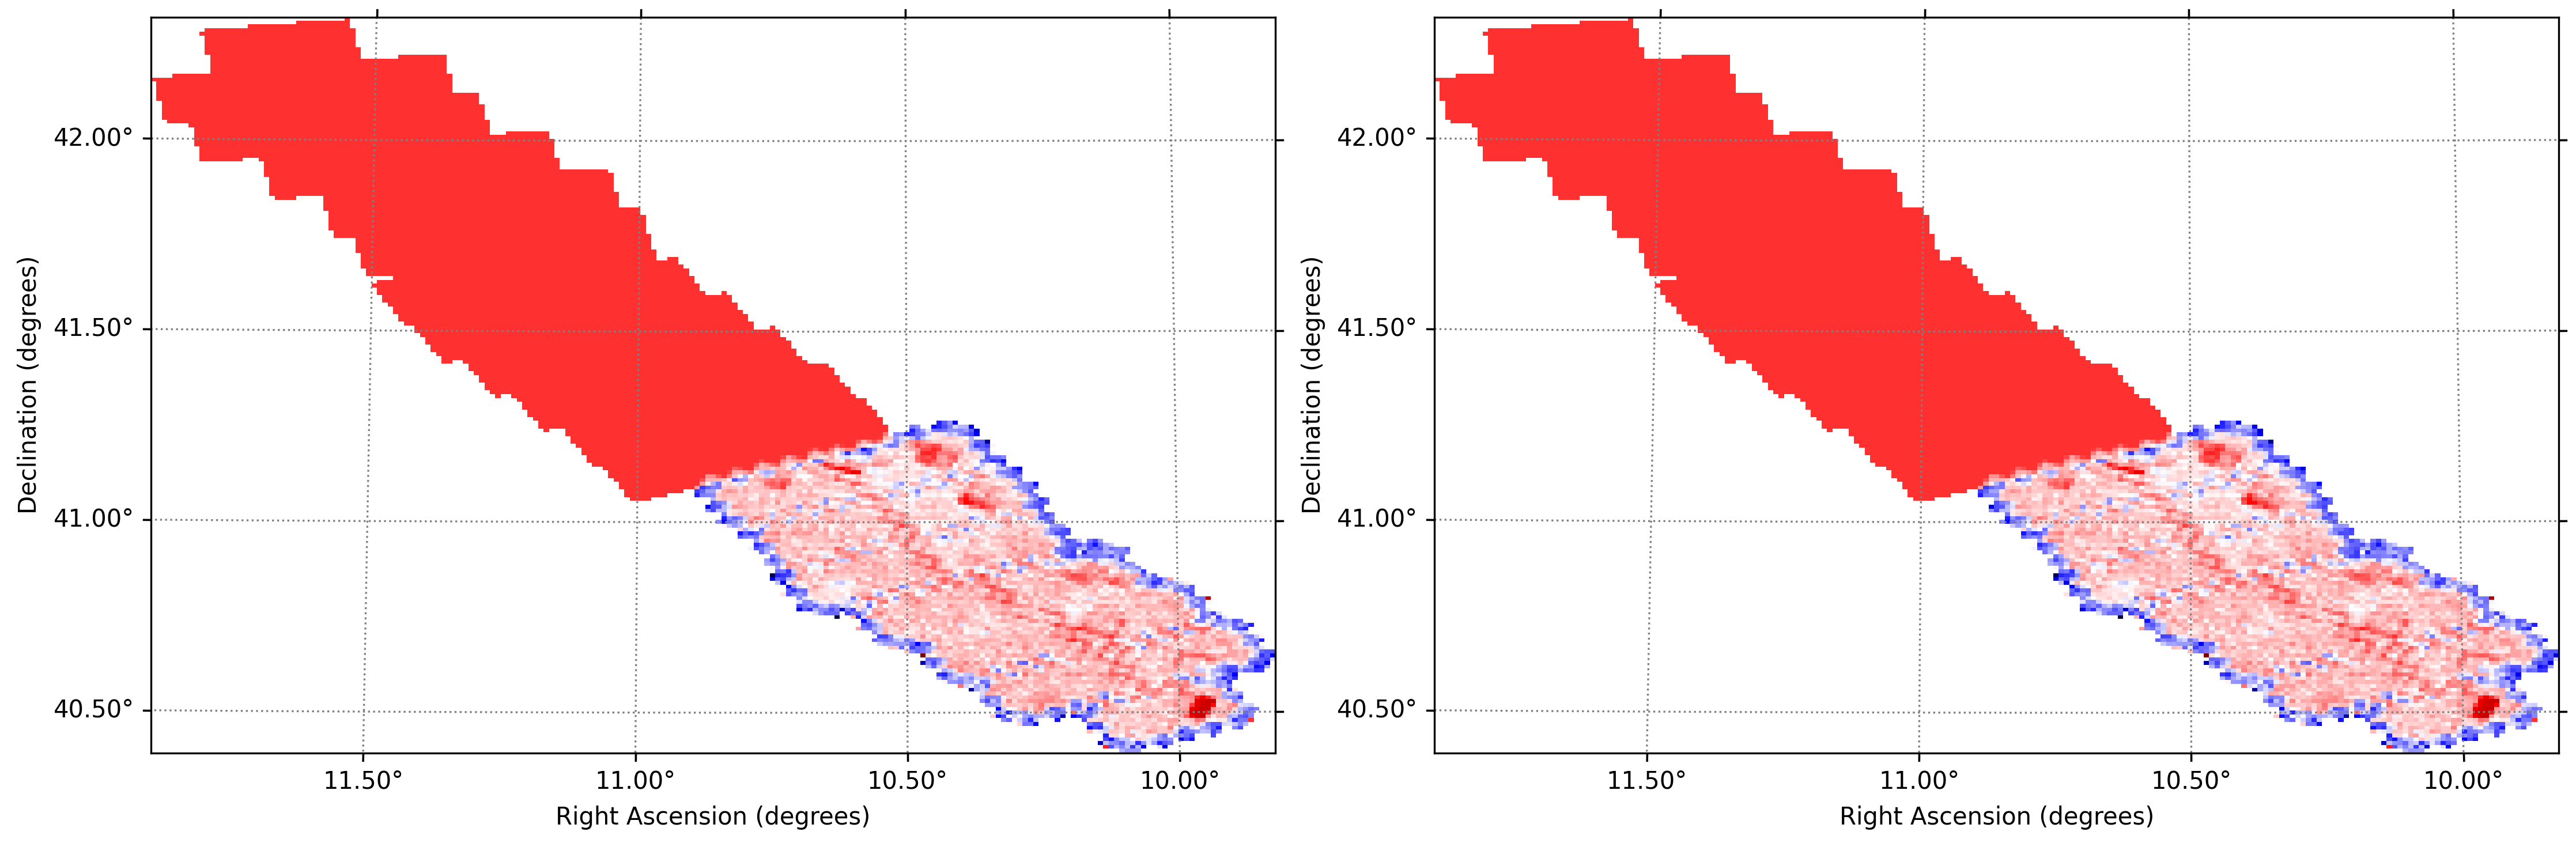

In [23]:
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits') as hdu:
    # Extract the WCS
    header = hdu[5].header
    wcs = WCS(header)
    print(wcs)

    # Start with the first image
    data_map = hdu[5].data
    print(data_map.shape)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5), subplot_kw={'projection': wcs}, dpi=300)
    for ax in axs:
        # Set the format of the tick labels to decimal degrees
        ax.coords[0].set_format_unit('deg')
        ax.coords[1].set_format_unit('deg')
        ax.coords[0].set_major_formatter('d.dd')
        ax.coords[1].set_major_formatter('d.dd')

        # Optional: Customize the grid, labels, etc.
        ax.coords.grid(True, color='gray', ls='dotted')
        ax.set_xlabel('Right Ascension (degrees)')
        ax.set_ylabel('Declination (degrees)')
        ax.imshow(data_map, cmap='seismic', norm=colors.LogNorm(), aspect='auto')

        # Invert the x-axis
        ax.invert_xaxis()

plt.tight_layout()

In [ ]:
# def open_and_select(photfile):
#     ds = vaex.open(photfile)
#     ds['f275w_st'] = ((ds['f275w_snr'] > 4) & (ds['f275w_sharp']**2 < 0.15))
#     ds['f275w_gst'] = (ds['f275w_st'] & (ds['f275w_crowd'] < 1.30))
#     ds['f336w_st'] = ((ds['f336w_snr'] > 4) & (ds['f336w_sharp']**2 < 0.15))
#     ds['f336w_gst'] = (ds['f336w_st'] & (ds['f336w_crowd'] < 1.30))
#     ds['uv_st'] = (ds['f275w_st'] & ds['f336w_st'])
#     ds['uv_gst'] = (ds['f275w_gst'] & ds['f336w_gst'])

#     ds['f475w_st'] = ((ds['f475w_snr'] > 4) & (ds['f475w_sharp']**2 < 0.2))
#     ds['f475w_gst'] = (ds['f475w_st'] & (ds['f475w_crowd'] < 2.25))
#     ds['f814w_st'] = ((ds['f814w_snr'] > 4) & (ds['f814w_sharp']**2 < 0.2))
#     ds['f814w_gst'] = (ds['f814w_st'] & (ds['f814w_crowd'] < 2.25))
#     ds['opt_st'] = (ds['f475w_st'] & ds['f814w_st'])
#     ds['opt_gst'] = (ds['f475w_gst'] & ds['f814w_gst'])
#     return ds

In [ ]:
m31_rgb_gregersen_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv')
median_arr, stellar_density_arr = plot_cmd_mdf_spatial(m31_rgb_gregersen_selection_df, 
                     savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/m31_cmd_mdf_spatial_gregersen_box_result.jpeg', 
                     bin_size_deg=0.01, z_col='interpolated_MH')
# !!! Takes 195 minutes to complete!

In [ ]:
# m31_rgb_gregersen_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_m31_MH_catalog.csv')
# median_arr, stellar_density_arr = plot_cmd_mdf_spatial(m31_rgb_gregersen_selection_df, 
#                      savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/m31_0001deg_cmd_mdf_spatial_gregersen_box.jpeg', 
#                      bin_size_deg=0.0001, z_col='interpolated_MH')

In [ ]:
# m31_rgb_gregersen_selection_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_m31_MH_catalog.csv')
# median_arr, stellar_density_arr = plot_cmd_mdf_spatial(m31_rgb_gregersen_selection_df, 
#                      savefig_filepath='/Users/mmckay/phd_projects/analysis_routine/FIGURES/m31_F814W_0001deg_cmd_mdf_spatial_gregersen_box.jpeg', 
#                      bin_size_deg=0.0001, z_col='f814w_vega')

In [3]:
# Bin MH spatially
m31_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv')
bin_size_deg = 0.01
m31_min_ra, m31_max_ra, m31_min_dec, m31_max_dec, m31_median_values, m31_sum_values, m31_bin_counts_nonzero, = create_spatial_bins_and_median_optimized(m31_df.ra, m31_df.dec, m31_df.interpolated_MH, bin_size_deg)


In [6]:
# Bin MH spatially
m31_df = pd.read_csv('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/interpolated_m31_MH_catalog.csv')
bin_size_deg = 0.01
m31_min_ra, m31_max_ra, m31_min_dec, m31_max_dec, m31_median_values, m31_sum_values, m31_bin_counts_nonzero, = create_spatial_bins_and_median_optimized(m31_df.ra, m31_df.dec, m31_df.interpolated_MH, bin_size_deg)



# Add Stellar Density 
m31_fitspath = '/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits'
with fits.open(m31_fitspath, mode='update') as hdul:
    if 'STELLAR_DENSITY' in hdul:
        del hdul['STELLAR_DENSITY']
    hdul.info()
    new_hdu = fits.ImageHDU(data=m31_bin_counts_nonzero)
    new_hdu.header['EXTNAME'] = 'STELLAR_DENSITY'
    # Append the new HDU to the existing HDUList
    hdul.append(new_hdu)

    # Save the modified HDUList to the FITS file
    hdul.writeto(m31_fitspath, overwrite=True)
    hdul.info()

# Open the FITS file
with fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits', mode='update') as hdul:
    # Get the primary header
    primary_header = hdul[0].header

    # Loop through each extension
    for hdu in hdul[1:]:
        # Set the header of the extension to match the primary header
        for key in primary_header:
            if key not in hdu.header:
                hdu.header[key] = primary_header[key]

Filename: /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  F475W_VEGA    1 ImageHDU        25   (193, 209)   float64   
  2  F475W_SNR     1 ImageHDU        25   (193, 209)   float64   
  3  F475W_CROWD    1 ImageHDU        25   (193, 209)   float64   
  4  F475W_SHARP    1 ImageHDU        25   (193, 209)   float64   
  5  F475W_FLAG    1 ImageHDU        25   (193, 209)   float64   
  6  F814W_VEGA    1 ImageHDU        25   (193, 209)   float64   
  7  F814W_SNR     1 ImageHDU        25   (193, 209)   float64   
  8  F814W_CROWD    1 ImageHDU        25   (193, 209)   float64   
  9  F814W_SHARP    1 ImageHDU        25   (193, 209)   float64   
 10  F814W_FLAG    1 ImageHDU        25   (193, 209)   float64   
 11  F814W_VEGA_ECORR    1 ImageHDU        25   (193, 209)   float64   
 12  F475W_VEGA_ECORR    1 ImageHDU      

Filename: /Users/mmckay/phd_projects/analysis_routine/DATA/4GYRS_RGB_AGB_isochrones/RGB/m31_g15_RGB_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  F475W_VEGA    1 ImageHDU        25   (193, 209)   float64   
  2  F475W_SNR     1 ImageHDU        25   (193, 209)   float64   
  3  F475W_CROWD    1 ImageHDU        25   (193, 209)   float64   
  4  F475W_SHARP    1 ImageHDU        25   (193, 209)   float64   
  5  F475W_FLAG    1 ImageHDU        25   (193, 209)   float64   
  6  F814W_VEGA    1 ImageHDU        25   (193, 209)   float64   
  7  F814W_SNR     1 ImageHDU        25   (193, 209)   float64   
  8  F814W_CROWD    1 ImageHDU        25   (193, 209)   float64   
  9  F814W_SHARP    1 ImageHDU        25   (193, 209)   float64   
 10  F814W_FLAG    1 ImageHDU        25   (193, 209)   float64   
 11  F814W_VEGA_ECORR    1 ImageHDU        25   (193, 209)   float64   
 12  F475W_VEGA_ECORR    1 ImageHDU      

In [ ]:
# plt.figure(figsize=(15,10))
# plt.imshow(m31_median_values.T, origin='lower', extent=[m31_min_ra, m31_max_ra, m31_min_dec, m31_max_dec], cmap='magma', vmin=-0.3, vmax=0.5, label=f'M31 {len(m31_median_values)}')
# plt.colorbar(label='[M/H] Median')
# plt.xlabel('RA')
# plt.ylabel('Dec')
# plt.title(f'Spatial Bin = {bin_size_deg}')
# plt.legend()
# plt.savefig('/Users/mmckay/phd_projects/analysis_routine/FIGURES/m31_MH_spatial_bins.jpg', format='jpeg')
# plt.show()

In [8]:
m31_rgb_gregersen_selection_df.columns

Index(['Unnamed: 0', 'ra', 'dec', 'f475w_vega', 'f475w_snr', 'f475w_crowd',
       'f475w_sharp', 'f475w_flag', 'f814w_vega', 'f814w_snr', 'f814w_crowd',
       'f814w_sharp', 'f814w_flag', 'f814w_vega_ecorr', 'f475w_vega_ecorr',
       'f475w-f814w_ecorr', 'interpolated_MH', 'interpolated_Mini',
       'interpolated_int_IMF', 'interpolated_Mass', 'interpolated_logL',
       'interpolated_logTe', 'interpolated_logg'],
      dtype='object')

# PHATTER

In [ ]:
# phatter_hdu = fits.open('/Users/mmckay/phd_projects/analysis_routine/DATA/hlsp_phatter_hst_wfc3-uvis-acs-wfc-wfc3-ir_m33_f275w-f336w-f475w-f814w-f110w-f160w_v1_phot.fits')
# phatter_hdu.info()

In [ ]:
phatter_fits_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/hlsp_phatter_hst_wfc3-uvis-acs-wfc-wfc3-ir_m33_f275w-f336w-f475w-f814w-f110w-f160w_v1_phot.fits'
output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phatter_f475W_f814W_table.csv'
phatter_df = make_optical_photmetry_from_hst_dataproduct(photmetry_catalog_filepath=phatter_fits_filepath, output_csv_filepath=output_file)

In [ ]:
output_file = '/Users/mmckay/phd_projects/analysis_routine/DATA/phatter_f475W_f814W_table.csv'
phatter_df = reduce_optical_photmetry_table(photometry_fits_filepath=output_file, 
                                            output_filepath='/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phatter_table.csv')


In [ ]:
catalog_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/reduced_phatter_table.csv'
isochrone_csv_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/phatter_RGB_isochrone_tables/RGB_AGB_isochrone_table.csv'
output_filepath = '/Users/mmckay/phd_projects/analysis_routine/DATA/interpolated_phatter_rgb_agb_selection.csv'

interpolated_phatter_rgb_agb = catalog_linear_interpolation(catalog_csv_filepath, 
                                                            isochrone_csv_filepath, 
                                                            output_filepath, 
                                                            savefile=True)